In [1]:
'''
Date: 20/6/2022
Auther: Yike Xie
Content: making figures for cell-cell communication 
'''


'\nDate: 20/6/2022\nAuther: Yike Xie\nContent: making figures for cell-cell communication \n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [4]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_luca_NKT_202206.h5ad'
adata = sc.read_h5ad(path)

adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [5]:
# #rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_data(adata_kid) # 'cell_type_new', 'cell_subtype_new'

/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:172: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_type_new'].cat.reorder_categories(group_order_primary, inplace=True)
/home/yike/phd/dengue/dengue_children/paper_figures/final/modules/YK_util.py:204: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['cell_subtype_new'].cat.reorder_categories(group_order_secondary, inplace=True)


In [6]:
#load interaction file
fn_int='/home/yike/phd/dengue/data/interaction_source_file/inters_YK_20220324.tsv'
interactions = pd.read_csv(fn_int, sep='\t', dtype={'is_stimulation': 'object',
                                             'is_inhibition': 'object',
                                             'consensus_direction': 'object',
                                             'consensus_stimulation': 'object',
                                             'consensus_inhibition': 'object',
                                             'database_intercell_source': 'object',
                                             'transmitter_intercell_source': 'object',
                                             'receiver_intercell_source': 'object',
                                             'secreted_intercell_source': 'object',
                                             'plasma_membrane_transmembrane_intercell_source': 'object',
                                             'plasma_membrane_peripheral_intercell_source': 'object',
                                             'database_intercell_target': 'object',
                                             'transmitter_intercell_target': 'object',
                                             'receiver_intercell_target': 'object',
                                             'secreted_intercell_target': 'object',
                                             'plasma_membrane_transmembrane_intercell_target': 'object',
                                             'plasma_membrane_peripheral_intercell_target': 'object'})[['genesymbol_intercell_target', 'genesymbol_intercell_source']]
genes = np.unique(interactions)
genes = [gene for gene in genes if gene in adata_kid.var_names]

interactions = interactions[interactions['genesymbol_intercell_target'].isin(genes) & interactions['genesymbol_intercell_source'].isin(genes)]

In [7]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_5/full_omnipath/'
ori_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/full_omnipath/'

In [8]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].cat.categories.tolist()
cell_types.remove('megakaryocytes')
cell_subtypes = adata_kid.obs['cell_subtype_new'].cat.categories.tolist()

In [9]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [10]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ naive T cells', 'CD4+ memory T cells', 'CD8+ naive T cells', 'CD8+ effector memory T cells', 'CD8+ exhausted T cells', 'Tregs', 'MAIT', 'signaling NK cells', 'cytotoxic NK cells', 'proliferating NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'cDC1', 'cDC2', 'pDCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.4392156862745098, 0.5019607843137255, 0.5647058823529412),
 (0.0, 0.0, 0.5019607843137255),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.7490196078431373, 1.0),
 (0.0, 1.0, 1.0),
 (0.37254901960784315, 0.6196078431372549, 0.6274509803921569),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (1.0, 0.0, 1.0),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (1.0, 0.7529411764705882, 0.796078431372549),
 (1.0, 0.0784313725490196, 0.5764705882352941),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [11]:
def get_inters_med_pair(data_ct, cts, med_pair_cut_off, fra_exp_cut_off):    
    fn_int = '/home/yike/phd/dengue/data/interaction_source_file/inters_YK_20220324.tsv'
    interactions = pd.read_csv(fn_int, sep='\t')[['genesymbol_intercell_source', 'genesymbol_intercell_target']]
    res = []
    for _, row in interactions.iterrows():
        ga = row['genesymbol_intercell_source']
        gb = row['genesymbol_intercell_target']
        if (ga not in genes) | (gb not in genes):
            continue
        for cst in cts:
            cst_med = {gene: data_ct.loc[cst, gene]['med_pair'] for gene in [ga, gb]} 
            cst_fra_pair = {gene: data_ct.loc[cst, gene]['fra_pair'] for gene in [ga, gb]} 
            cst_neg_fra_pair = {gene: data_ct.loc[cst, gene]['neg_fra_pair'] for gene in [ga, gb]}
            cst_fra = {(gene, cd): data_ct.loc[cst, gene][cd+'_fra'] for gene in [ga, gb] for cd in ['S', 'NS']}
            for ct in cts:
                ct_med = {gene: data_ct.loc[ct, gene]['med_pair'] for gene in [ga, gb]}
                ct_fra_pair = {gene: data_ct.loc[ct, gene]['fra_pair'] for gene in [ga, gb]}
                ct_neg_fra_pair = {gene: data_ct.loc[cst, gene]['neg_fra_pair'] for gene in [ga, gb]}
                ct_fra = {(gene, cd): data_ct.loc[ct, gene][cd+'_fra'] for gene in [ga, gb] for cd in ['S', 'NS']}
                
                #####################
                if (cst_med[ga] > med_pair_cut_off) & (ct_med[gb] > med_pair_cut_off) & (cst_fra[ga, 'S'] > fra_exp_cut_off) & (ct_fra[gb, 'S'] > fra_exp_cut_off):
                    res.append([
                        ga, cst, cst_med[ga], cst_fra_pair[ga], cst_neg_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                        gb, ct, ct_med[gb], ct_fra_pair[gb], ct_neg_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'up'
                    ])
                #####################
                if (cst_med[ga] < -med_pair_cut_off) & (ct_med[gb] < -med_pair_cut_off) & (cst_fra[ga, 'NS'] > fra_exp_cut_off) & (ct_fra[gb, 'NS'] > fra_exp_cut_off):
                    res.append([
                        ga, cst, cst_med[ga], cst_fra_pair[ga], cst_neg_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                        gb, ct, ct_med[gb], ct_fra_pair[gb], ct_neg_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'down'
                    ])
                #####################
                if (cst_med[ga] > med_pair_cut_off) & (ct_med[gb] < -med_pair_cut_off) & (cst_fra[ga, 'S'] > fra_exp_cut_off) & (ct_fra[gb, 'NS'] > fra_exp_cut_off):
                    res.append([
                        ga, cst, cst_med[ga], cst_fra_pair[ga], cst_neg_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'],
                        gb, ct, ct_med[gb], ct_fra_pair[gb], ct_neg_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 'mix'
                    ])

                if (cst_med[ga] < -med_pair_cut_off) & (ct_med[gb] > med_pair_cut_off) & (cst_fra[ga, 'NS'] > fra_exp_cut_off) & (ct_fra[gb, 'S'] > fra_exp_cut_off):
                    res.append([
                        gb, ct, ct_med[gb], ct_fra_pair[gb], ct_neg_fra_pair[gb], ct_fra[gb, 'S'], ct_fra[gb, 'NS'], 
                        ga, cst, cst_med[ga], cst_fra_pair[ga], cst_neg_fra_pair[ga], cst_fra[ga, 'S'], cst_fra[ga, 'NS'], 'mix'
                    ])
    res = pd.DataFrame(res, columns=[
        'ga', 'csta', 'ga_med_pair', 'ga_fra_pair','ga_neg_fra_pair','ga_SD_fra', 'ga_D_fra', 
        'gb', 'cstb', 'gb_med_pair', 'gb_fra_pair','gb_neg_fra_pair','gb_SD_fra', 'gb_D_fra',
        'inter_type'])
    
    return res

def randomization(cst_inters, adata_kid, save_tables):    
    # get all random log2fc of genes of each cell subtype and save it to tsv file
    for cst in np.unique(cst_inters[['csta', 'cstb']]):
        cst_gs = np.unique(cst_inters[(cst_inters['csta'] == cst) | 
                                      (cst_inters['cstb'] == cst)][['ga', 'gb']])
        cst_dt = adata_kid[adata_kid.obs['cell_subtype_new'] == cst][:, cst_gs]
        cst_df = pd.DataFrame(cst_dt.X.toarray(), index=cst_dt.obs_names, columns=cst_gs)
        raw = cst_dt.obs['Condition'].tolist()
        log2fc = pd.DataFrame([], index=cst_gs, columns=range(1000))
        for i in range(1000):
            rawi = raw.copy()
            random.shuffle(rawi)
            cst_df['Condition'] = rawi
            avgi = {cd: cst_df[cst_df['Condition'] == cd].mean(numeric_only=True, axis=0) for cd in ['S_dengue', 'dengue']}

            log2fc[i] = np.log2(avgi['S_dengue'] + 0.1) - np.log2(avgi['dengue'] + 0.1)

            log2fc.to_csv(save_tables + '/randomization/' + cst + '_log2fc.tsv', sep='\t')

    # load all random log2fc of genes of each cell subtype
    log2fc_group = {}

    for cst in np.unique(cst_inters[['csta', 'cstb']]):
        log2fc_group[cst] = pd.read_csv(save_tables + '/randomization/' + cst + '_log2fc.tsv', sep='\t', index_col=0)

    # get information of interactions
    inters = [(ga, csta, gb, cstb) for ga, csta, gb, cstb in zip(cst_inters['ga'].tolist(), 
                                                             cst_inters['csta'].tolist(), 
                                                             cst_inters['gb'].tolist(), 
                                                             cst_inters['cstb'].tolist())]

    # calculate r and pvalue
    kid_SD = {}
    kid_D = {}
    for cst in np.unique(cst_inters[['csta', 'cstb']]):
        kid_SD[cst] = adata_kid[(adata_kid.obs['Condition'] == 'S_dengue') & 
                                (adata_kid.obs['cell_subtype_new'] == cst)]
        kid_D[cst] = adata_kid[(adata_kid.obs['Condition'] == 'dengue') &
                              (adata_kid.obs['cell_subtype_new'] == cst)]

    res = pd.DataFrame([])
    for (ga, csta, gb, cstb) in inters:
        log2fc_a = []
        log2fc_b = []
        log2fc_a.append(np.log2(kid_SD[csta][:, ga].X.mean() + 0.1) - np.log2(kid_D[csta][:, ga].X.mean() + 0.1))
        log2fc_b.append(np.log2(kid_SD[cstb][:, gb].X.mean() + 0.1) - np.log2(kid_D[cstb][:, gb].X.mean() + 0.1))

        log2fc_ar = log2fc_group[csta].loc[ga].tolist()
        random.shuffle(log2fc_ar)
        log2fc_a += log2fc_ar

        log2fc_br = log2fc_group[cstb].loc[gb].tolist()
        random.shuffle(log2fc_br)
        log2fc_b += log2fc_br

        resi = pd.DataFrame([], index=range(1001))
        for dd, col in zip([ga, csta, gb, cstb, log2fc_a, log2fc_b], 
                           ['ga', 'cta', 'gb', 'ctb', 'log2fc_ga', 'log2fc_gb']):
            resi[col] = dd

        resi['r'] = (resi['log2fc_ga']**2 + resi['log2fc_gb']**2)**0.5

        resi['pvalue'] = (resi['r'][1:] > resi['r'][0]).sum() * 0.001

        res = pd.concat([res, resi])
        
    return res

def ran_filter(ran_res, genes):
    sig_res = pd.DataFrame([], columns = ['log2fc_ga', 'log2fc_gb', 'r', 'pvalue', 'ga', 'csta', 'gb', 'cstb'])
    i = 0
    
    for inter in genes:
        ga = inter['ga']
        csta = inter['cta']
        gb = inter['gb']
        cstb = inter['ctb']
        if ran_res.loc[ga, csta, gb, cstb][:1]['pvalue'][0] == 0:
            i += 1
            loc = ran_res.loc[ga, csta, gb, cstb][:1].loc[ga, csta, gb, cstb].tolist()
            for j in [ga, csta, gb, cstb]:
                loc.append(j)
            sig_res.loc[i] = loc
    return sig_res

def randomization_plot(fdn, inters, ran_res, filetype=False):
    rcParams['font.size']=18
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 300
    
    ran_genes = [{'ga': idx[0], 'cta': idx[1], 'gb': idx[2], 'ctb': idx[3]} for idx in inters]
    for inter in ran_genes:
        fig, ax = plt.subplots(figsize=[6, 6])
        ga = inter['ga']
        cta = inter['cta']
        gb = inter['gb']
        ctb = inter['ctb']

        log2fc = ran_res.loc[ga, cta, gb, ctb]

        x0 = log2fc['log2fc_ga'].tolist()[0]
        y0 = log2fc['log2fc_gb'].tolist()[0]    

        x = log2fc['log2fc_ga'].tolist()[1:]
        y = log2fc['log2fc_gb'].tolist()[1:]

        ax.scatter(x0, y0, c='r', s=10, label='Original data')
        ax.scatter(x, y, c='gray', s=10, label='Randomized data', alpha=0.5)
        ax.legend(loc='lower left')
        
        ax.axvline(0, c='gray', zorder=-3, lw=0.5)
        ax.axhline(0, c='gray', zorder=-3, lw=0.5)
        ax.set_ylim(-4.5, 4.5)
        ax.set_xlim(-4.5, 4.5)
        ax.set_xlabel('log2 fold change (SD vs D) of\n' + ga + ' in ' + cta.replace('_', ' '))
        ax.set_ylabel('log2 fold change (SD vs D) of\n' + gb + ' in ' + ctb.replace('_', ' '))
        p = ran_res.loc[ga, cta, gb, ctb]['pvalue'][0]
        if p == 0:
            ax.set_title('p value < 0.001')
        else:
            ax.set_title('p value: ' + str(p))
            
        if filetype is not False:
            filename = ga + '_in_' + cta.replace('/', '_') + '&' + gb + '_in_' + ctb.replace('/', '_') + filetype
            plt.savefig(os.path.join(fdn, filename), bbox_inches = 'tight')
#######################################################################

def violin(gene, cell_type, path):
    adata_ct = adata_kid[adata_kid.obs['cell_type_new'] == cell_type]
    SD_IDs = adata_ct[adata_ct.obs['Condition'] == 'S_dengue'].obs['ID'].unique().tolist()
    D_IDs = adata_ct[adata_ct.obs['Condition'] == 'dengue'].obs['ID'].unique().tolist()

    df = pd.DataFrame(columns=['ID', 'Gene exp', 'Condition'])
    data = {}
    IDs = D_IDs + SD_IDs
    for ID in IDs: # from dengue to severe dengue
        ID_info = adata_ct[adata_ct.obs['ID'] == ID][:, gene].X.toarray()[:, 0]
        if len(ID_info) <5:
            IDs.remove(ID)

    for ID in IDs:
        ID_info = adata_ct[adata_ct.obs['ID'] == ID][:, gene].X.toarray()[:, 0]
        if ID in D_IDs:
            data[ID] = [[ID, i, 'D'] for i in ID_info]
        else:
            data[ID] = [[ID, i, 'SD'] for i in ID_info]

        df = pd.concat([df, pd.DataFrame(data[ID], columns=['ID', 'Gene exp', 'Condition'])])    

    df['Gene exp'] = df['Gene exp'].astype('float64')
    df_sort = pd.DataFrame([[ID,  df[df['ID'] == ID]['Gene exp'].mean()] for ID in IDs], columns=['ID', 'Ave exp'])
    idx = df_sort.sort_values('Ave exp')['ID']
    df = df.set_index('ID').loc[idx].reset_index()

    ###########################################################
    fig, ax = plt.subplots(figsize=[8, 2], dpi=300)
    cmap = sns.color_palette('Set2', 4)
    sns.violinplot(data=df, x='ID', y='Gene exp', 
                   hue='Condition', hue_order=['D', 'SD'], palette=[cmap[1], cmap[3]],
                   bw=0.3, scale='width', inner=None, 
                   linewidth=0.8, saturation=0.8, rotation=90, ax=ax, cut=0, 
                   )
    xtickslabels = [label.get_text()[:-3] for label in ax.get_xticklabels()]
    ax.set_xticklabels(xtickslabels, rotation=90)
    ax.legend(bbox_to_anchor=(1.28, 1))
    ax.set_xlabel(None)
    #ax.set_ylim(-0.5, 14)
    ax.set_ylabel('Gene exp (cpm)')
    ax.set_yticks([0, np.log2(100), np.log2(10000)])
    ax.set_yticklabels(['0', '$10^2$', '$10^4$'])
    ax.set_title(gene+ ' in ' + cell_type)

    if path is not False:
        fig.savefig(os.path.join(path, gene+ '_in_' + cell_type + 'vol.png'), bbox_inches='tight')
        fig.savefig(os.path.join(path, gene+ '_in_' + cell_type + 'vol.svg'), bbox_inches='tight')
        
def inter_number(adata, inters_df, vmax, trend, cmap):
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    it_n = inters_df.groupby(['csta', 'cstb']).size().unstack(fill_value=0)
        
    cell_types = adata.obs['cell_type_new'].unique().tolist()
    if 'doublets' in cell_types:
        cell_types.remove('doublets')
    if 'unknown' in cell_types:    
        cell_types.remove('unknown')
    if 'megakaryocytes' in cell_types:
        cell_types.remove('megakaryocytes')
    
    idx_ap = list(set(cell_types) - set(it_n.index.tolist()))
    col_ap = list(set(cell_types) - set(it_n.columns.tolist()))
    for idx in idx_ap:
        it_n.loc[idx] = [0] * it_n.shape[1]
    for col in col_ap:
        it_n[col] = [0] * it_n.shape[0]
    
    it_n = it_n[it_n.index]

    pairs = []
    for i, cell_type in enumerate(cell_types):
        cts = cell_types[i+1:]
        for ct in cts:
            pairs.append([cell_type, ct])

    for [cta, ctb] in pairs:
        it_n.loc[ctb][cta] = it_n.loc[cta][ctb]

    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage, leaves_list
    import matplotlib.patches as mpatches
    lkg_idx = linkage(pdist(it_n.values), optimal_ordering=True)
    best_idx = leaves_list(lkg_idx)
    best_idx = it_n.index[best_idx].tolist()

    if it_n.loc[best_idx[-1]][best_idx[-1]] > it_n.loc[best_idx[0]][best_idx[0]]:
        best_idx = best_idx
    else:
        best_idx.reverse()

    it_n = it_n.loc[best_idx]
    it_n = it_n[best_idx]

    fig, ax = plt.subplots(figsize=[6, 4])
    sns.heatmap(it_n.T, ax=ax, cmap=cmap, linecolor='w', linewidths=1, vmin=0, vmax=vmax) # cmap='plasma', 'magma'

    for x in range(len(best_idx)):
        for y in range(len(best_idx)):
            if y < x:
                dots = [[x, y],
                        [x, y+1],
                        [x+1, y+1],
                        [x+1, y],
                ]
                e = mpatches.Polygon(np.array(dots), color='w')
                ax.add_patch(e)

    ax.axvline(0, c='black')
    ax.axhline(0, c='black')

    ax.axvline(len(cell_types), c='black')
    ax.axhline(len(cell_types), c='black')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.text(len(cell_types) + 2.05, 3.8, 'Number of interactions', verticalalignment='center', rotation=90)
    ax.set_title('%sregulated'%trend)
    return {'figure': fig, 'ax': ax}

def inter_mix_number(adata, inters_df, vmax, cmap):
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    cell_types = adata.obs['cell_type_new'].unique().tolist()
    if 'doublets' in cell_types:
        cell_types.remove('doublets')
    if 'unknown' in cell_types:    
        cell_types.remove('unknown')
    if 'megakaryocytes' in cell_types:
        cell_types.remove('megakaryocytes')
    
    it_n = inters_df.groupby(['csta', 'cstb']).size().unstack(fill_value=0)

    idx_ap = list(set(cell_types) - set(it_n.index.tolist()))
    col_ap = list(set(cell_types) - set(it_n.columns.tolist()))
    for idx in idx_ap:
        it_n.loc[idx] = [0] * it_n.shape[1]
    for col in col_ap:
        it_n[col] = [0] * it_n.shape[0]

    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage, leaves_list
    import matplotlib.patches as mpatches
    lkg_idx = linkage(pdist(it_n.values), optimal_ordering=True)
    best_idx = leaves_list(lkg_idx)
    best_idx = it_n.index[best_idx].tolist()

    if it_n.loc[best_idx[-1]].sum() > it_n.loc[best_idx[0]].sum():
        best_idx = best_idx
    else:
        best_idx.reverse()
    
    it_n = it_n.loc[best_idx]
    lkg_col = linkage(pdist(it_n.T.values), optimal_ordering=True)
    best_col = leaves_list(lkg_col)
    best_col = it_n.T.index[best_col].tolist()
    
    if it_n[best_col[-1]].sum() > it_n[best_col[0]].sum():
        best_col = best_col
    else:
        best_col.reverse()

    it_n = it_n[best_col]

    fig, ax = plt.subplots(figsize=[6, 4])
    sns.heatmap(it_n.T, ax=ax, cmap=cmap, linecolor='w', linewidths=1, vmin=0, vmax=vmax) # cmap='plasma', 'magma'
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax.axvline(0, c='black')
    ax.axhline(0, c='black')

    ax.axvline(len(cell_types), c='black')
    ax.axhline(len(cell_types), c='black')       
    
    ax.text(len(cell_types) + 2.05, 3.8, 'Number of interactions', verticalalignment='center', rotation=90)
    ax.set_title('%sregulated (Down vs Up)'%'Mix')

    return {'figure': fig, 'ax': ax}

def cst_number(cst_its, Mon_cst, color):
    cst_its = cst_its[~ cst_its.duplicated()]
    cst_inters = cst_its.index

    Mon_n = {cst: 0 for cst in Mon_cst}
    for inter in cst_inters:
        for cst in Mon_cst:
            if inter[1] == cst:
                Mon_n[cst] += 1
            elif inter[3] == cst:
                Mon_n[cst] += 1

    Mon_it_n = pd.DataFrame(Mon_n.values(), columns=['Number of interactions'])
    Mon_it_n['Cell subtype'] = [cst.replace('_', ' ') for cst in Mon_n.keys()]
    Mon_it_n.sort_values('Number of interactions', ascending=False, inplace=True)
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    fig, ax = plt.subplots(figsize=[1.8, 2])
    sns.barplot(data=Mon_it_n, x='Cell subtype', y='Number of interactions', ax=ax, color=color)
    ax.set_xticklabels([ct.replace('_', ' ') for ct in Mon_cst], rotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    ylim = (Mon_it_n['Number of interactions'].max() // 10 + 1) * 10 + 1
    ax.set_ylim(0, ylim)
    ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
    ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
        
    return {'figure': fig, 'ax': ax}
#######################################################################

def s_mushrooms(genes, ct_type, vmax=3):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools
    
    rcParams['font.size']= 18
    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin = 0
    threshold = 0.05
    frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_fra_gene_cut_0.tsv', 
                         sep='\t', index_col=['cell_type_new', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_avg_gene_cut_0.tsv', 
                         sep='\t', index_col=['cell_type_new', 'condition', 'gene'], squeeze=True)

    frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'cst_fra_gene_cut_0.tsv', 
                          sep='\t', index_col=['cell_subtype_new', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'cst_avg_gene_cut_0.tsv', 
                          sep='\t', index_col=['cell_subtype_new', 'condition', 'gene'], squeeze=True)

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((2 + 1.6 * 2) * 0.6, (1 + yl)* 1.3), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=0.1, hspace=0.1)
    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs):
        cts = list(genesi.values())
        gs = list(genesi.keys())
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)):
            for cst in csts:
                avgs = []
                yticklabels.append(gene + ' in\n' + cst)
                for k, cond in enumerate(conditions):
                    if ct_type == 'cell_type_new':
                        fr = frac_ct.loc[(cst, cond, gene)]
                        av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                    elif ct_type == 'cell_subtype_new':
                        fr = frac_cst.loc[(cst, cond, gene)]
                        av = np.log10(avg_cst.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)
                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none'   


        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac (%)')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=0, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.2, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp (cpm)')
    cbar.set_ticks(range(int(vmax) + 1))
    cbar.set_ticklabels(['$10^{}$'.format(x) for x in range(int(vmax) + 1)])

    fig.tight_layout()
    
    return {'figure': fig, 'axs': ax}

def number_of_inters(fra):
    print('get the number of interactions at SD and D, threshold: exp frac >= {}%'.format(str(fra * 100)))

    cts = adata_kid.obs['cell_type_new'].unique().tolist()
    if 'doublets' in cts:
        cts.remove('doublets')
    if 'unknow' in cts:
        cts.remove('unknown')

    inters = defaultdict(list)

    for _, row in interactions.iterrows():
        ga = row['genesymbol_intercell_source']
        gb = row['genesymbol_intercell_target']
        if (ga not in adata_kid.var_names) | (gb not in adata_kid.var_names):
            continue
        for cd, col in zip(['S_dengue', 'dengue'], ['S_fra', 'NS_fra']):
            for cst1 in cts:
                for cst2 in cts:
                    exp = {(gene, cst, cd): ct_pair.loc[cst, gene][col] for gene in [ga, gb] for cst in [cst1, cst2]}

                    if (exp[ga, cst1, cd] >= fra) & (exp[gb, cst2, cd] >= fra):
                        inters[(cst1, cst2, cd)].append([ga, gb])
                    if (exp[ga, cst2, cd] >= fra) & (exp[gb, cst1, cd] >= fra):
                        inters[(cst1, cst2, cd)].append([gb, ga])

    for key in inters.keys():
        if key[0] == key[1]:
            inters[key] = inters[key][::2]

    its = pd.DataFrame([])
    for key in inters.keys():
        inter = pd.DataFrame(inters[key], columns=['ga', 'gb'])
        inter['cell_subtype1'] = [key[0]] * len(inters[key])
        inter['cell_subtype2'] = [key[1]] * len(inters[key])
        inter['condition'] = [key[2]] * len(inters[key])

        its = pd.concat([its, inter])

    its.to_csv(save_tables + 'omni_inters_cd_{}.tsv'.format(str(fra * 100)), sep='\t', index=False)


def df_log2FC_inters(fra):
    inters_im = pd.read_csv(save_tables + 'omni_inters_cd_{}.tsv'.format(str(fra * 100)), sep='\t', 
                            index_col=['cell_subtype1', 'cell_subtype2', 'condition'])
    inters_im.reset_index(inplace=True)
    inters_im = inters_im[(inters_im['cell_subtype1'] != 'megakaryocytes') & (inters_im['cell_subtype2'] != 'megakaryocytes')]
    inters_im.set_index(['cell_subtype1', 'cell_subtype2', 'condition'], inplace=True)

    intern_im = {}
    for key in inters_im.index:
        intern_im[key] = inters_im.loc[key].shape[0]

    ######################################################################
    print('get the heatmap showing the number of interactions at SD and D')
    it_im = pd.DataFrame([])
    ls_im = defaultdict(list)

    cts = ['B cells',
         'Plasmablasts',
         'T cells',
         'NK cells',
         'Monocytes',
         'conventional DCs',
         'plasmacytoid DCs',]
    for a in range(len(cts)):
        for b in range(len(cts)):
            log2fc = np.log2(intern_im[(cts[a], cts[b], 'S_dengue')]) - np.log2(intern_im[(cts[a], cts[b], 'dengue')]) 
            ls_im[cts[a]].append(log2fc)
        it_im[cts[a]] = ls_im[cts[a]]

    it_im.index = pd.Index(cts) 

    ######################################################################
    from scipy.spatial.distance import pdist 
    distance = pdist(it_im.values) 

    from scipy.cluster.hierarchy import linkage, leaves_list
    lkg = linkage(distance, optimal_ordering=True)
    best_order_im = leaves_list(lkg) 
    cts_im_op = it_im.index[best_order_im].tolist()

    it_im_new = it_im.loc[cts_im_op][cts_im_op]
    
    return intern_im, it_im_new

def plot_log2FC_inters(it_im_new, intern_im, fra):
    ######################################################################
    fig, axs = plt.subplots(1, 2, figsize=[7, 2], dpi=300) 
    rcParams['font.size']= 10
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    grid = plt.GridSpec(1, 5)
    axs[0] = plt.subplot(grid[:, :3])
    axs[1] = plt.subplot(grid[:, 4:5])

    plt.subplots_adjust(wspace=0.1)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)

    mask = np.zeros_like(it_im_new, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    sns.heatmap(it_im_new, cmap=cmap, center=0, yticklabels=True, square=True,
                     cbar_kws={'label': 'log2FC of interaction\nnumbers (SDP vs D)'}, mask=mask, ax=axs[0])

    ######################################################################
    
    cts_im_op = it_im_new.index.tolist()
    a1 = cts_im_op.index('Monocytes')
    b1 = cts_im_op.index('conventional DCs')

    a2 = cts_im_op.index('NK cells')
    b2 = cts_im_op.index('B cells')

    for a, b, color in zip((a1, a2), (b1, b2), ('green', 'blue')):
        axs[0].plot([a, a+1], [b, b], color=color)
        axs[0].plot([a+1, a+1], [b, b+1], color=color)
        axs[0].plot([a, a+1], [b+1, b+1], color=color)
        axs[0].plot([a, a], [b, b+1], color=color)

    #####################################################################
    y_green = [intern_im['Monocytes', 'conventional DCs','dengue'], 
              intern_im['Monocytes', 'conventional DCs', 'S_dengue']]

    y_blue = [intern_im['NK cells', 'B cells', 'dengue'], 
              intern_im['NK cells', 'B cells', 'S_dengue']]

    axs[1].annotate('', xytext=(1, y_green[0]),
                    xy=(2, y_green[1]),
                 arrowprops=dict(arrowstyle= '->',
                                 color='green',
                                 lw=2,
                                 ls='-')
               )

    axs[1].annotate('', xytext=(1, y_blue[0]),
                    xy=(2, y_blue[1]),
                 arrowprops=dict(arrowstyle= '->',
                                 color='blue',
                                 lw=2,
                                 ls='-')
               )

    axs[1].set_xlim(0, 3)
    axs[1].set_xticks([1, 2])
    axs[1].set_xticklabels(['D', 'SDP'], rotation=90)
    axs[1].set_ylim(1000, 6000)
    axs[1].set_ylabel('Number of interactions')

    plt.show()
    fig.savefig(save_figures + 'omni_inters_cd_{}.png'.format(str(fra * 100)), bbox_inches='tight')
    fig.savefig(save_figures + 'omni_inters_cd_{}.svg'.format(str(fra * 100)), bbox_inches='tight')

def df_number_inters(fra):
    inters_im = pd.read_csv(save_tables + 'omni_inters_cd_{}.tsv'.format(str(fra * 100)), sep='\t', 
                            index_col=['cell_subtype1', 'cell_subtype2', 'condition'])
    inters_im.reset_index(inplace=True)
    inters_im = inters_im[(inters_im['cell_subtype1'] != 'megakaryocytes') & (inters_im['cell_subtype2'] != 'megakaryocytes')]
    inters_im.set_index(['cell_subtype1', 'cell_subtype2', 'condition'], inplace=True)

    intern_im = {}
    for key in inters_im.index.unique():
        intern_im[key] = inters_im.loc[key].shape[0] / 1000

    ######################################################################
    print('get the heatmap showing the number of interactions at SD and D')
    it_im = pd.DataFrame([])
    ls_im = defaultdict(list)

    cts = ['B cells',
         'Plasmablasts',
         'T cells',
         'NK cells',
         'Monocytes',
         'conventional DCs',
         'plasmacytoid DCs',]
    for a in range(len(cts)):
        for b in range(len(cts)):
            ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
        it_im[cts[a]] = ls_im[cts[a]]

    it_im.index = pd.Index(cts) 

    ######################################################################
    from scipy.spatial.distance import pdist 
    distance = pdist(it_im.values) 

    from scipy.cluster.hierarchy import linkage, leaves_list
    lkg = linkage(distance, optimal_ordering=True)
    best_order_im = leaves_list(lkg) 
    
    cts_im_op = it_im.index[best_order_im].tolist()
    it_im_new = it_im.loc[cts_im_op][cts_im_op]
    
    return cts_im_op, it_im, intern_im

def plot_number_inters(intern_im, cts_im_op, it_im, fra):
    ######################################################################
    print('get colors for every square in the heatmap')
    colors_im = {}
    norm_intern_im = {}
    vmin, vmax = it_im.values.min() // 1, it_im.values.max() // 1 + 1

    for key in intern_im.keys():
        norm_intern_im[key] = (min(intern_im[(key)], vmax) - vmin)/(vmax - vmin)
        colors_im[key] = plt.cm.get_cmap('viridis')(norm_intern_im[key])
        
    #######################################################################
    fig, axs = plt.subplots(1, 2, figsize=[5, 2], dpi=300) 
    rcParams['font.size']= 10
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    grid = plt.GridSpec(1, 4)
    axs[0] = plt.subplot(grid[:, :2])
    axs[1] = plt.subplot(grid[:, 3:4])

    plt.subplots_adjust(wspace=0.6)
   
    ###############################
    for a in range(len(cts_im_op)):
        for b in range(len(cts_im_op)):
            axs[0].axhline(b+0.5, c='white', lw=0.4)

            if a+b <= len(cts_im_op) - 1:
                dots1 = [[a, b+0.5],
                        [a+1, b+0.5],
                        [a+1, b+1],
                        [a, b+1],
                ]
                e1 = mpatches.Polygon(np.array(dots1), 
                                      facecolor=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'S_dengue')], 
                                      edgecolor='white')
                axs[0].add_patch(e1)

                dots2 = [[a, b],
                        [a+1, b],
                        [a+1, b+0.5],
                        [a, b+0.5],
                ]
                e2 = mpatches.Polygon(np.array(dots2), 
                                      facecolor=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'dengue')], 
                                      edgecolor='white')
                axs[0].add_patch(e2)

                if (list(reversed(cts_im_op))[a], cts_im_op[b]) == ('Monocytes', 'conventional DCs'):
                    axs[0].plot([a, a+1], [b, b], color='green')
                    axs[0].plot([a+1, a+1], [b, b+1], color='green')
                    axs[0].plot([a, a+1], [b+1, b+1], color='green')
                    axs[0].plot([a, a], [b, b+1], color='green')

                elif (list(reversed(cts_im_op))[a], cts_im_op[b]) == ('NK cells', 'B cells'):
                    axs[0].plot([a, a+1], [b, b], color='gray')
                    axs[0].plot([a+1, a+1], [b, b+1], color='gray')
                    axs[0].plot([a, a+1], [b+1, b+1], color='gray')
                    axs[0].plot([a, a], [b, b+1], color='gray')

    axs[0].set_xlim([0, len(cts_im_op) + 0.05])
    axs[0].set_ylim([0,len(cts_im_op) + 0.1])
    axs[0].set_xticks([i + 0.5 for i in range(len(cts_im_op))])
    axs[0].set_yticks([i + 0.5 for i in range(len(cts_im_op))])

    labels =[ct.replace('_', ' ') for ct in cts_im_op]
    axs[0].set_xticklabels(list(reversed(labels)), rotation=90)
    axs[0].set_yticklabels(labels)

    norm_im = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap_im = plt.cm.get_cmap('viridis')
    position_im = fig.add_axes([0.5, 0.2, 0.02, 0.6])
    cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), 
                           cax=position_im, ax=axs[0], fraction=0.01, pad=0.01, orientation='vertical')

    axs[0].text(len(cts_im_op) + 2.8, 3, '# interactions (×$10^3$)', verticalalignment='center', rotation=90)

    #####################################################################
    y_green = [intern_im['Monocytes', 'conventional DCs','dengue'], 
              intern_im['Monocytes', 'conventional DCs', 'S_dengue']]

    y_blue = [intern_im['NK cells', 'B cells', 'dengue'], 
              intern_im['NK cells', 'B cells', 'S_dengue']]

    axs[1].annotate('', xytext=(1, y_green[0]),
                    xy=(2, y_green[1]),
                 arrowprops=dict(arrowstyle= '->',
                                 color='green',
                                 lw=2,
                                 ls='-')
               )

    axs[1].annotate('', xytext=(1, y_blue[0]),
                    xy=(2, y_blue[1]),
                 arrowprops=dict(arrowstyle= '->',
                                 color='blue',
                                 lw=2,
                                 ls='-')
               )

    axs[1].set_xlim(0, 3)
    axs[1].set_xticks([1, 2])
    axs[1].set_xticklabels(['D', 'SDP'], rotation=90)
    axs[1].set_ylim(vmin, vmax)
    axs[1].set_ylabel('# interactions (×$10^3$)')

    plt.show()
    fig.savefig(save_figures + 'omni_inters_cd_n{}.png'.format(str(fra * 100)), bbox_inches='tight')
    fig.savefig(save_figures + 'omni_inters_cd_n{}.pdf'.format(str(fra * 100)), bbox_inches='tight')
    
def plot_n_fras():  
    n = []
    for fra in [0.02, 0.04, 0.06]:
        inters_im = pd.read_csv(save_tables + 'omni_inters_cd_{}.tsv'.format(str(fra * 100)), sep='\t', 
                                        index_col=['cell_subtype1', 'cell_subtype2', 'condition'])
        inters_im.reset_index(inplace=True)
        inters_im = inters_im[(inters_im['cell_subtype1'] != 'megakaryocytes') &
                              (inters_im['cell_subtype2'] != 'megakaryocytes')]
        inters_im.set_index('condition', inplace=True)


        for cd in ['S_dengue', 'dengue']:
            it_cd = inters_im.loc[cd]
            for ct in cell_types:
                ct_n = it_cd[(it_cd['cell_subtype1'] == ct) | (it_cd['cell_subtype2'] == ct)].shape[0]
                n.append([fra * 100, cd, ct, ct_n])
    n = pd.DataFrame(n, columns=['Threshould (%)', 'Condition', 'Cell type', '# interactions'])

    n.loc[n['Condition'] == 'dengue', '# interactions'] = - n[n['Condition'] == 'dengue'] ['# interactions']
    n['# interactions'] = n['# interactions'] / 10000
    n.set_index('Condition', inplace=True)
    order = n.loc['S_dengue'][n.loc['S_dengue']['Threshould (%)'] == 2].sort_values('# interactions', ascending=False)['Cell type'].tolist()

    ###################################
    fig, axs = plt.subplots(2, 1, figsize=[6, 4], dpi=300)
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"
    
    plt.subplots_adjust(hspace=0)
    cmap = [ct_palette[ct] for ct in order]
    sns.barplot(data=n.loc['S_dengue'], hue='Cell type', x='Threshould (%)', y='# interactions', 
               hue_order=order, palette=cmap, alpha=0.9, ax=axs[0])
    sns.barplot(data=n.loc['dengue'], hue='Cell type', x='Threshould (%)', y='# interactions', 
               hue_order=order, palette=cmap, alpha=0.5, ax=axs[1])

    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    axs[0].legend(bbox_to_anchor=(0.95, 0.8), frameon=False, labelspacing=0.15)
    axs[1].legend().remove()

    axs[0].set_ylim([0, 5.2])
    axs[0].set_yticks([0, 2, 4])
    axs[0].set_yticklabels(['0', '2', '4'])
    axs[0].set_xticks([0, 1, 2])
    axs[0].set_xticklabels(['0', '1', '2'])

    #axs[1].xaxis.tick_top()
    axs[1].set_ylim([-4.2, 0])
    axs[1].set_yticks([-4, -2, 0])
    axs[1].set_yticklabels(['4', '2', '0'])

    axs[0].set_ylabel(None)
    axs[1].set_ylabel(None)
    axs[1].set_xlabel('Exp frac (%)')
    fig.text(0.02, 0.15, '# interactions (×$10^4$)',verticalalignment='baseline', horizontalalignment='left',
                rotation=90)
    fig.text(-0.03, 0.4, 'D',verticalalignment='baseline', horizontalalignment='left',
            rotation=90)
    fig.text(-0.03, 0.6, 'SDp',verticalalignment='baseline', horizontalalignment='left',
            rotation=90)

    fig.savefig(save_figures + 'n_inters.png', bbox_inches='tight')
    fig.savefig(save_figures + 'n_inters.pdf', bbox_inches='tight')
    
def interacting_DEGs():
    print('only analyzing interacting genes')

    n = []
    for ct in cell_types:
        data_ct = ct_pair.loc[ct].loc[genes] ## interacting genes
        up_ct = ((data_ct['med_pair'] >= 1) & (data_ct['fra_pair'] >= 39/56) & (data_ct['S_fra'] >= 0.02)).sum()
        down_ct = ((data_ct['med_pair'] <= -1) & (data_ct['neg_fra_pair'] >= 39/56) & (data_ct['NS_fra'] >= 0.02)).sum()
        n_ct = (up_ct + down_ct)
        n.append([ct, up_ct, -down_ct, n_ct])

    n = pd.DataFrame(n, 
                         columns=['cell_type', 
                                  'Number of upregulated DEGs', 
                                  'Number of downregulated DEGs',
                                  'Number of DEGs']).sort_values('Number of DEGs')
    ############################################################
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    fig, axs = plt.subplots(2, 1, figsize=[8, 6])

    grid = plt.GridSpec(7, 1)
    axs[0] = plt.subplot(grid[:5, :1])
    axs[1] = plt.subplot(grid[5:7, :1])

    plt.subplots_adjust(hspace=0)

    n = n.sort_values('Number of DEGs', ascending=False)
    order = n['cell_type']
    cmap = [ct_palette[ct] for ct in order]

    sns.barplot(data=n, x='cell_type', y='Number of upregulated DEGs', palette=cmap, ax=axs[0], alpha=0.9) # orient='h',
    axs[0].set_xticklabels([])
    axs[0].set_xlabel(None)
    axs[0].set_ylabel(None)
    axs[0].set_ylim(0, 70)
    axs[0].set_xlim(-0.5, len(cell_types) - 0.5)
    axs[0].set_yticks(range(0, 71, 10))
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)

    sns.barplot(data=n, x='cell_type', y='Number of downregulated DEGs', palette=cmap, ax=axs[1], alpha=0.5) # orient='h',
    axs[1].xaxis.tick_top()
    axs[1].set_xlim(-0.5, len(cell_types) - 0.5)
    axs[1].set_xticklabels([])
    axs[1].set_xlabel(None)
    axs[1].set_ylabel(None)
    axs[1].set_ylim(-20, 0)
    axs[1].set_yticks([-20, -10, 0])
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)

    fig.text(-0.01, 0.1, 'Down-DEGs        Up-DEGs',verticalalignment='baseline', horizontalalignment='left',
                rotation=90)

    handles = []
    labels = []
    for ct, color in zip(order, cmap):
        h = axs[0].scatter([], [], marker='s', s=40, color=color,)
        handles.append(h)
        labels.append(ct)
    axs[0].legend(handles, labels, loc='upper right', frameon=False, labelspacing=0.1)#
    fig.savefig(save_figures + 'interacting_DEGs.png',bbox_inches='tight')
    fig.savefig(save_figures + 'interacting_DEGs.pdf',bbox_inches='tight')
    
def interacting_DEGs_ratio():
    print('ratio of interacting DEGs vs all DEGs')
    
    n = []
    for ct in cell_types:
        data_ct = ct_pair.loc[ct]
        up_n = ((data_ct['log2_fold_change'] >= 1) & (data_ct['pvalue_corrected'] <= 0.05)).sum()
        down_n = ((data_ct['log2_fold_change'] <= -1) & (data_ct['pvalue_corrected'] <= 0.05)).sum()
        n_ct = up_n + down_n
        
        it_data_ct = ct_pair.loc[ct].loc[genes]
        it_up_ct = ((it_data_ct['med_pair'] >= 1) & (it_data_ct['fra_pair'] >= 39/56) & (it_data_ct['S_fra'] >= 0.02)).sum()
        it_down_ct = ((it_data_ct['med_pair'] <= -1) & (it_data_ct['neg_fra_pair'] >= 39/56) & (it_data_ct['NS_fra'] >= 0.02)).sum()
        it_n_ct = (it_up_ct + it_down_ct)
        
        ratio = it_n_ct / n_ct * 100
        n.append([ct, ratio])

    n = pd.DataFrame(n, columns=['cell_type', 
                                 'Ratio of interacting DEGs / DEGs (%)'])

    ############################################################
    rcParams['font.size']= 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    fig, ax = plt.subplots(figsize=[6, 4])

    n = n.sort_values('Ratio of interacting DEGs / DEGs (%)', ascending=False)
    order = n['cell_type']
    cmap = [ct_palette[ct] for ct in order]

    sns.barplot(data=n, x='cell_type', y='Ratio of interacting DEGs / DEGs (%)', palette=cmap, ax=ax, alpha=0.9) # orient='h',
    ax.set_xticklabels([i.get_text() for i in ax.get_xticklabels()], rotation=90)
    ax.set_xlabel(None)
    #ax.set_ylabel(None)
    ax.set_ylim(0, 60)
    ax.set_xlim(-0.5, len(cell_types) - 0.5)
    ax.set_yticks(range(0, 61, 10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#     handles = []
#     labels = []
#     for ct, color in zip(order, cmap):
#         h = ax.scatter([], [], marker='s', s=40, color=color,)
#         handles.append(h)
#         labels.append(ct)
#     ax.legend(handles, labels, loc='upper right', frameon=False, labelspacing=0.1)#
    fig.savefig(save_figures + 'interacting_DEGs_ratio.png',bbox_inches='tight')
    fig.savefig(save_figures + 'interacting_DEGs_ratio.pdf',bbox_inches='tight')

def DEGs_ratio_correlation():
    print('ratio of interacting DEGs vs all DEGs')
    
    n = []
    for ct in cell_types:
        data_ct = ct_pair.loc[ct]
        up_n = ((data_ct['log2_fold_change'] >= 1) & (data_ct['pvalue_corrected'] <= 0.05)).sum()
        down_n = ((data_ct['log2_fold_change'] <= -1) & (data_ct['pvalue_corrected'] <= 0.05)).sum()
        n_ct = up_n + down_n
        
        it_data_ct = ct_pair.loc[ct].loc[genes]
        it_up_ct = ((it_data_ct['med_pair'] >= 1) & (it_data_ct['fra_pair'] >= 39/56) & (it_data_ct['S_fra'] >= 0.02)).sum()
        it_down_ct = ((it_data_ct['med_pair'] <= -1) & (it_data_ct['neg_fra_pair'] >= 39/56) & (it_data_ct['NS_fra'] >= 0.02)).sum()
        it_n_ct = (it_up_ct + it_down_ct)
        
        ratio = it_n_ct / n_ct * 100
        n.append([ct, n_ct, ratio])

    n = pd.DataFrame(n, columns=['cell_type', 
                                 'Number of DEGs',
                                 'Ratio of interacting DEGs / DEGs (%)'])

    ############################################################
    rcParams['font.size']= 18
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    rcParams['font.sans-serif'] = "Arial"

    fig, ax = plt.subplots(figsize=[4, 4])

    n = n.sort_values('Ratio of interacting DEGs / DEGs (%)', ascending=False)
    order = n['cell_type']
    cmap = [ct_palette[ct] for ct in order]

    sns.scatterplot(data=n, x='Number of DEGs', y='Ratio of interacting DEGs / DEGs (%)',
                   c=cmap, ax=ax, alpha=0.9, s=250)
    
    ax.set_ylim(0, 60)
    ax.set_yticks(range(0, 61, 20))
    ax.set_ylabel('Ratio of interacting DEGs\n/ DEGs (%)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fig.savefig(save_figures + 'DEGs_ratio_correlation.png',bbox_inches='tight')
    fig.savefig(save_figures + 'DEGs_ratio_correlation.pdf',bbox_inches='tight')
    
def get_DEIs(data_ct, cts, up_DEGs, down_DEGs):
    
    data_ct = data_ct.sort_index()

    res = []

    for i, cst in enumerate(cts):
        for j, ct in enumerate(cts):
            print(f'process: {(i * len(cts)  + (j + 1)) / (len(cts) * len(cts))}')
            for _, row in interactions.iterrows():
                ga = row['genesymbol_intercell_source']
                gb = row['genesymbol_intercell_target']

                if (ga in up_DEGs[cst]) & (gb in up_DEGs[ct]):
                    res.append([
                            ga, cst, 
                            gb, ct,  'up' 
                        ])

                if (ga in down_DEGs[cst]) & (gb in down_DEGs[ct]):
                    res.append([
                            ga, cst, 
                            gb, ct, 'down' 
                        ])

                if (ga in up_DEGs[cst]) & (gb in down_DEGs[ct]):
                    res.append([
                            ga, cst, 
                            gb, ct, 'mix' 
                        ])

                if (ga in down_DEGs[cst]) & (gb in up_DEGs[ct]):
                    res.append([
                            gb, ct, 
                            ga, cst,'mix' 
                        ])

    res = pd.DataFrame(res, columns=[
        'ga', 'csta', 
        'gb', 'cstb', 'inter_type' 
        ])
                
    return res

def get_DEIs_info(cst_pair, df):
    ga_info = cst_pair.loc[np.array(df[['csta', 'ga']]).tolist()][['med_pair', 'fra_pair', 'neg_fra_pair','S_fra', 'NS_fra']]
    ga_info.columns = ['ga_' + col for col in ga_info.columns]

    gb_info = cst_pair.loc[np.array(df[['cstb', 'gb']]).tolist()][['med_pair', 'fra_pair', 'neg_fra_pair','S_fra', 'NS_fra']]
    gb_info.columns = ['gb_' + col for col in gb_info.columns]

    df2 = pd.merge(df, ga_info, left_on = ['csta', 'ga'], right_index=True)
    df2 = pd.merge(df2, gb_info, left_on = ['cstb', 'gb'], right_index=True)

    df2 = df2[~ df2[['ga', 'csta', 'gb', 'cstb']].duplicated()]
    
    return df2

# pairwise comparison of cell types and cell subtypes, as well as average expression, fraction of expression

In [12]:
ct_pair = pd.read_csv(ori_tables + 'ct_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC = pd.read_csv(ori_tables + 'ct_log2FC.tsv', sep='\t', index_col=0)

cst_pair = pd.read_csv(ori_tables + 'cst_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC = pd.read_csv(ori_tables + 'cst_log2FC.tsv', sep='\t', index_col=0)

cst_pair_a = pd.read_csv(ori_tables + 'adult_cst_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
cst_log2FC_a = pd.read_csv(ori_tables + 'adult_cst_log2FC.tsv', sep='\t', index_col=0)

ct_pair_a = pd.read_csv(ori_tables + 'adult_ct_pair.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
ct_log2FC_a = pd.read_csv(ori_tables + 'adult_ct_log2FC.tsv', sep='\t', index_col=0)

# get the number of interactions at SD and D, threshold: exp frac >= 2%

get the number of interactions at SD and D, threshold: exp frac >= 2.0%


<ipython-input-23-ed3ca8703e32>:576: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


get the heatmap showing the number of interactions at SD and D


<ipython-input-23-ed3ca8703e32>:625: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(it_im_new, dtype=np.bool)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


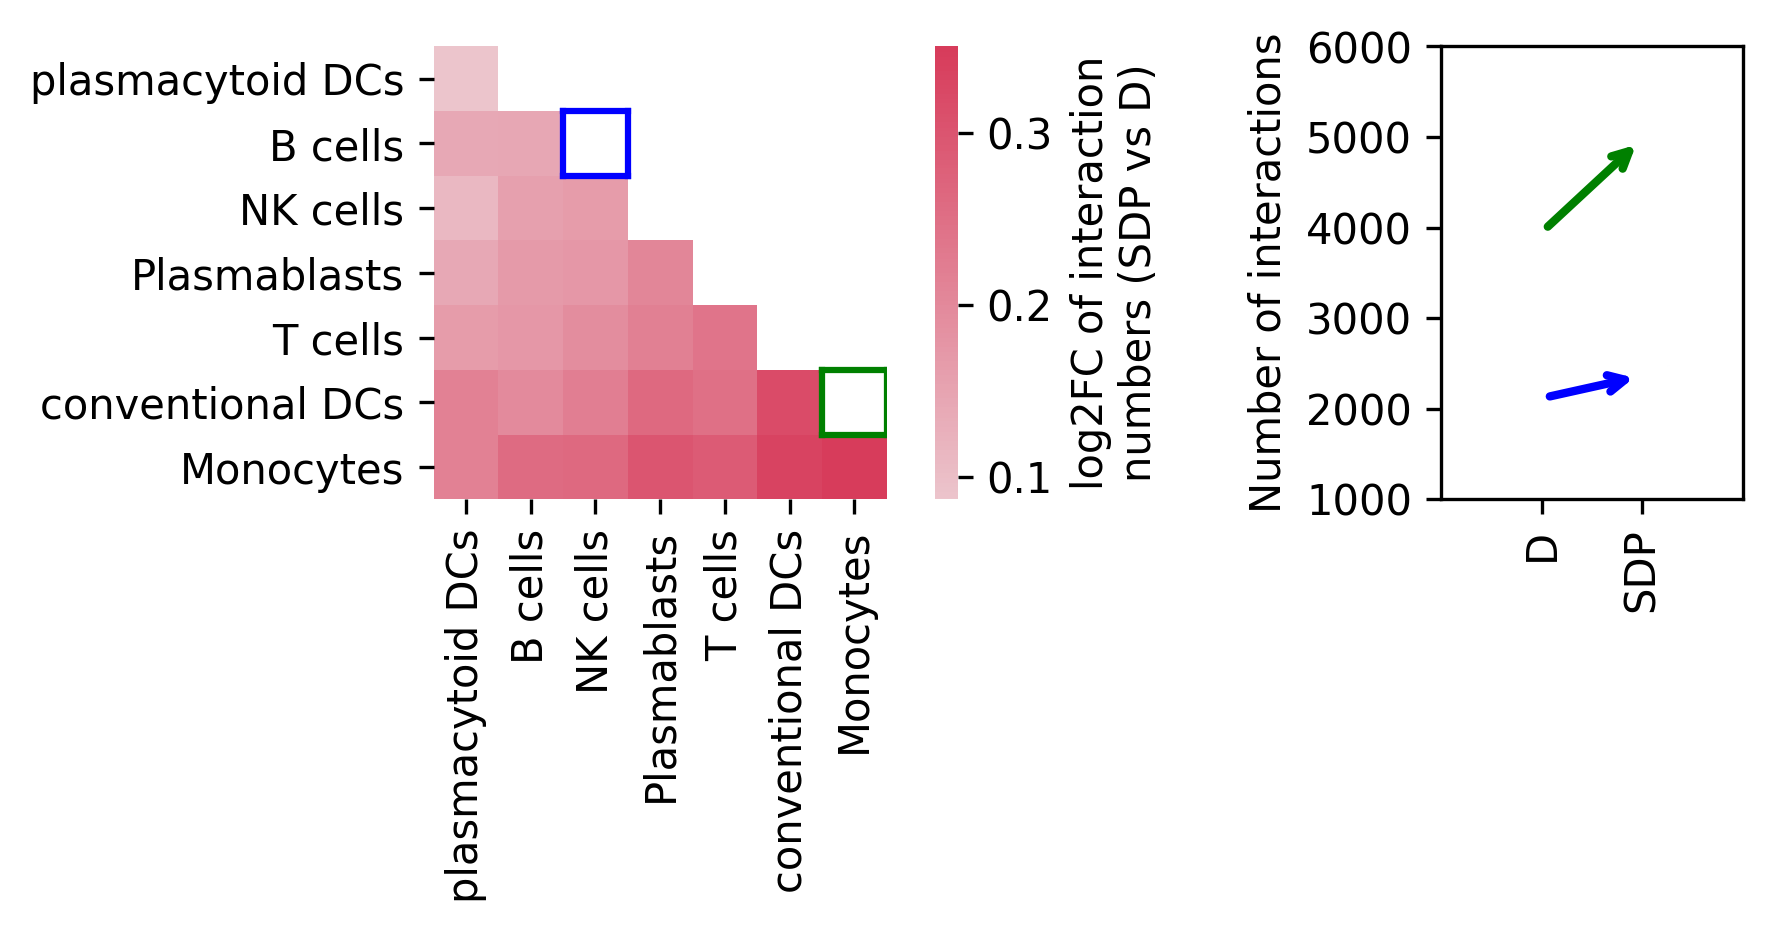

In [24]:
number_of_inters(0.02)
intern_im, it_im_new = df_log2FC_inters(0.02)
plot_log2FC_inters(it_im_new, intern_im, 0.02)

get the number of interactions at SD and D, threshold: exp frac >= 4.0%


<ipython-input-23-ed3ca8703e32>:576: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


get the heatmap showing the number of interactions at SD and D


<ipython-input-23-ed3ca8703e32>:625: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(it_im_new, dtype=np.bool)


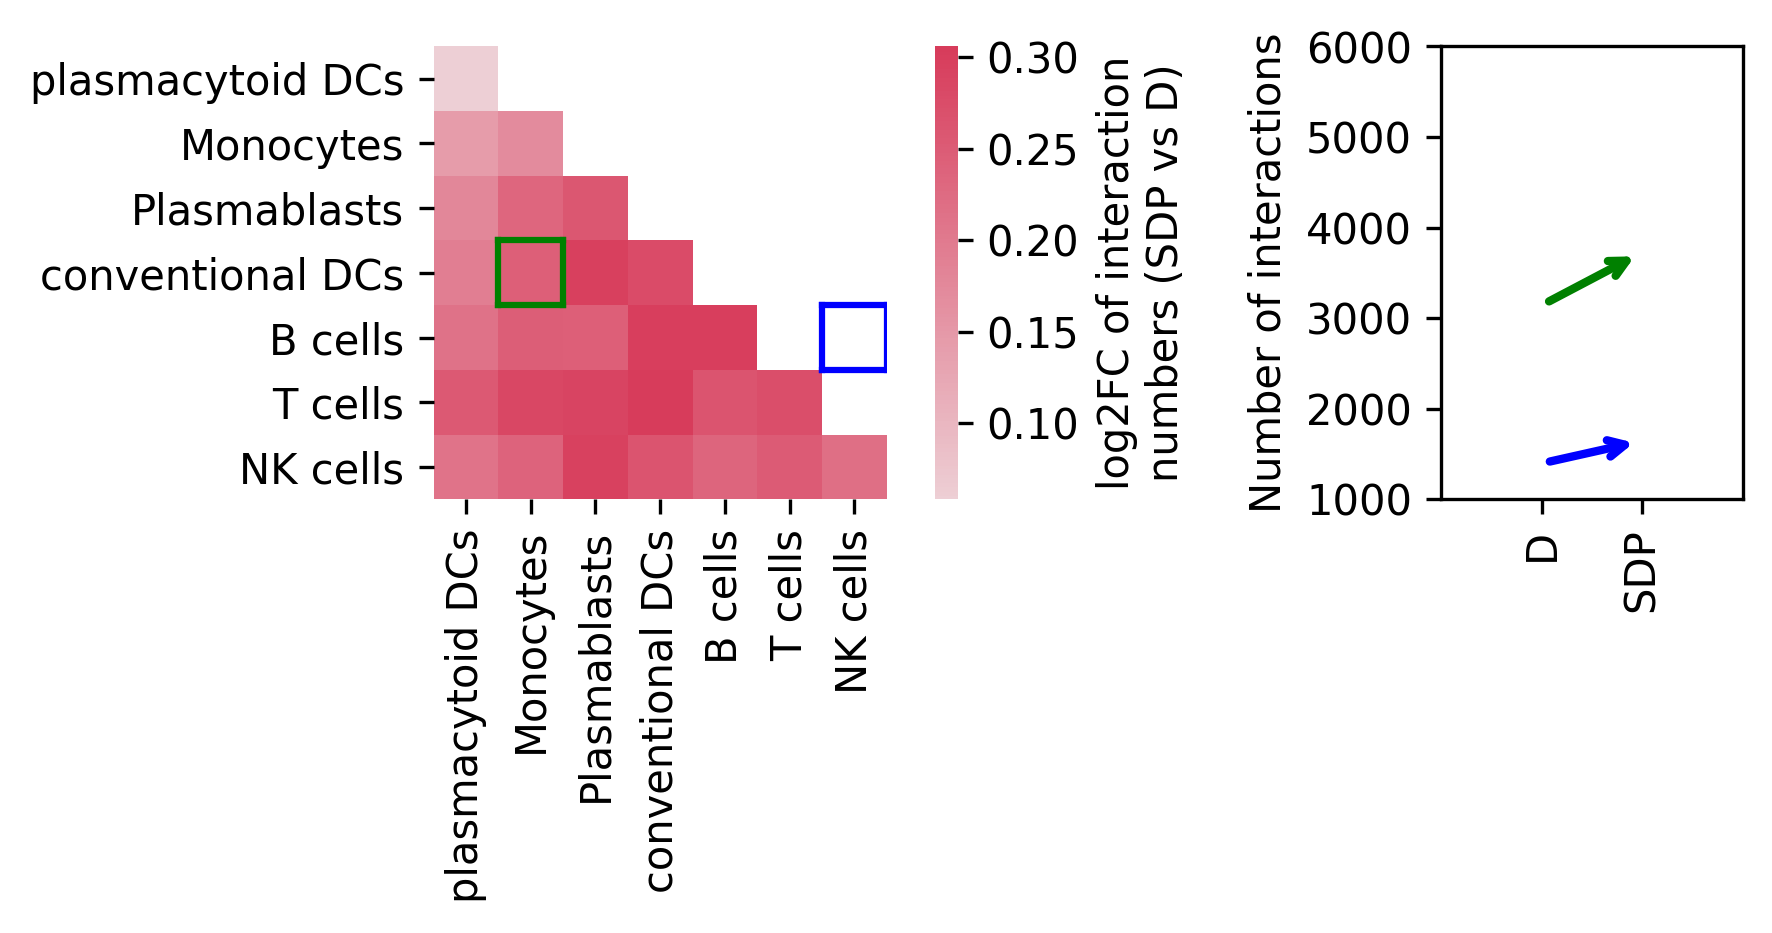

In [25]:
number_of_inters(0.04)
intern_im, it_im_new = df_log2FC_inters(0.04)
plot_log2FC_inters(it_im_new, intern_im, 0.04)

get the number of interactions at SD and D, threshold: exp frac >= 6.0%


<ipython-input-23-ed3ca8703e32>:576: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


get the heatmap showing the number of interactions at SD and D


<ipython-input-23-ed3ca8703e32>:625: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(it_im_new, dtype=np.bool)


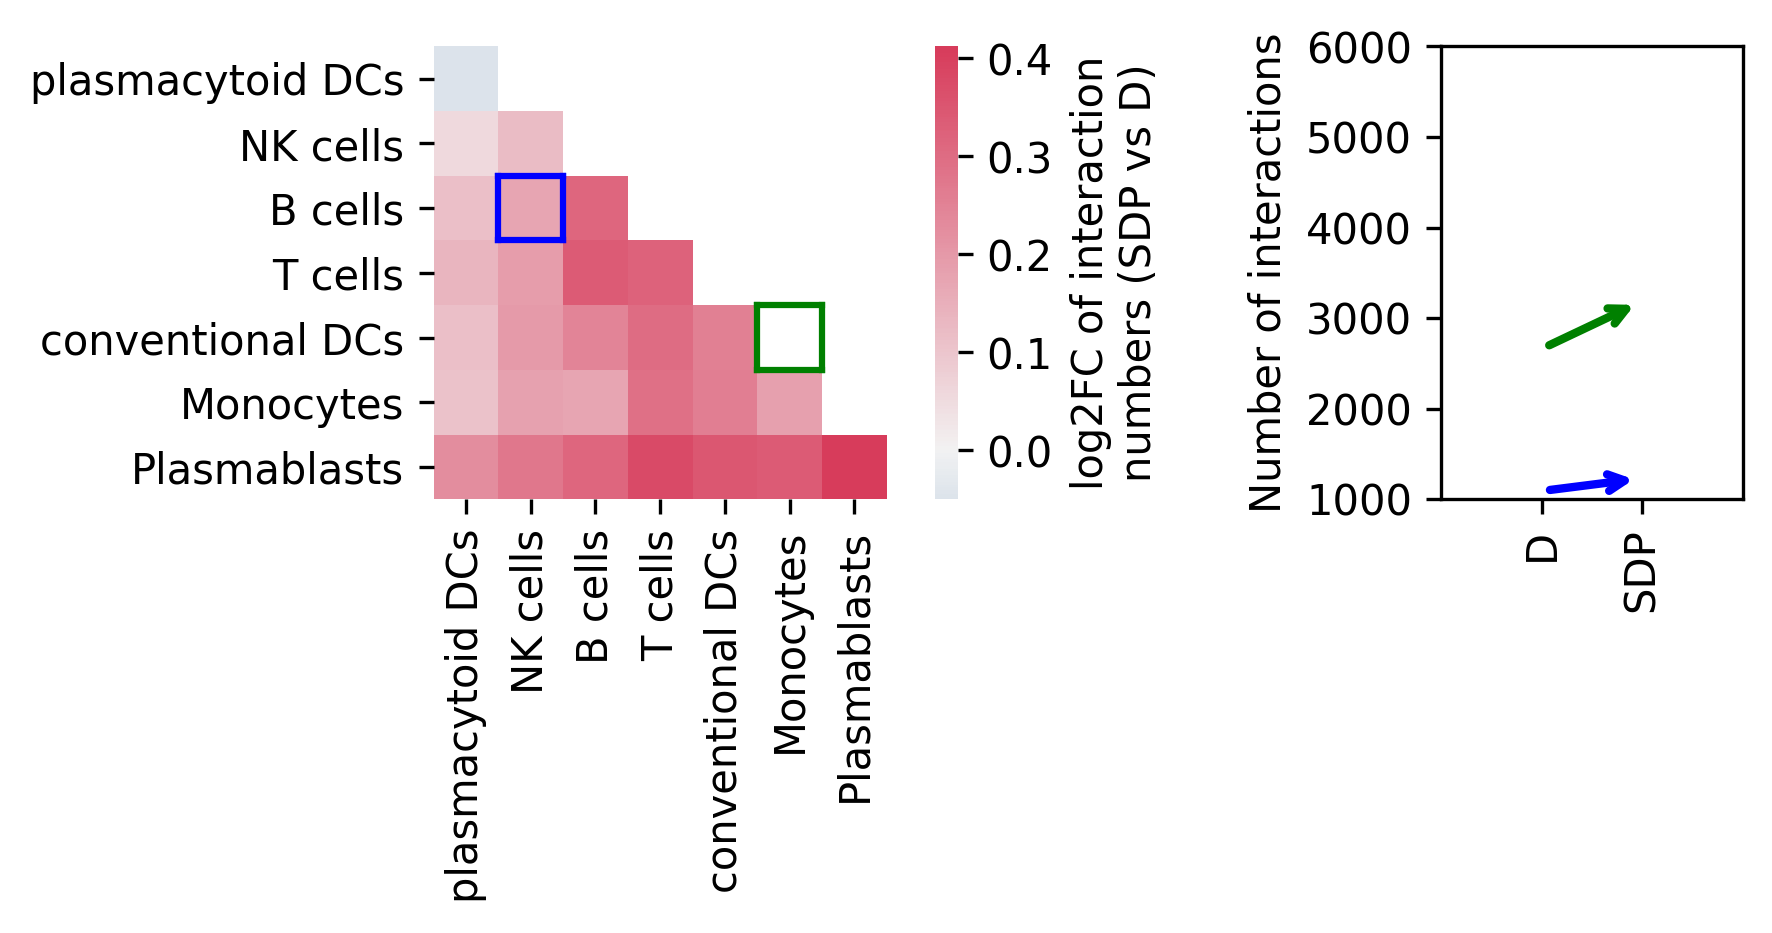

In [26]:
number_of_inters(0.06)
intern_im, it_im_new = df_log2FC_inters(0.06)
plot_log2FC_inters(it_im_new, intern_im, 0.06)

<ipython-input-23-ed3ca8703e32>:688: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0] / 1000


get the heatmap showing the number of interactions at SD and D
get colors for every square in the heatmap


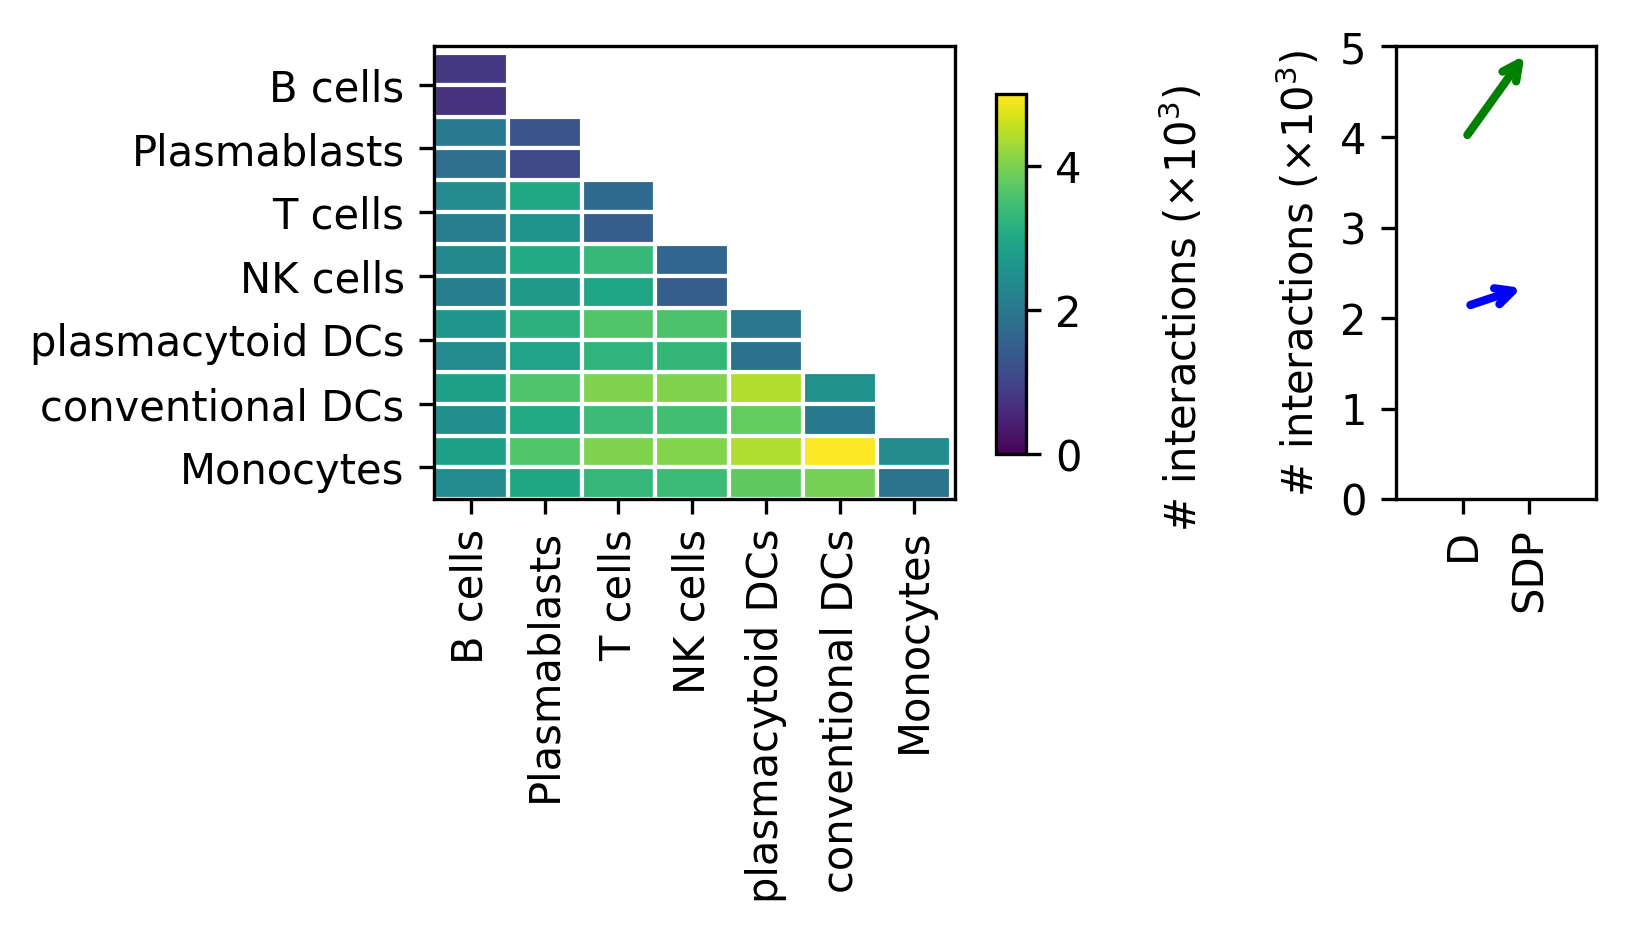

In [27]:
cts_im_op1, it_im1, intern_im1 = df_number_inters(0.02)
plot_number_inters(intern_im1, cts_im_op1, it_im1, 0.02)

<ipython-input-23-ed3ca8703e32>:688: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0] / 1000


get the heatmap showing the number of interactions at SD and D
get colors for every square in the heatmap


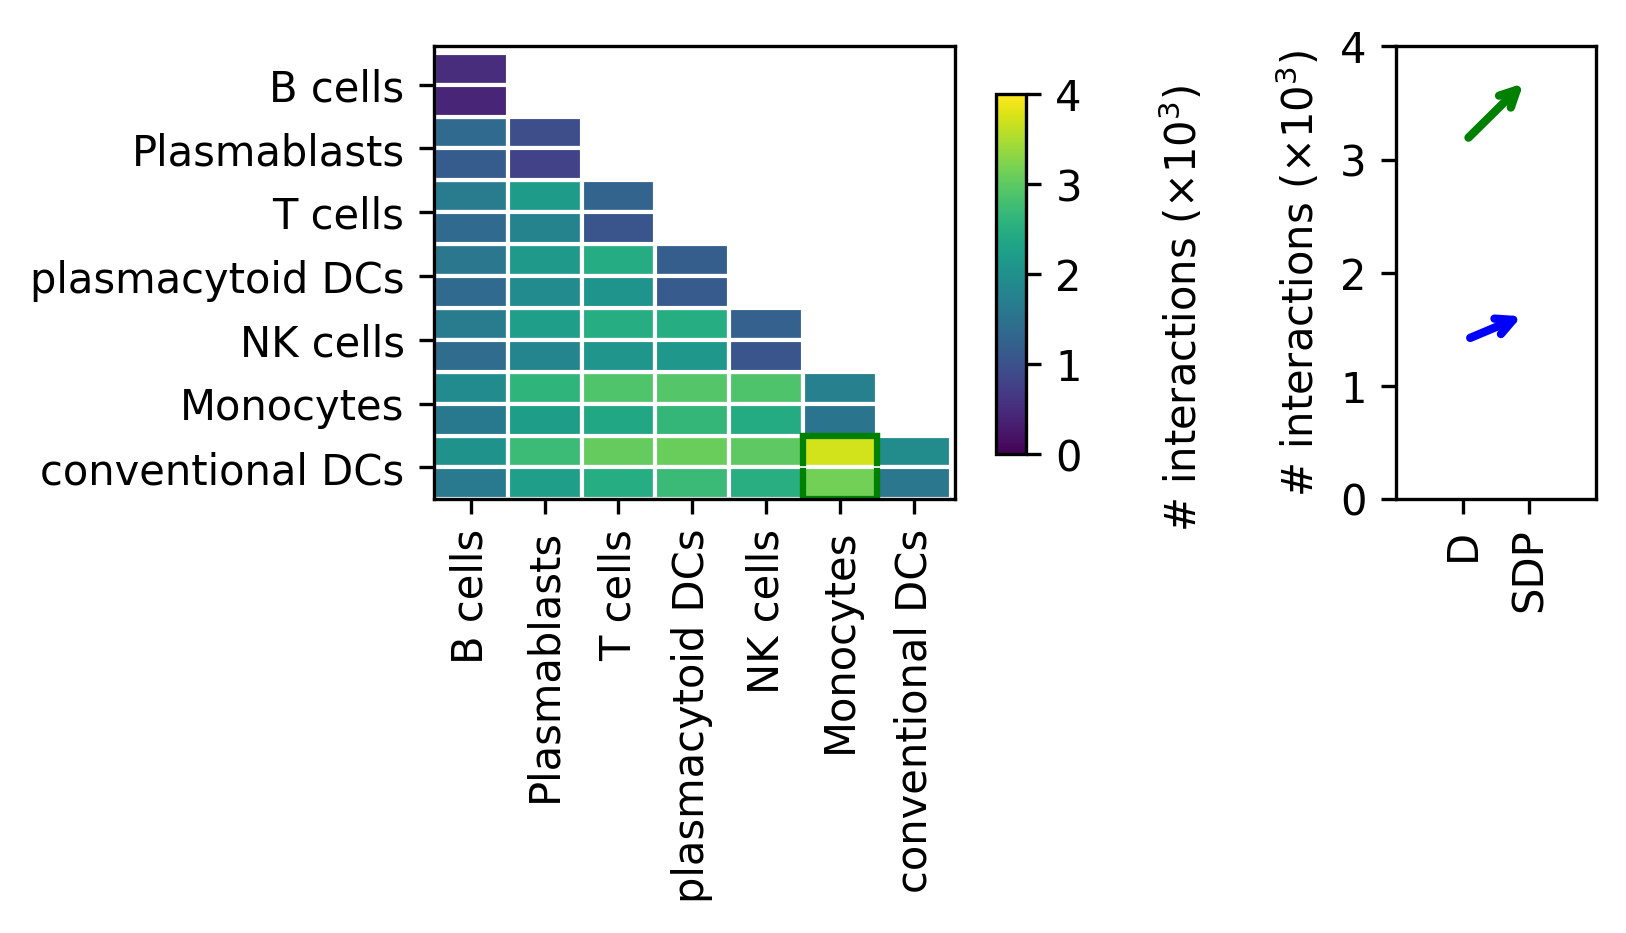

In [28]:
cts_im_op2, it_im2, intern_im2 = df_number_inters(0.04)
plot_number_inters(intern_im2, cts_im_op2, it_im2, 0.04)

<ipython-input-23-ed3ca8703e32>:688: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0] / 1000


get the heatmap showing the number of interactions at SD and D
get colors for every square in the heatmap


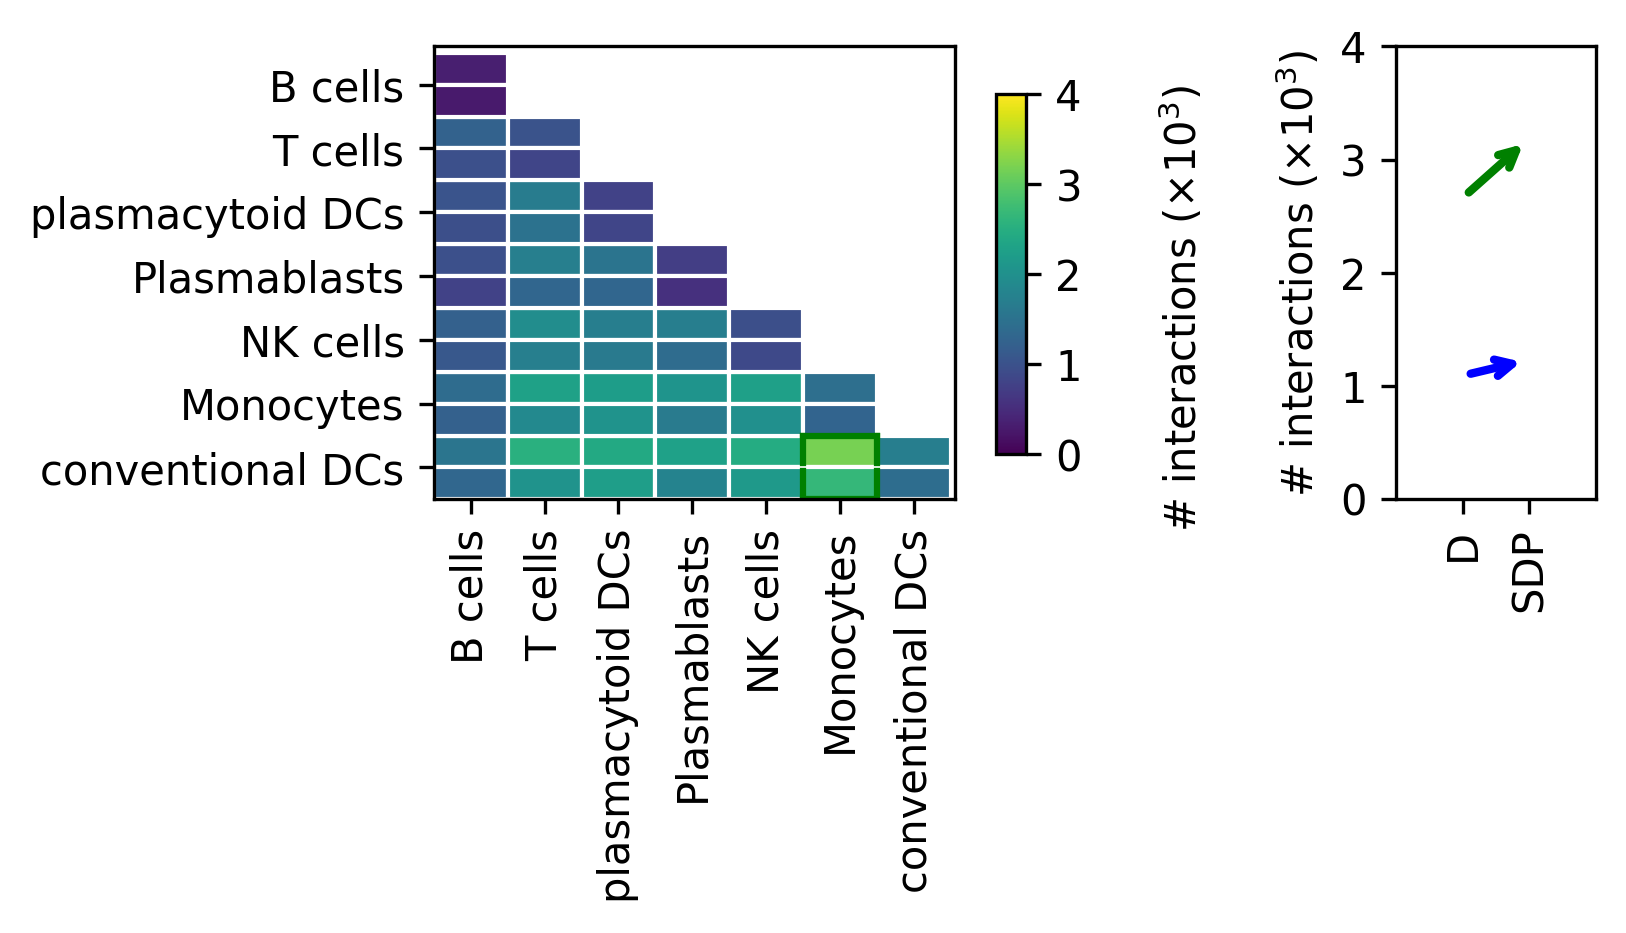

In [29]:
cts_im_op6, it_im6, intern_im6 = df_number_inters(0.06)
plot_number_inters(intern_im6, cts_im_op6, it_im6, 0.06)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


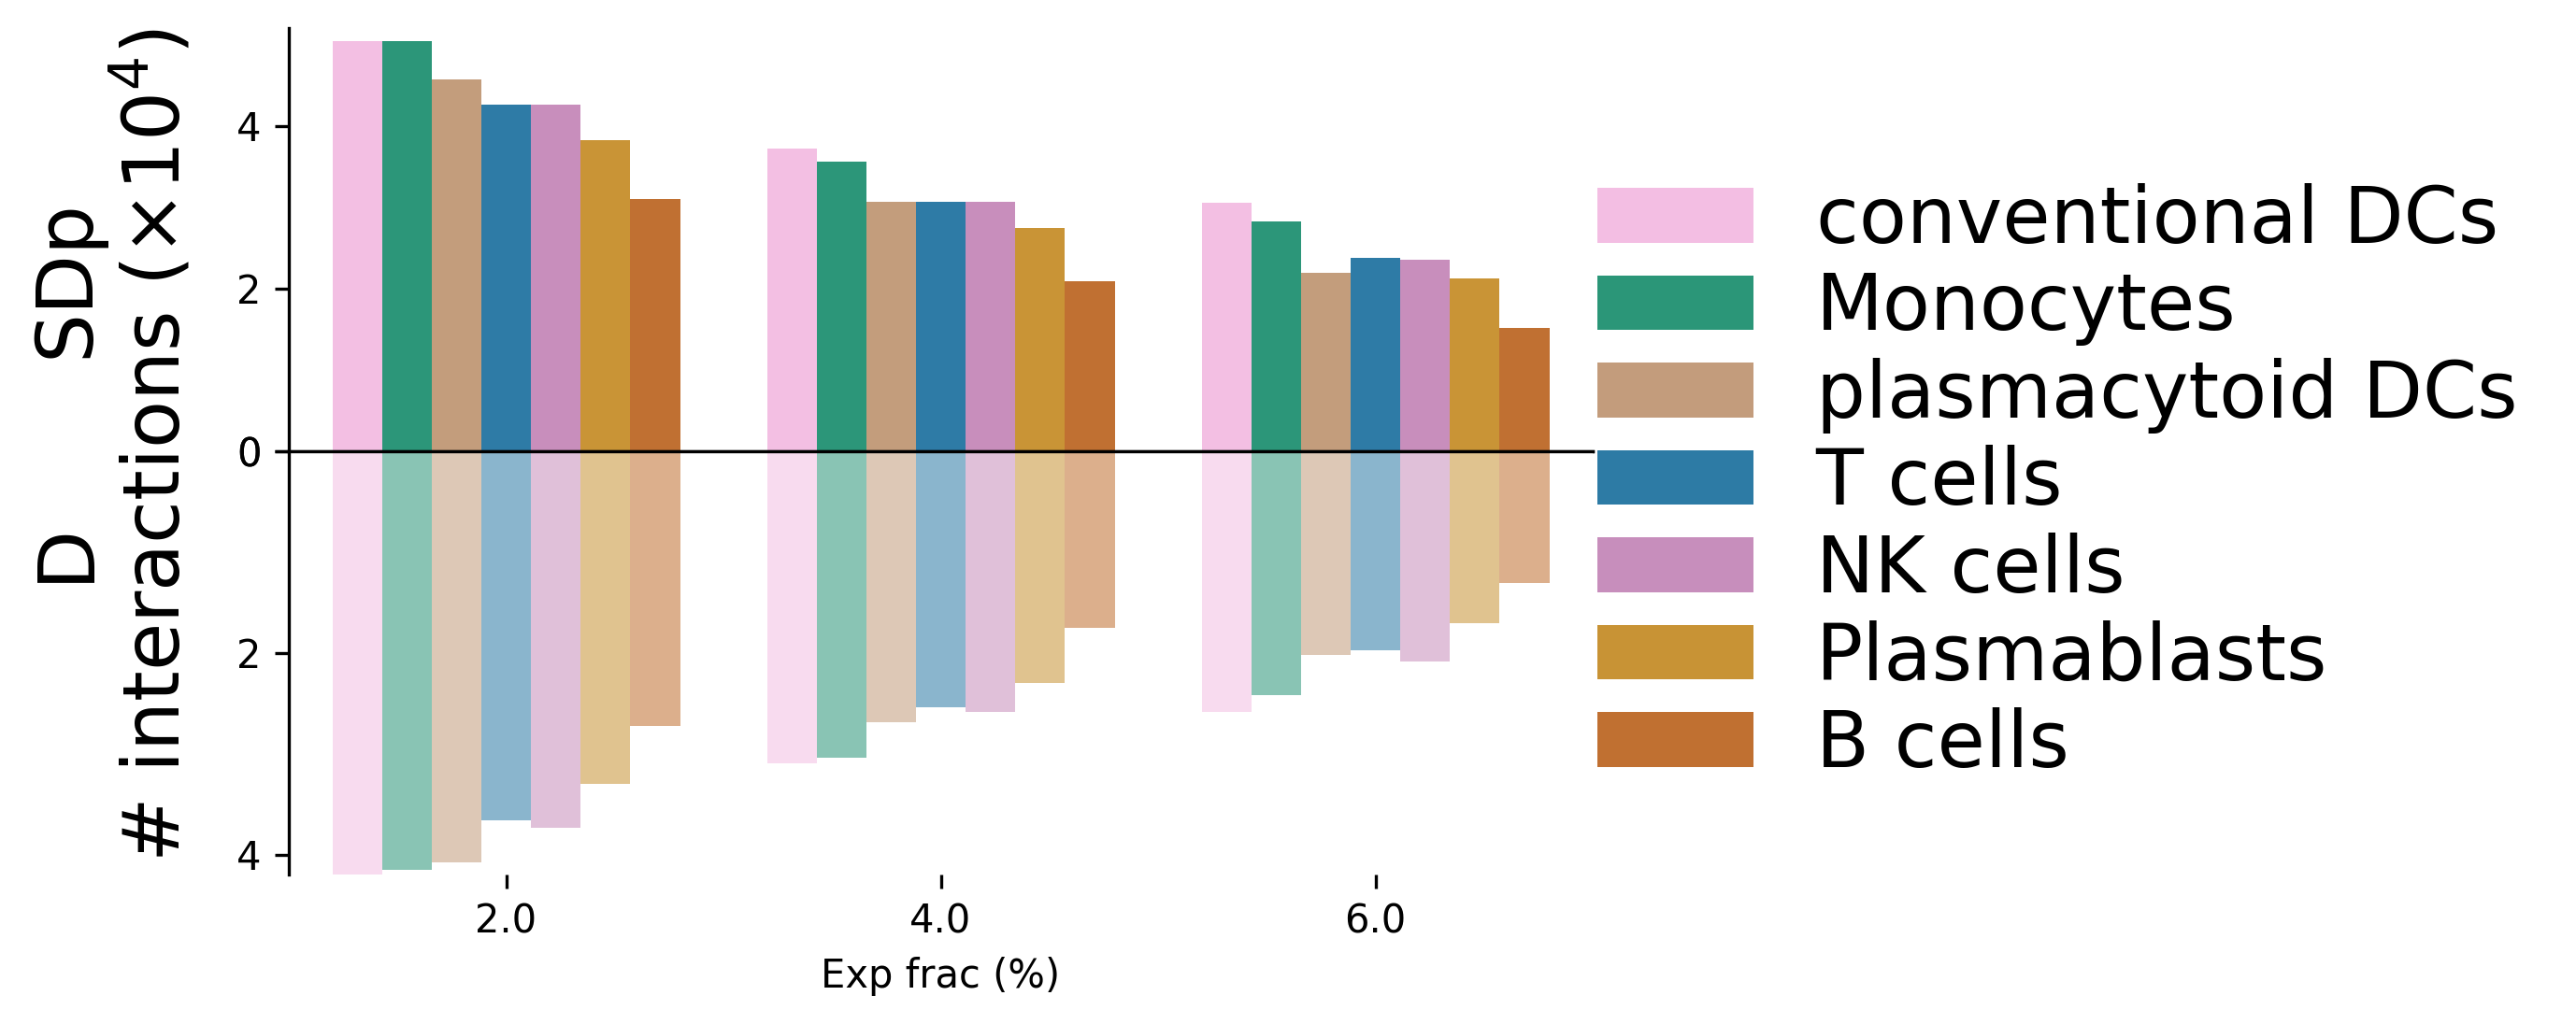

In [30]:
plot_n_fras()

# Get the ratio between number of downregulated genes and upregulated genes in each cell type

only analyzing interacting genes


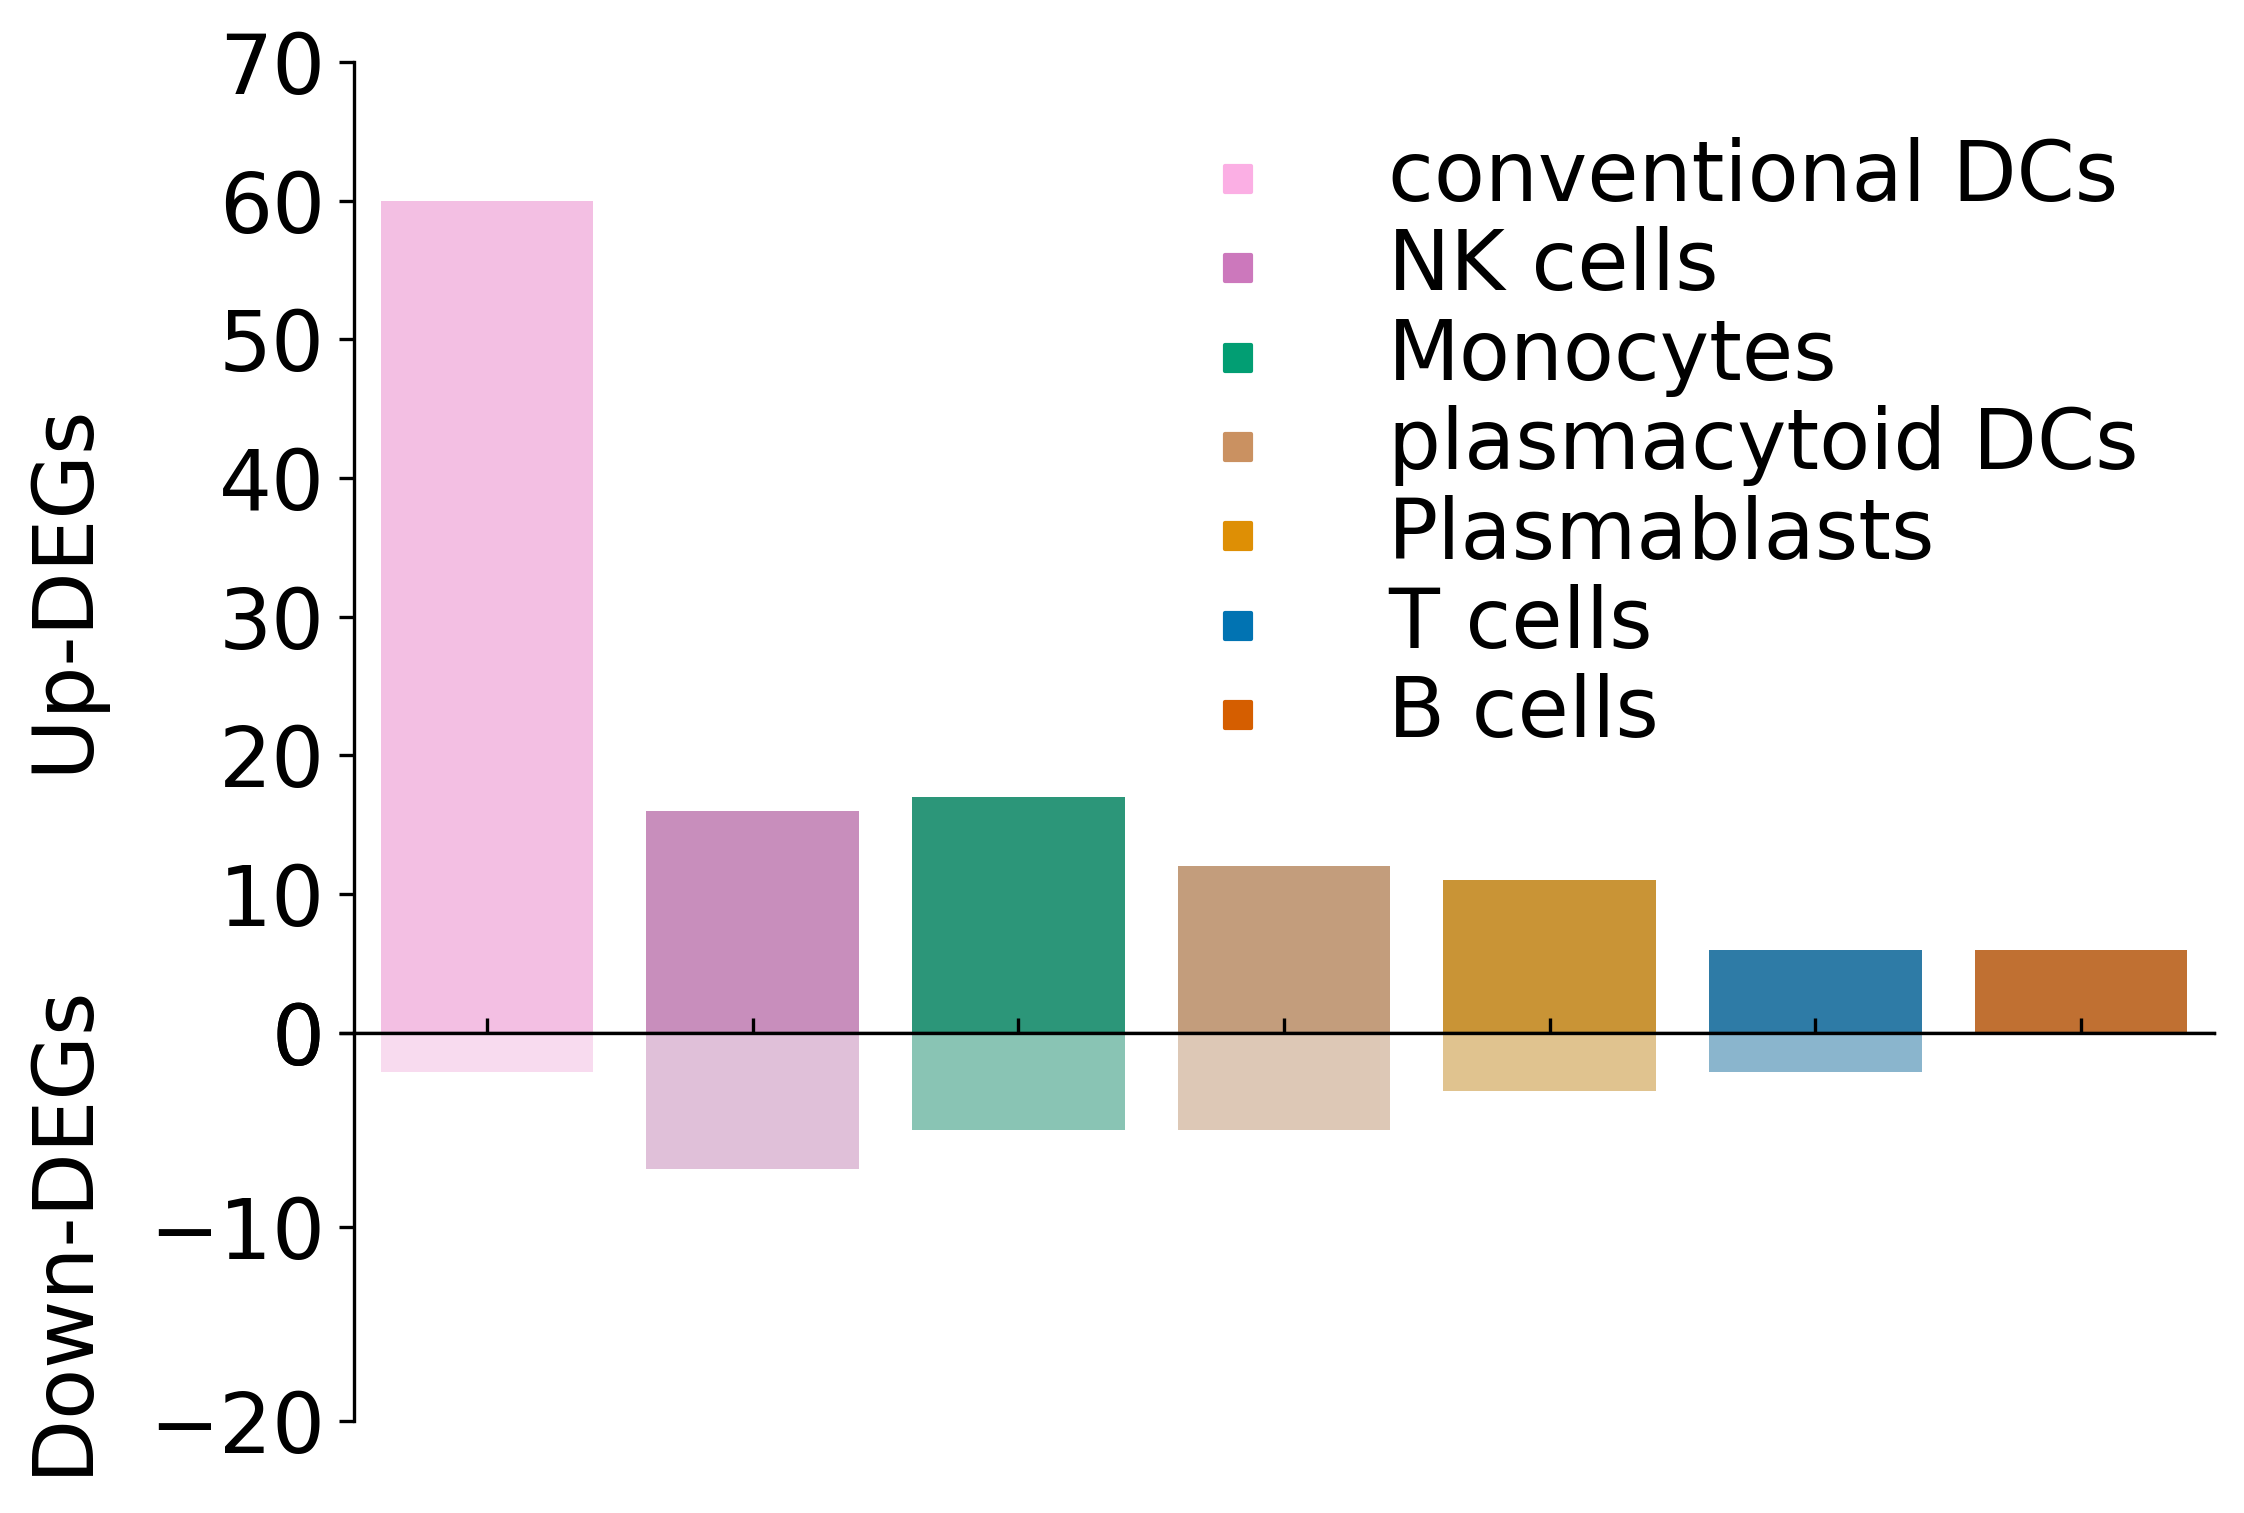

In [31]:
interacting_DEGs()

ratio of interacting DEGs vs all DEGs


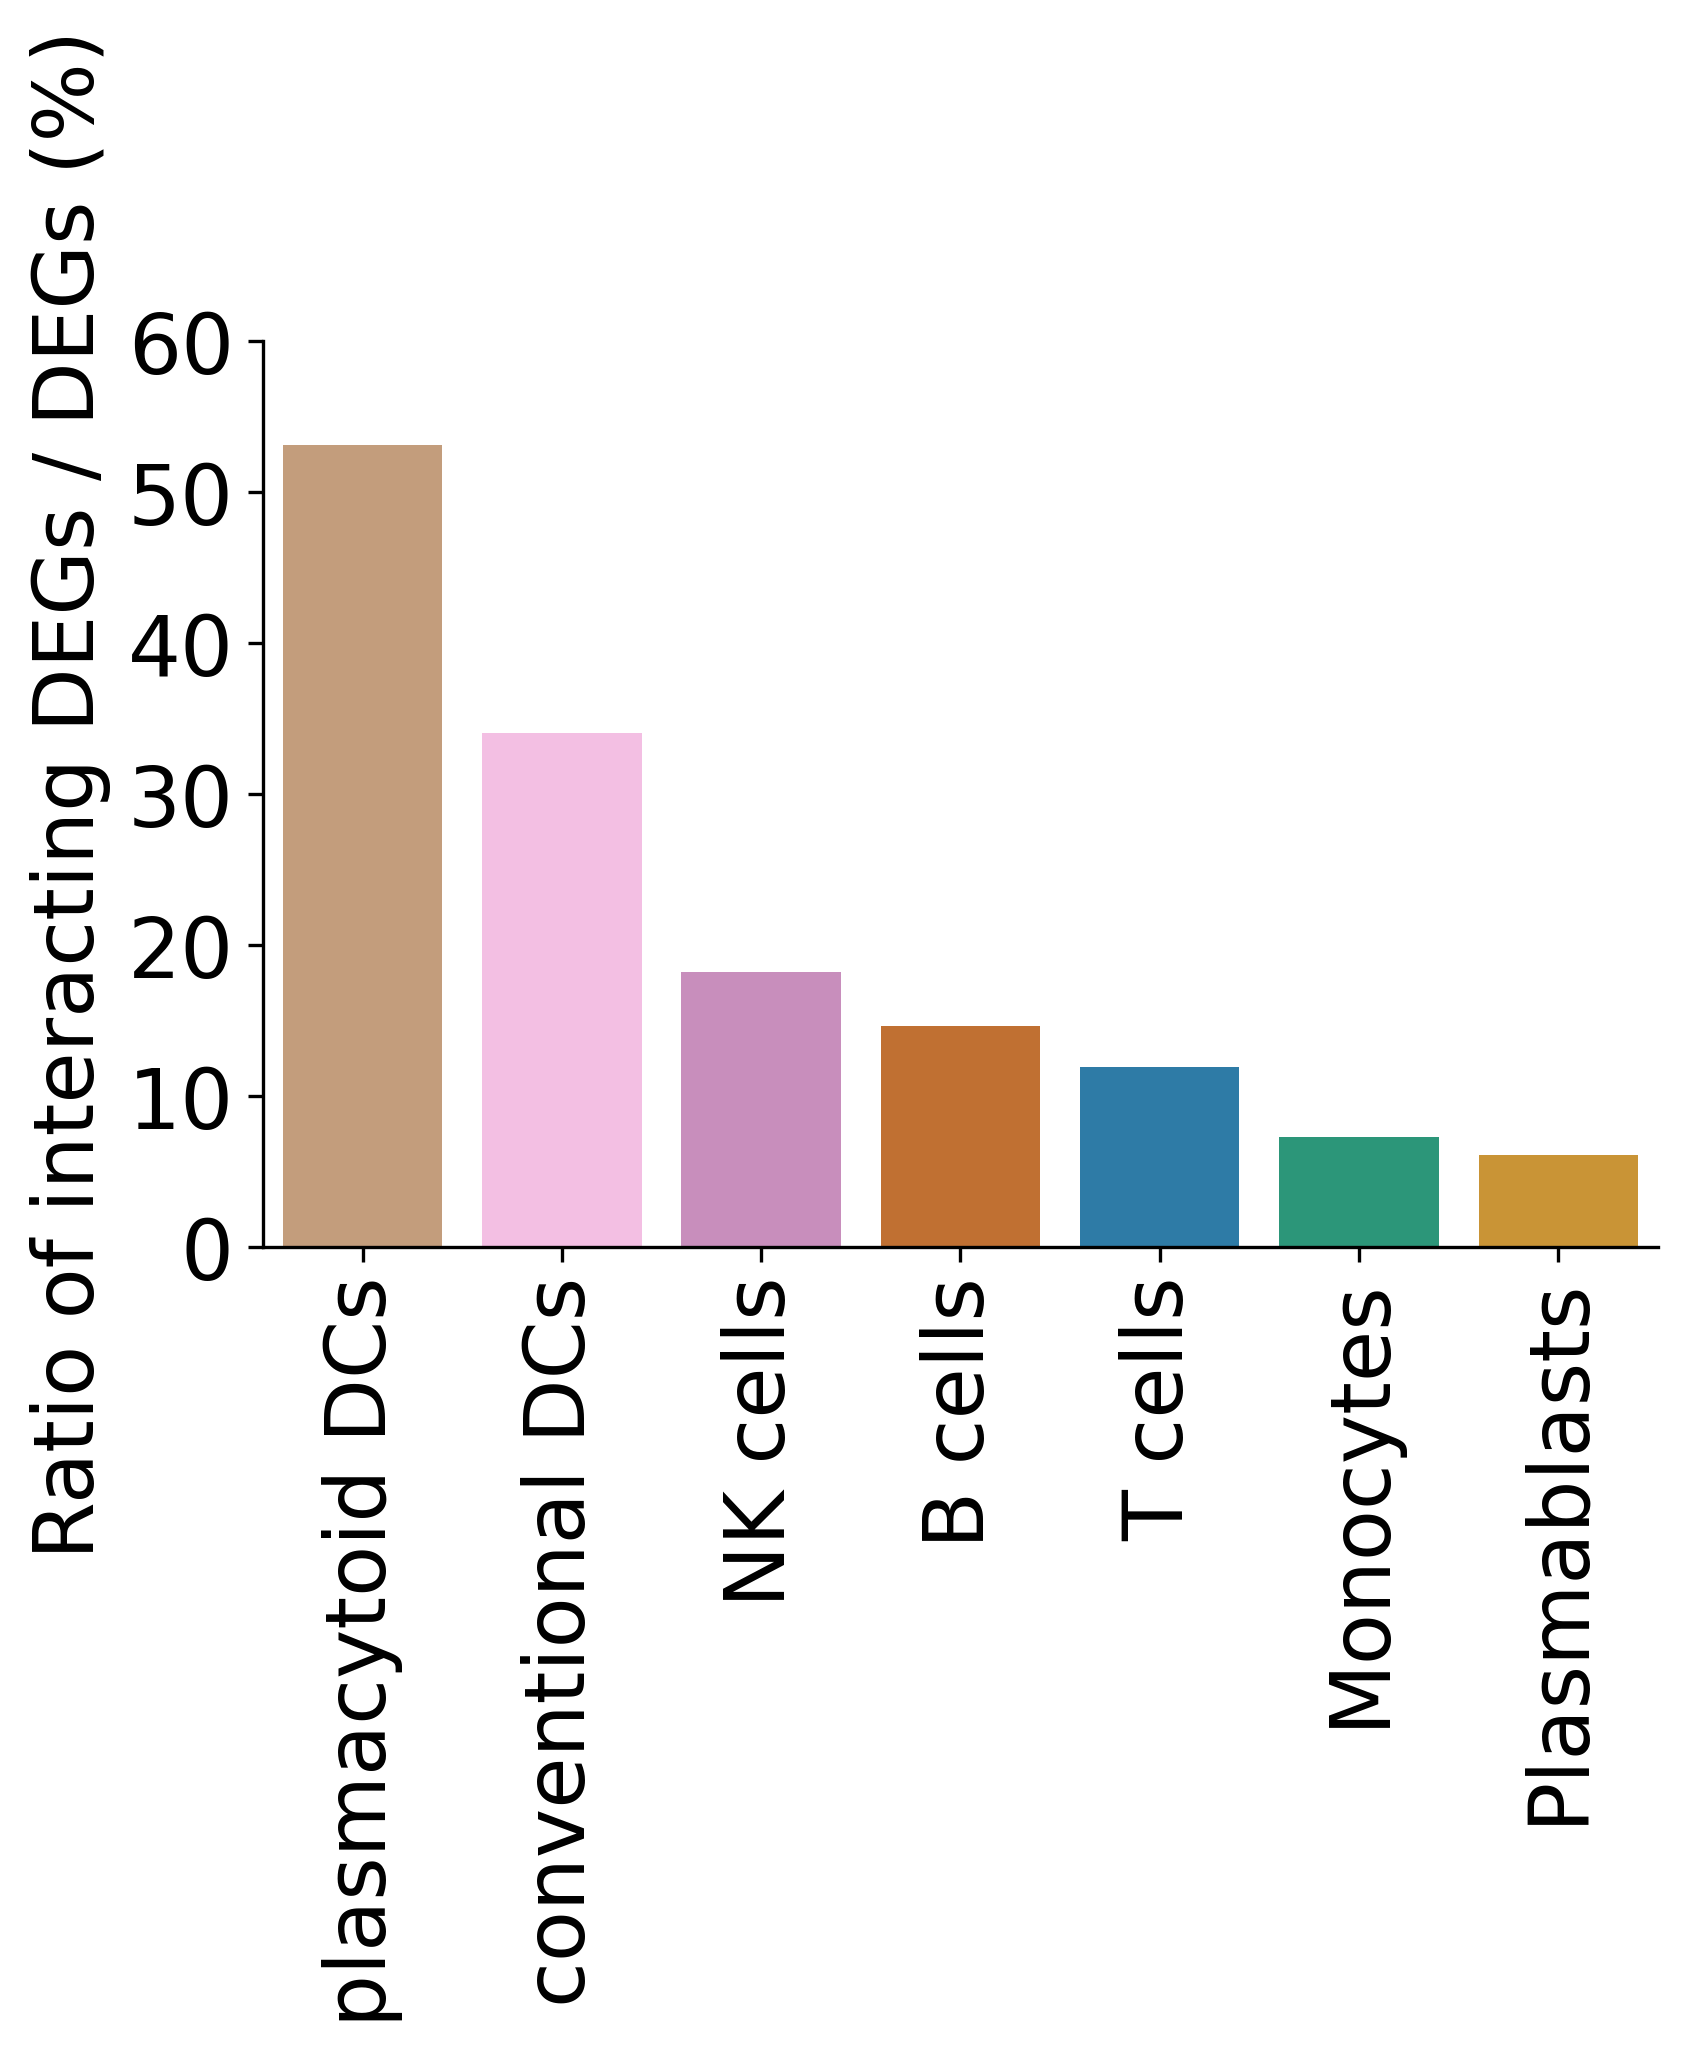

In [32]:
interacting_DEGs_ratio()

ratio of interacting DEGs vs all DEGs


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


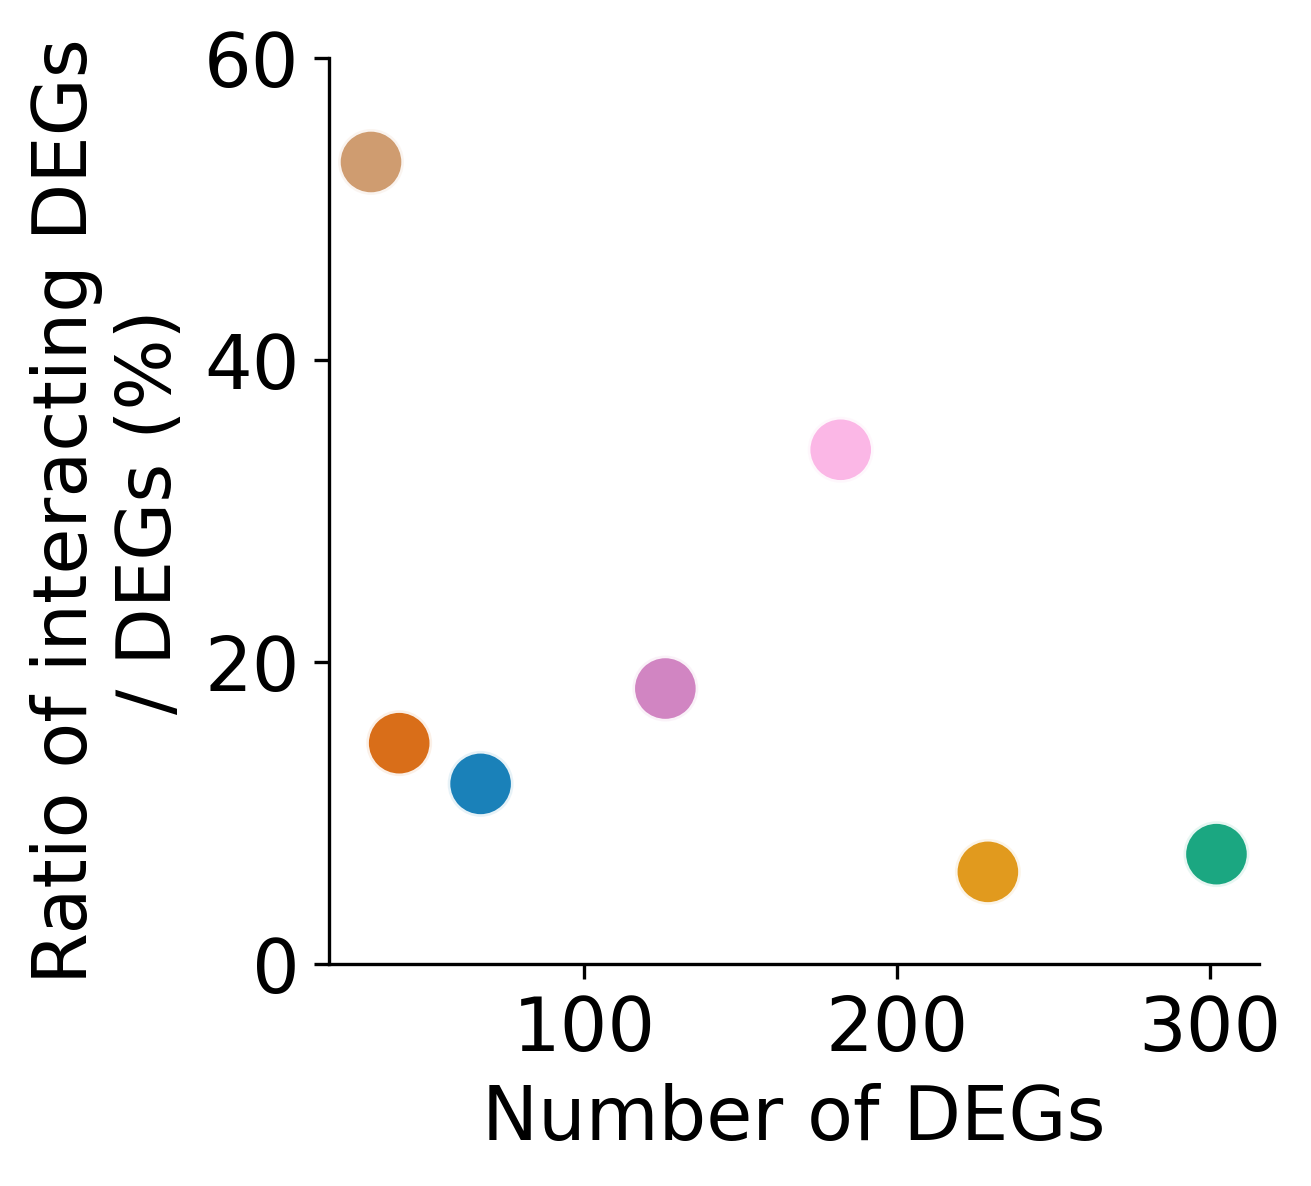

In [33]:
DEGs_ratio_correlation()

# get significant differential expressed interactions

In [34]:
up_DEGs = {}
down_DEGs = {}

cts = adata_kid.obs['cell_type_new'].unique().tolist()
if 'doublets' in cts:
    cts.remove('doublets')
if 'unknown' in cts:
    cts.remove('unknown')  
cts.remove('megakaryocytes')

for ct in cts:
    data_ct = ct_pair.loc[ct].loc[genes] ## interacting genes
    up_ct = data_ct[((data_ct['med_pair'] >= 1) & (data_ct['fra_pair'] >= 39/56) & (data_ct['S_fra'] >= 0.02))]
    up_DEGs[ct] = up_ct
    down_ct = data_ct[((data_ct['med_pair'] <= -1) & (data_ct['neg_fra_pair'] >= 39/56) & (data_ct['NS_fra'] >= 0.02))]
    down_DEGs[ct] = down_ct
    
    
ct_res_inters = get_DEIs(ct_pair, cts, up_DEGs, down_DEGs)   
ct_res_inters = ct_res_inters[~ ct_res_inters[['ga', 'csta', 'gb', 'cstb']].duplicated()]
ct_res_inters.to_csv(save_tables + 'inters_med_pair1_pair39_56_exp002.tsv', sep='\t', index=False)

ct_res_inters = get_DEIs_info(ct_pair, ct_res_inters)
ct_res_inters.to_csv(save_tables + 'inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t', index=False)


####################################################
cst_up_DEGs = {}
cst_down_DEGs = {}

csts = adata_kid.obs['cell_subtype_new'].unique().tolist()
if 'doublets' in csts:
    csts.remove('doublets')
if 'unknown' in csts:
    csts.remove('unknown')  
csts.remove('megakaryocytes')

for cst in csts:
    data_cst = cst_pair.loc[cst].loc[genes] ## interacting genes
    up_cst = data_cst[((data_cst['med_pair'] >= 1) & (data_cst['fra_pair'] >= 39/56) & (data_cst['S_fra'] >= 0.02))]
    cst_up_DEGs[cst] = up_cst
    down_cst = data_cst[((data_cst['med_pair'] <= -1) & (data_cst['neg_fra_pair'] >= 39/56) & (data_cst['NS_fra'] >= 0.02))]
    cst_down_DEGs[cst] = down_cst
    
    
cst_res_inters = get_DEIs(cst_pair, csts, cst_up_DEGs, cst_down_DEGs)   
cst_res_inters = cst_res_inters[~ cst_res_inters[['ga', 'csta', 'gb', 'cstb']].duplicated()]
cst_res_inters.to_csv(save_tables + 'cst_inters_med_pair1_pair39_56_exp002.tsv', sep='\t', index=False)

cst_res_inters = get_DEIs_info(cst_pair, cst_res_inters)
cst_res_inters.to_csv(save_tables + 'cst_inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t', index=False)

<ipython-input-34-03033f6790a4>:2: DtypeWarning: Columns (2,3,4,5,6,18,26,27,28,29,30,33,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions = pd.read_csv(fn_int, sep='\t')[['genesymbol_intercell_source', 'genesymbol_intercell_target']]
<ipython-input-23-ed3ca8703e32>:1072: DtypeWarning: Columns (2,3,4,5,6,18,26,27,28,29,30,33,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactions = pd.read_csv(fn_int, sep='\t')[['genesymbol_intercell_source', 'genesymbol_intercell_target']]


In [151]:
ct_inters = pd.read_csv(save_tables + 'inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t')
cst_inters = pd.read_csv(save_tables + 'cst_inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t')

In [138]:
# randomization test
ran_res = randomization(ct_inters, adata_kid, save_tables)
ran_res.to_csv(save_tables + 'randomization_inters.tsv', sep='\t', index=False)

# randomization test
ran_cst_res = randomization(cst_inters, adata_kid, save_tables)
ran_cst_res.to_csv(save_tables + 'randomization_cst_inters.tsv', sep='\t', index=False)

In [141]:
# filter randomization test
ran_res = pd.read_csv(save_tables + 'randomization_inters.tsv', 
                      sep='\t', index_col=['ga', 'cta', 'gb', 'ctb'])
ran_res = ran_res.sort_index()
r_genes = [{'ga': ga, 'cta': cta, 'gb': gb, 'ctb': ctb} for ga, cta, gb, ctb in zip(ct_inters['ga'].tolist(), 
                                                                                    ct_inters['csta'].tolist(), 
                                                                                    ct_inters['gb'].tolist(), 
                                                                                    ct_inters['cstb'].tolist())]

ran_ct_filter = ran_filter(ran_res, r_genes)

########################
inters = pd.read_csv(save_tables + 'inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t')
ran_ct_filter.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
inters.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
res = inters.loc[ran_ct_filter.index]
res = res[~res.duplicated()]
res.to_csv(save_tables + 'sig_ct_inters.tsv', sep='\t')

In [160]:
# filter randomization test
ran_cst_res = pd.read_csv(save_tables + 'randomization_cst_inters.tsv', 
                      sep='\t', index_col=['ga', 'cta', 'gb', 'ctb'])
ran_cst_res = ran_cst_res.sort_index()
cst_r_genes = [{'ga': ga, 'cta': cta, 'gb': gb, 'ctb': ctb} for ga, cta, gb, ctb in zip(cst_inters['ga'].tolist(), 
                                                                                    cst_inters['csta'].tolist(), 
                                                                                    cst_inters['gb'].tolist(), 
                                                                                    cst_inters['cstb'].tolist())]
ran_cst_filter = ran_filter(ran_cst_res, cst_r_genes)

###################################
cst_inters = pd.read_csv(save_tables + 'cst_inters_med_pair1_pair39_56_exp002_full.tsv', sep='\t')
ran_cst_filter.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
cst_inters.set_index(['ga', 'csta', 'gb', 'cstb'], inplace=True)
cst_res = cst_inters.loc[ran_cst_filter.index]
cst_res = cst_res[~cst_res.duplicated()]
cst_res.to_csv(save_tables + 'sig_cst_inters.tsv', sep='\t')

# Ramdomization and violinplot

<ipython-input-177-93ca83dd6b13>:151: PerformanceWarning: indexing past lexsort depth may impact performance.
  log2fc = ran_res.loc[ga, cta, gb, ctb]
<ipython-input-177-93ca83dd6b13>:169: PerformanceWarning: indexing past lexsort depth may impact performance.
  p = ran_res.loc[ga, cta, gb, ctb]['pvalue'][0]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future ve

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


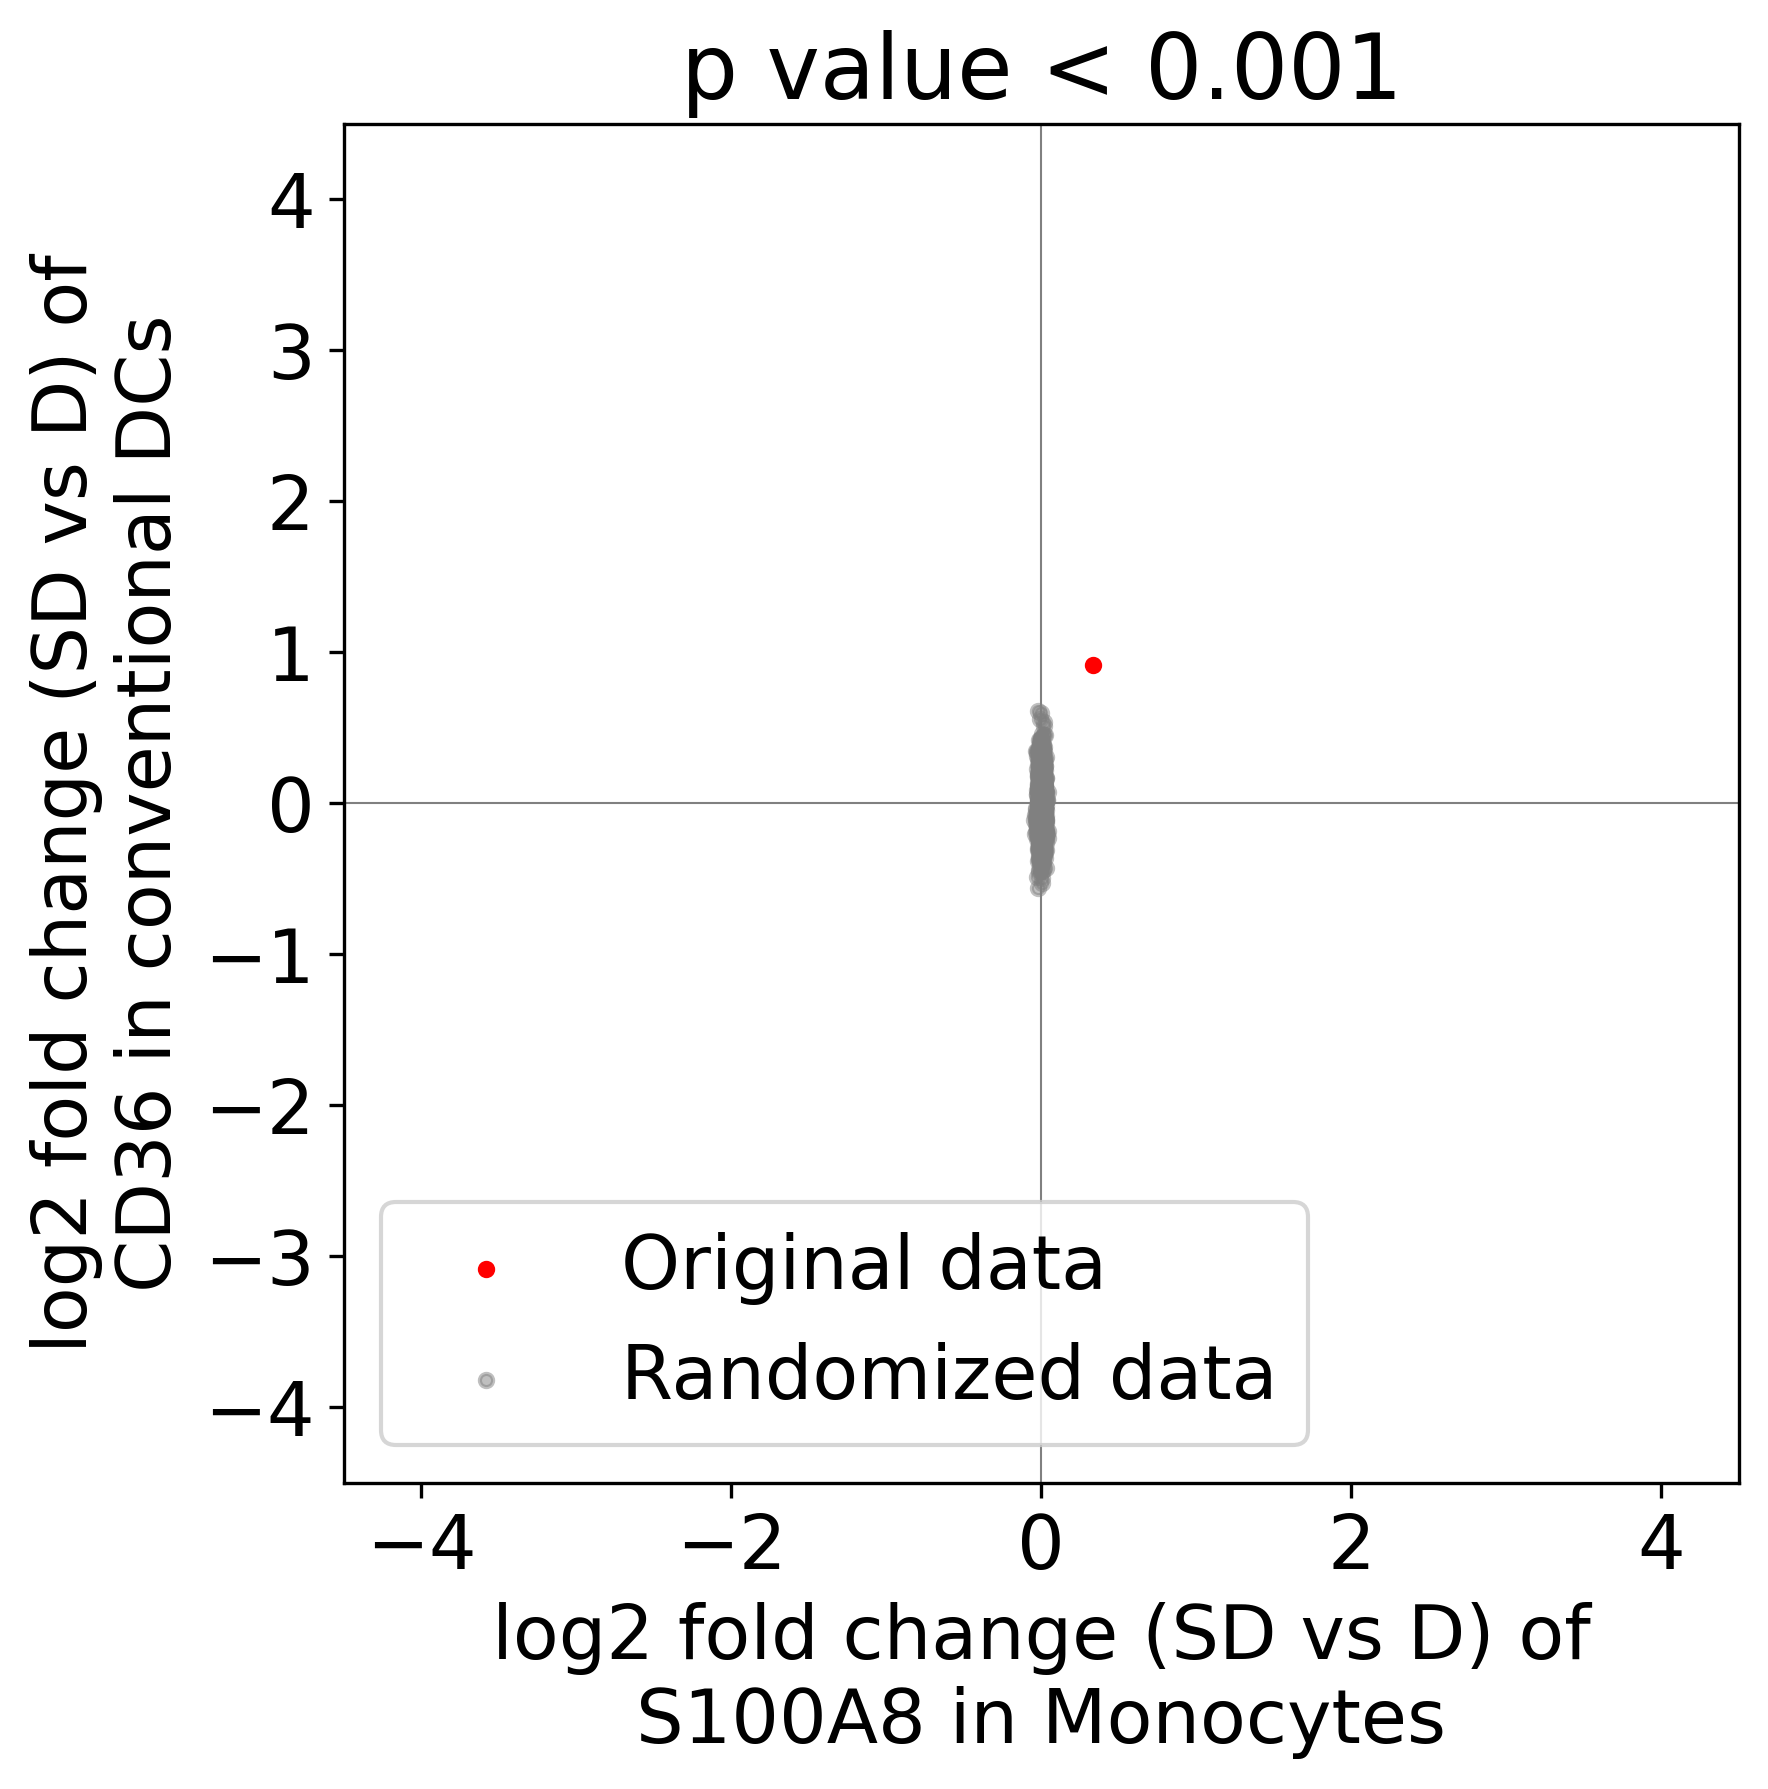

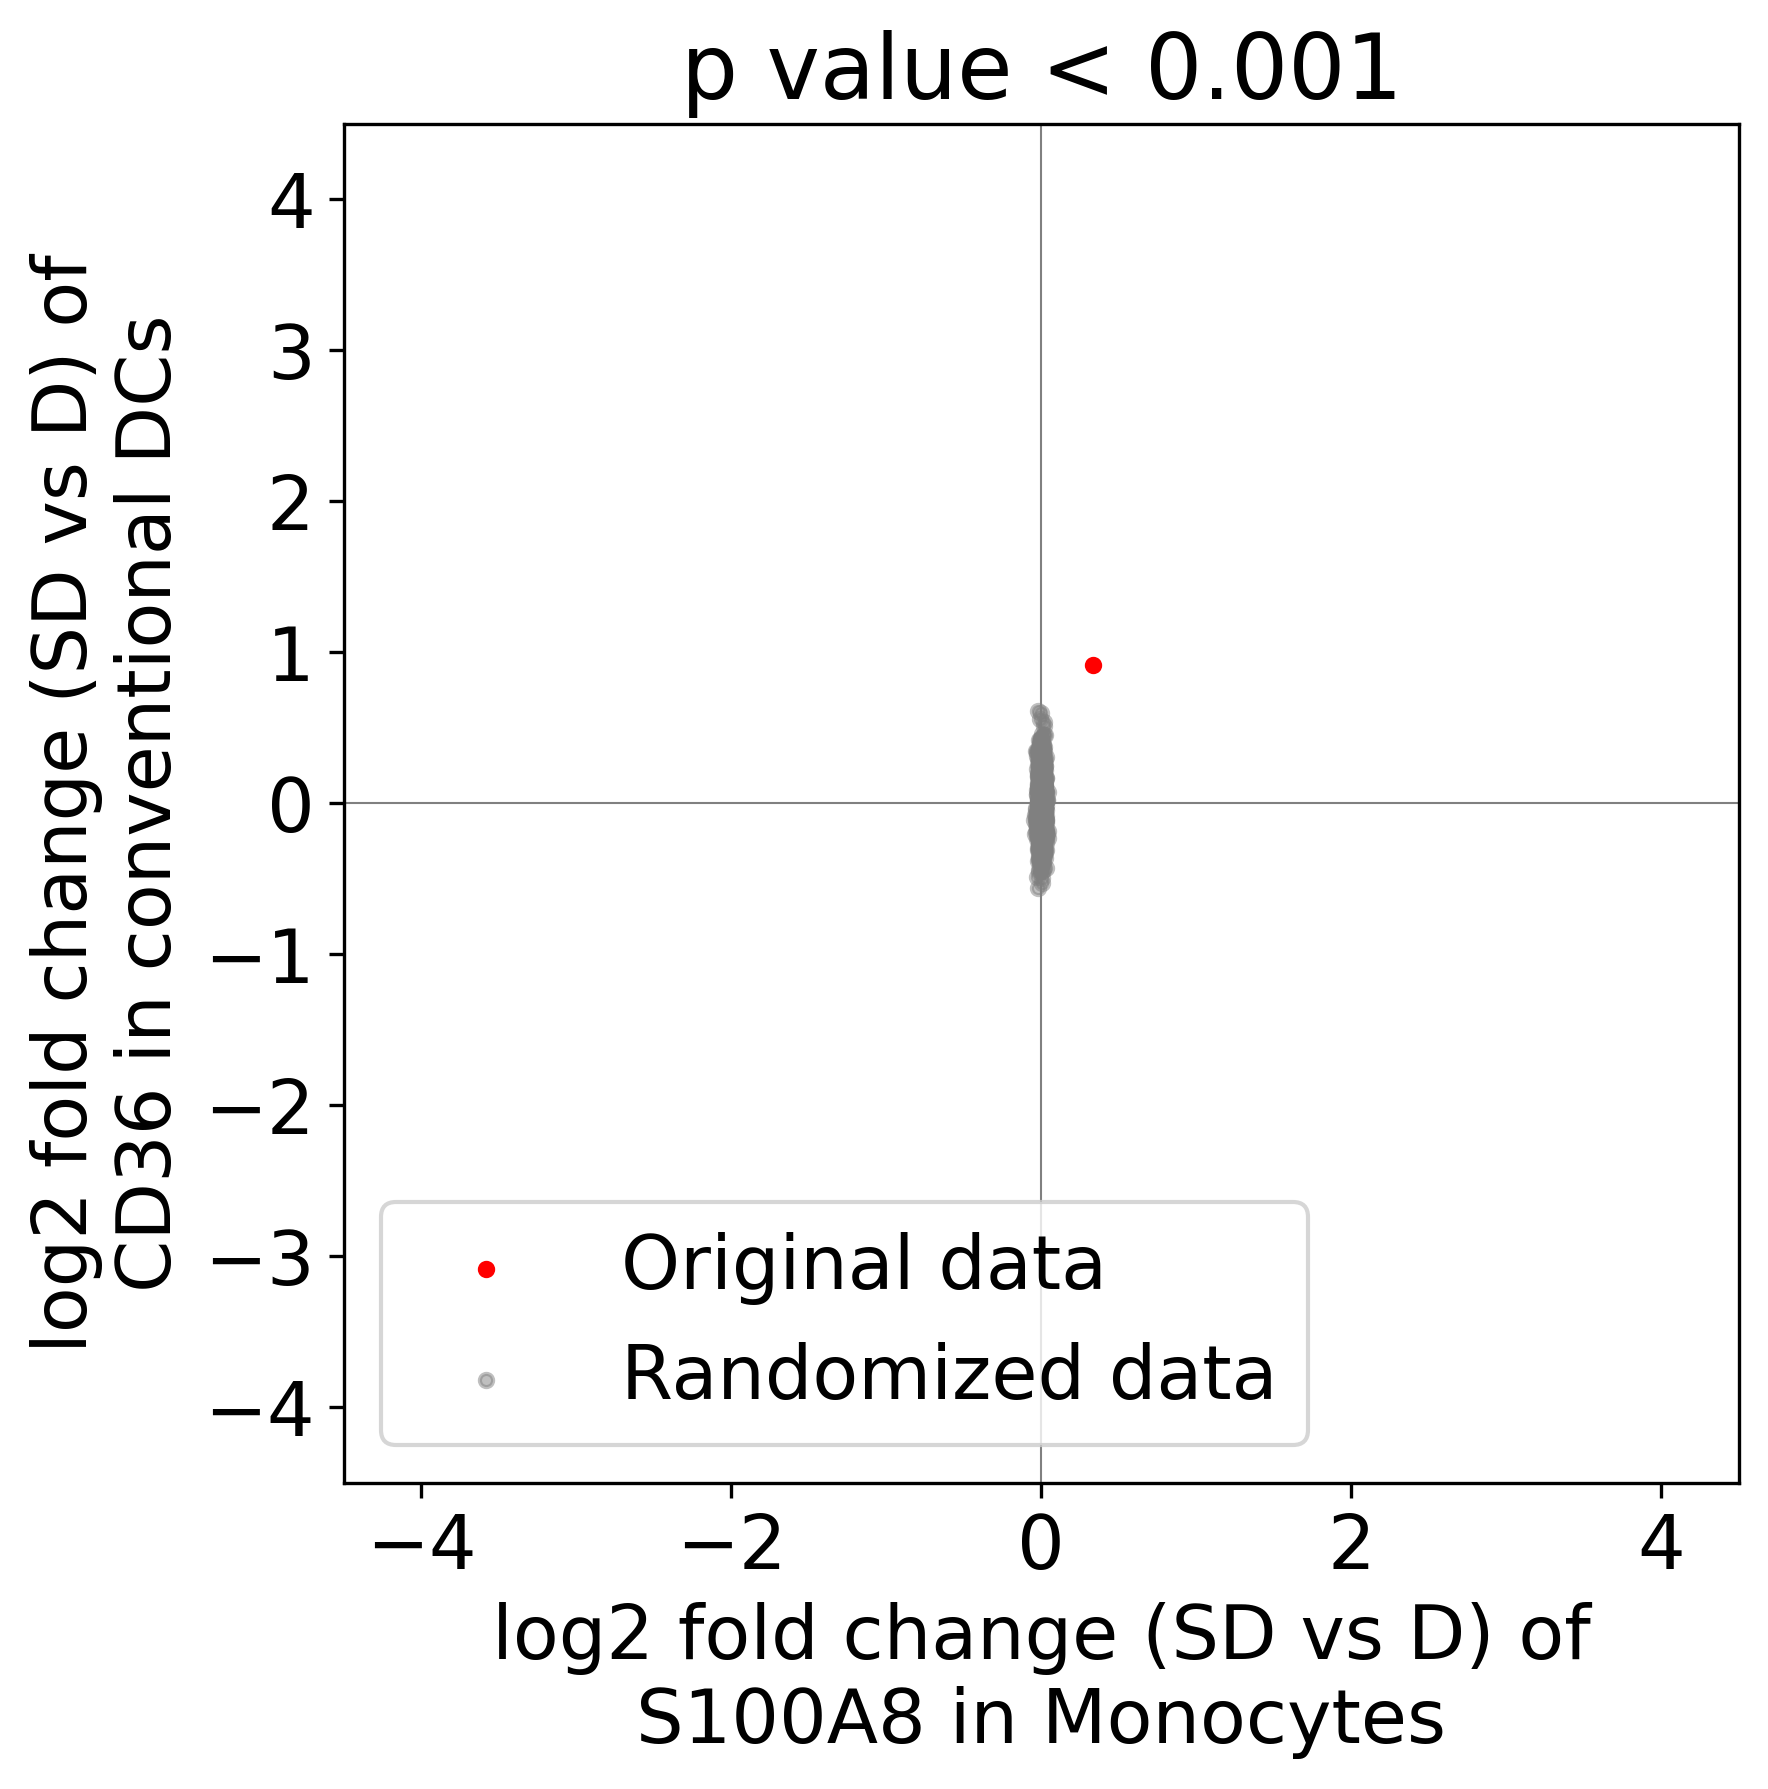

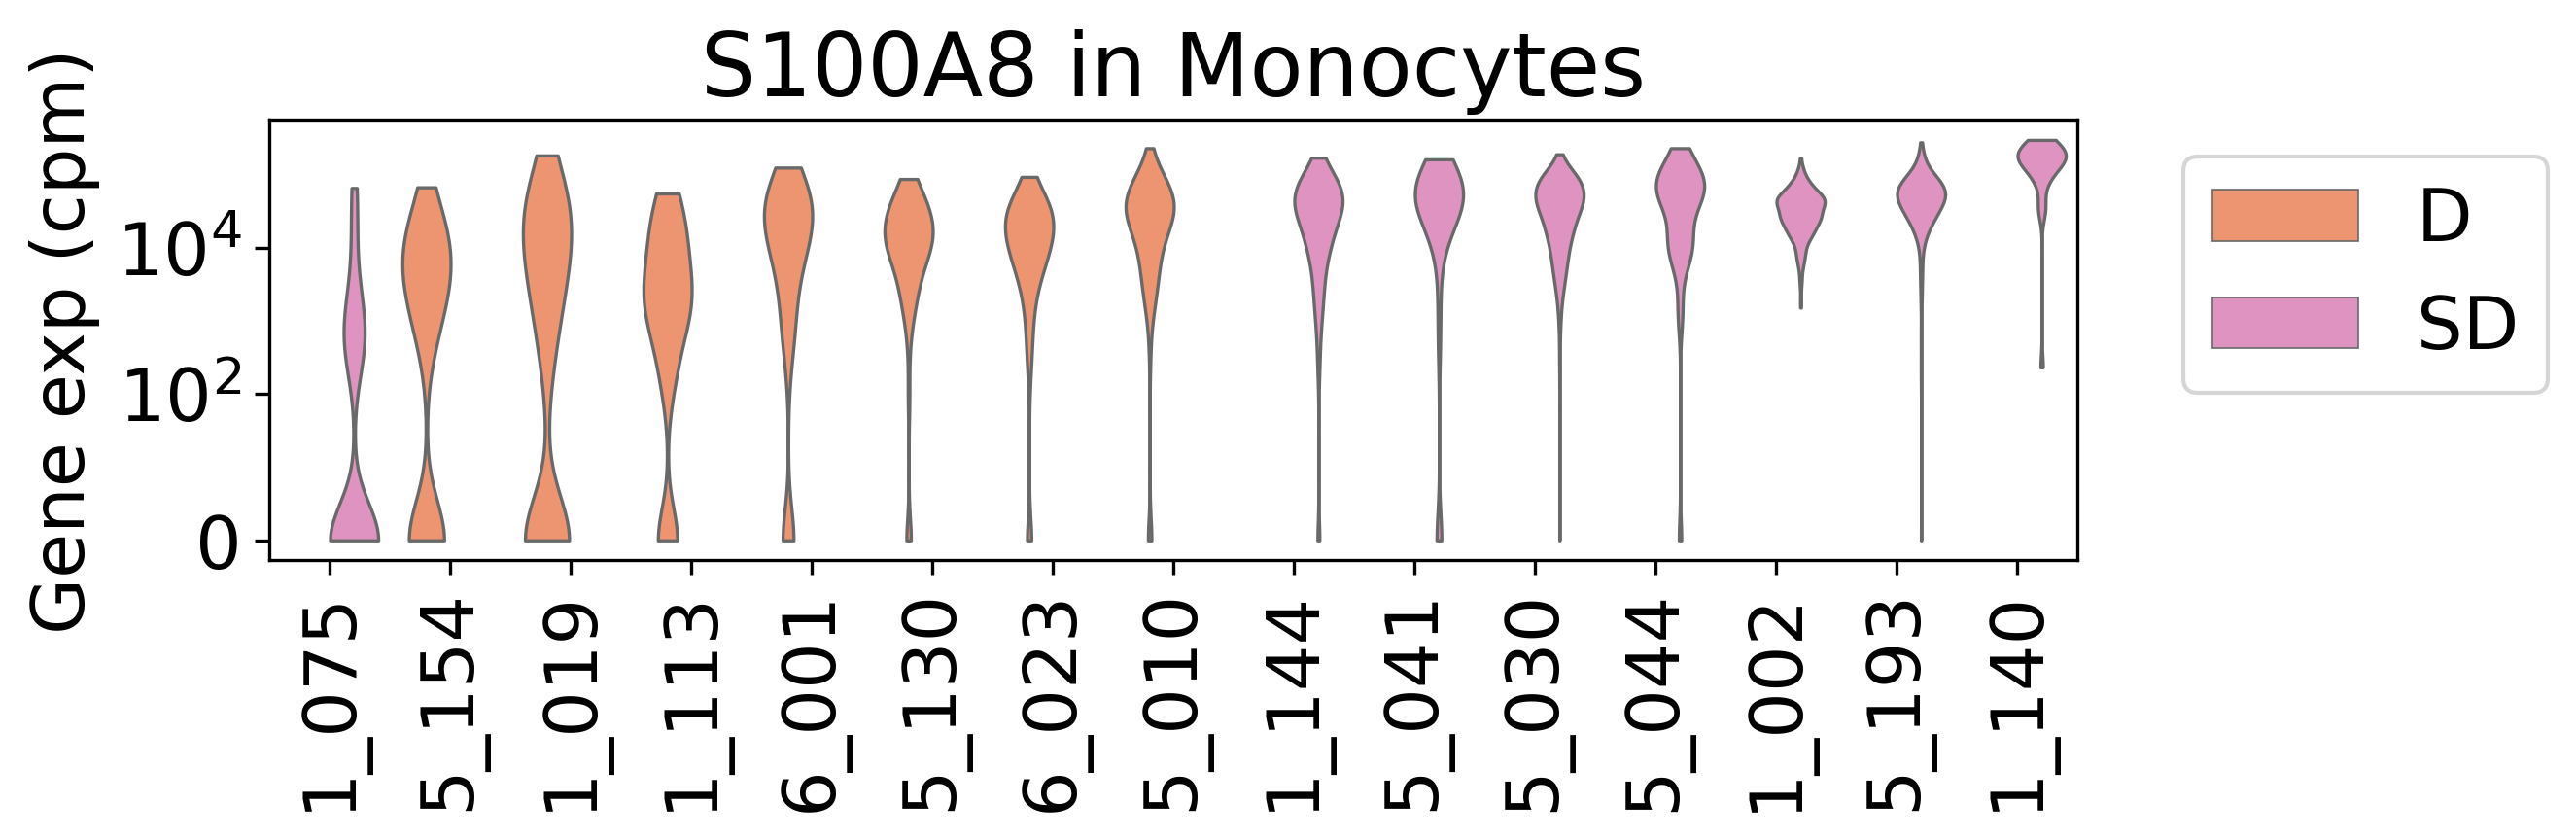

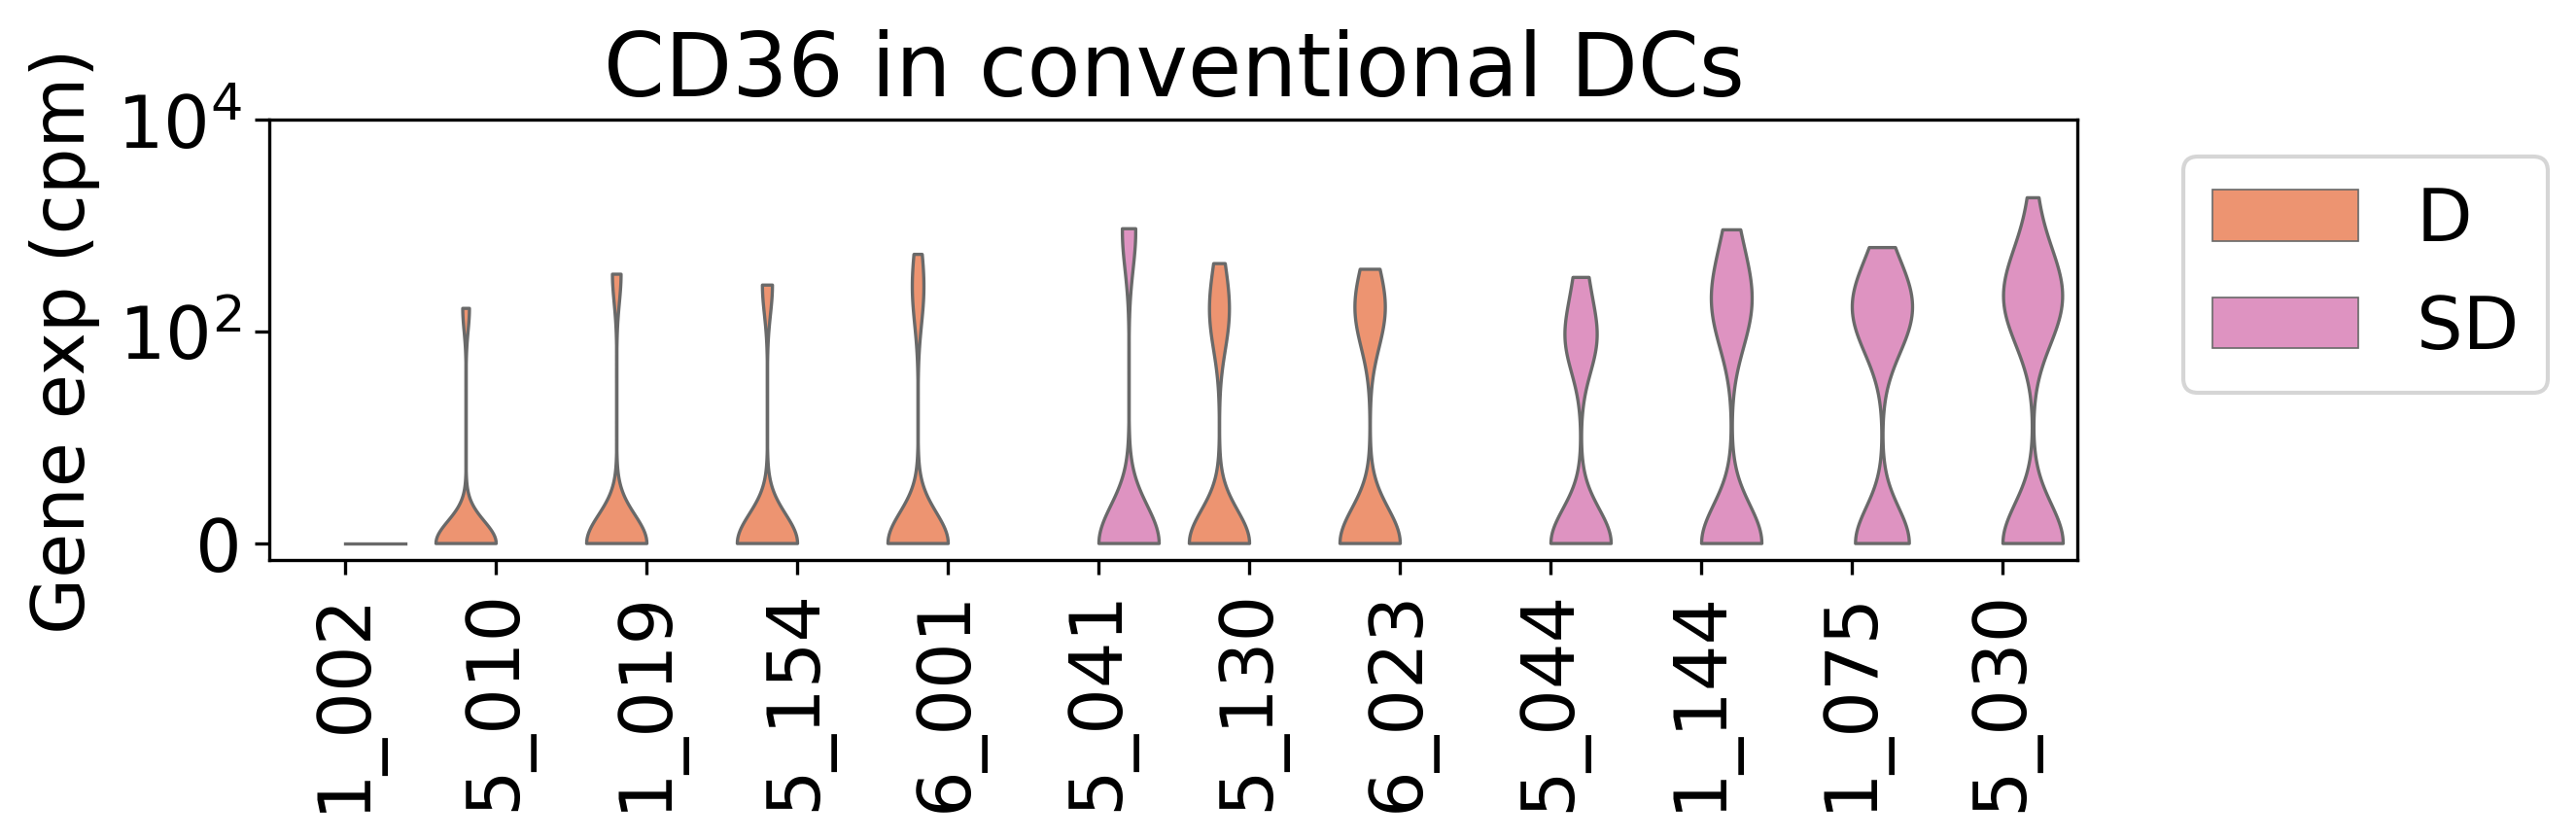

In [178]:
# res = pd.read_csv(save_tables + 'sig_ct_inters.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])
ran_res = pd.read_csv(save_tables + 'randomization_inters.tsv', sep='\t', index_col=['ga', 'cta', 'gb', 'ctb'])

randomization_plot(save_figures, [('S100A8', 'Monocytes', 'CD36', 'conventional DCs')], 
                   ran_res[~ran_res.duplicated()], filetype='.png')
randomization_plot(save_figures, [('S100A8', 'Monocytes', 'CD36', 'conventional DCs')], 
                   ran_res[~ran_res.duplicated()], filetype='.pdf')

violin('S100A8', 'Monocytes', path=False)
violin('CD36', 'conventional DCs', path=False)

# get heatmaps showing number of interactions after randomization test

In [12]:
ct_res = pd.read_csv(save_tables + 'sig_ct_inters.tsv', sep='\t')
cst_res = pd.read_csv(save_tables + 'sig_cst_inters.tsv', sep='\t')

get heatmap showing the number of upregulated interactions


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


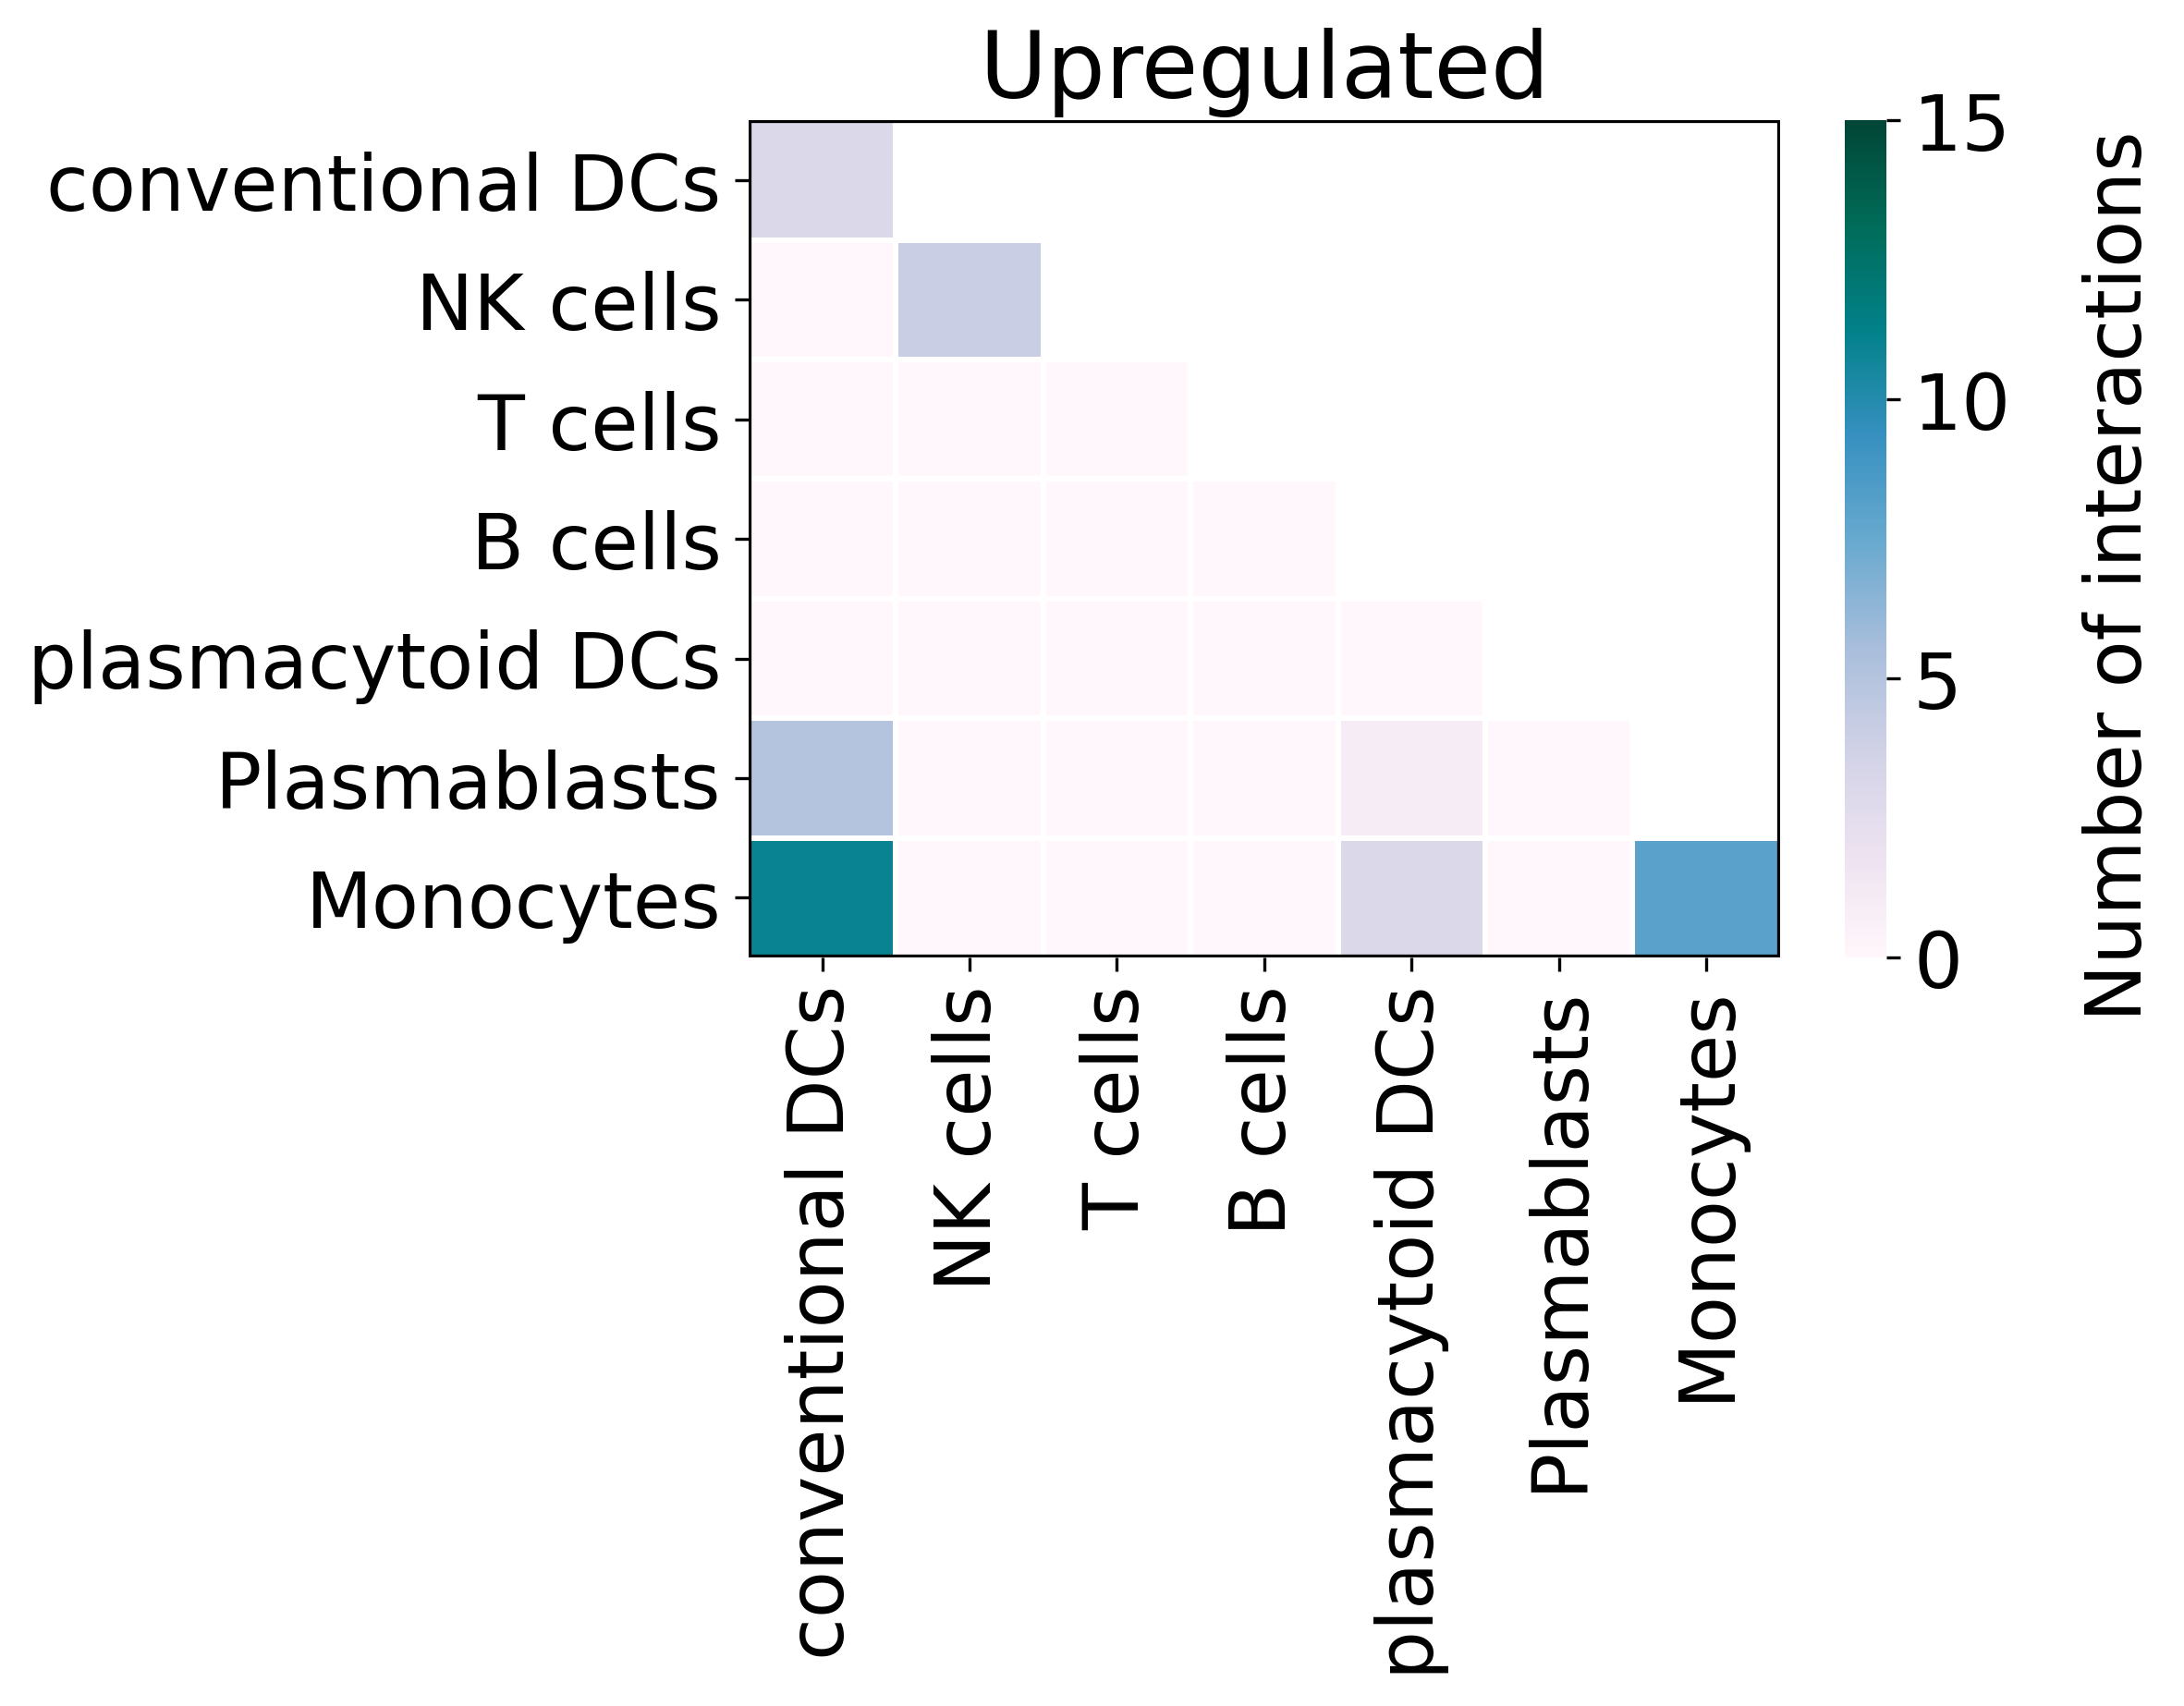

In [180]:
up = ct_res[ct_res['inter_type'] == 'up']
#from make_figure_functions import inter_number
print('get heatmap showing the number of upregulated interactions')
fig = inter_number(adata_kid, up, 15, 'Up', 'PuBuGn')['figure']
fig.savefig(save_figures + 'up_inters.png', bbox_inches='tight')
fig.savefig(save_figures + 'up_inters.pdf', bbox_inches='tight')

get heatmap showing the number of mixregulated interactions


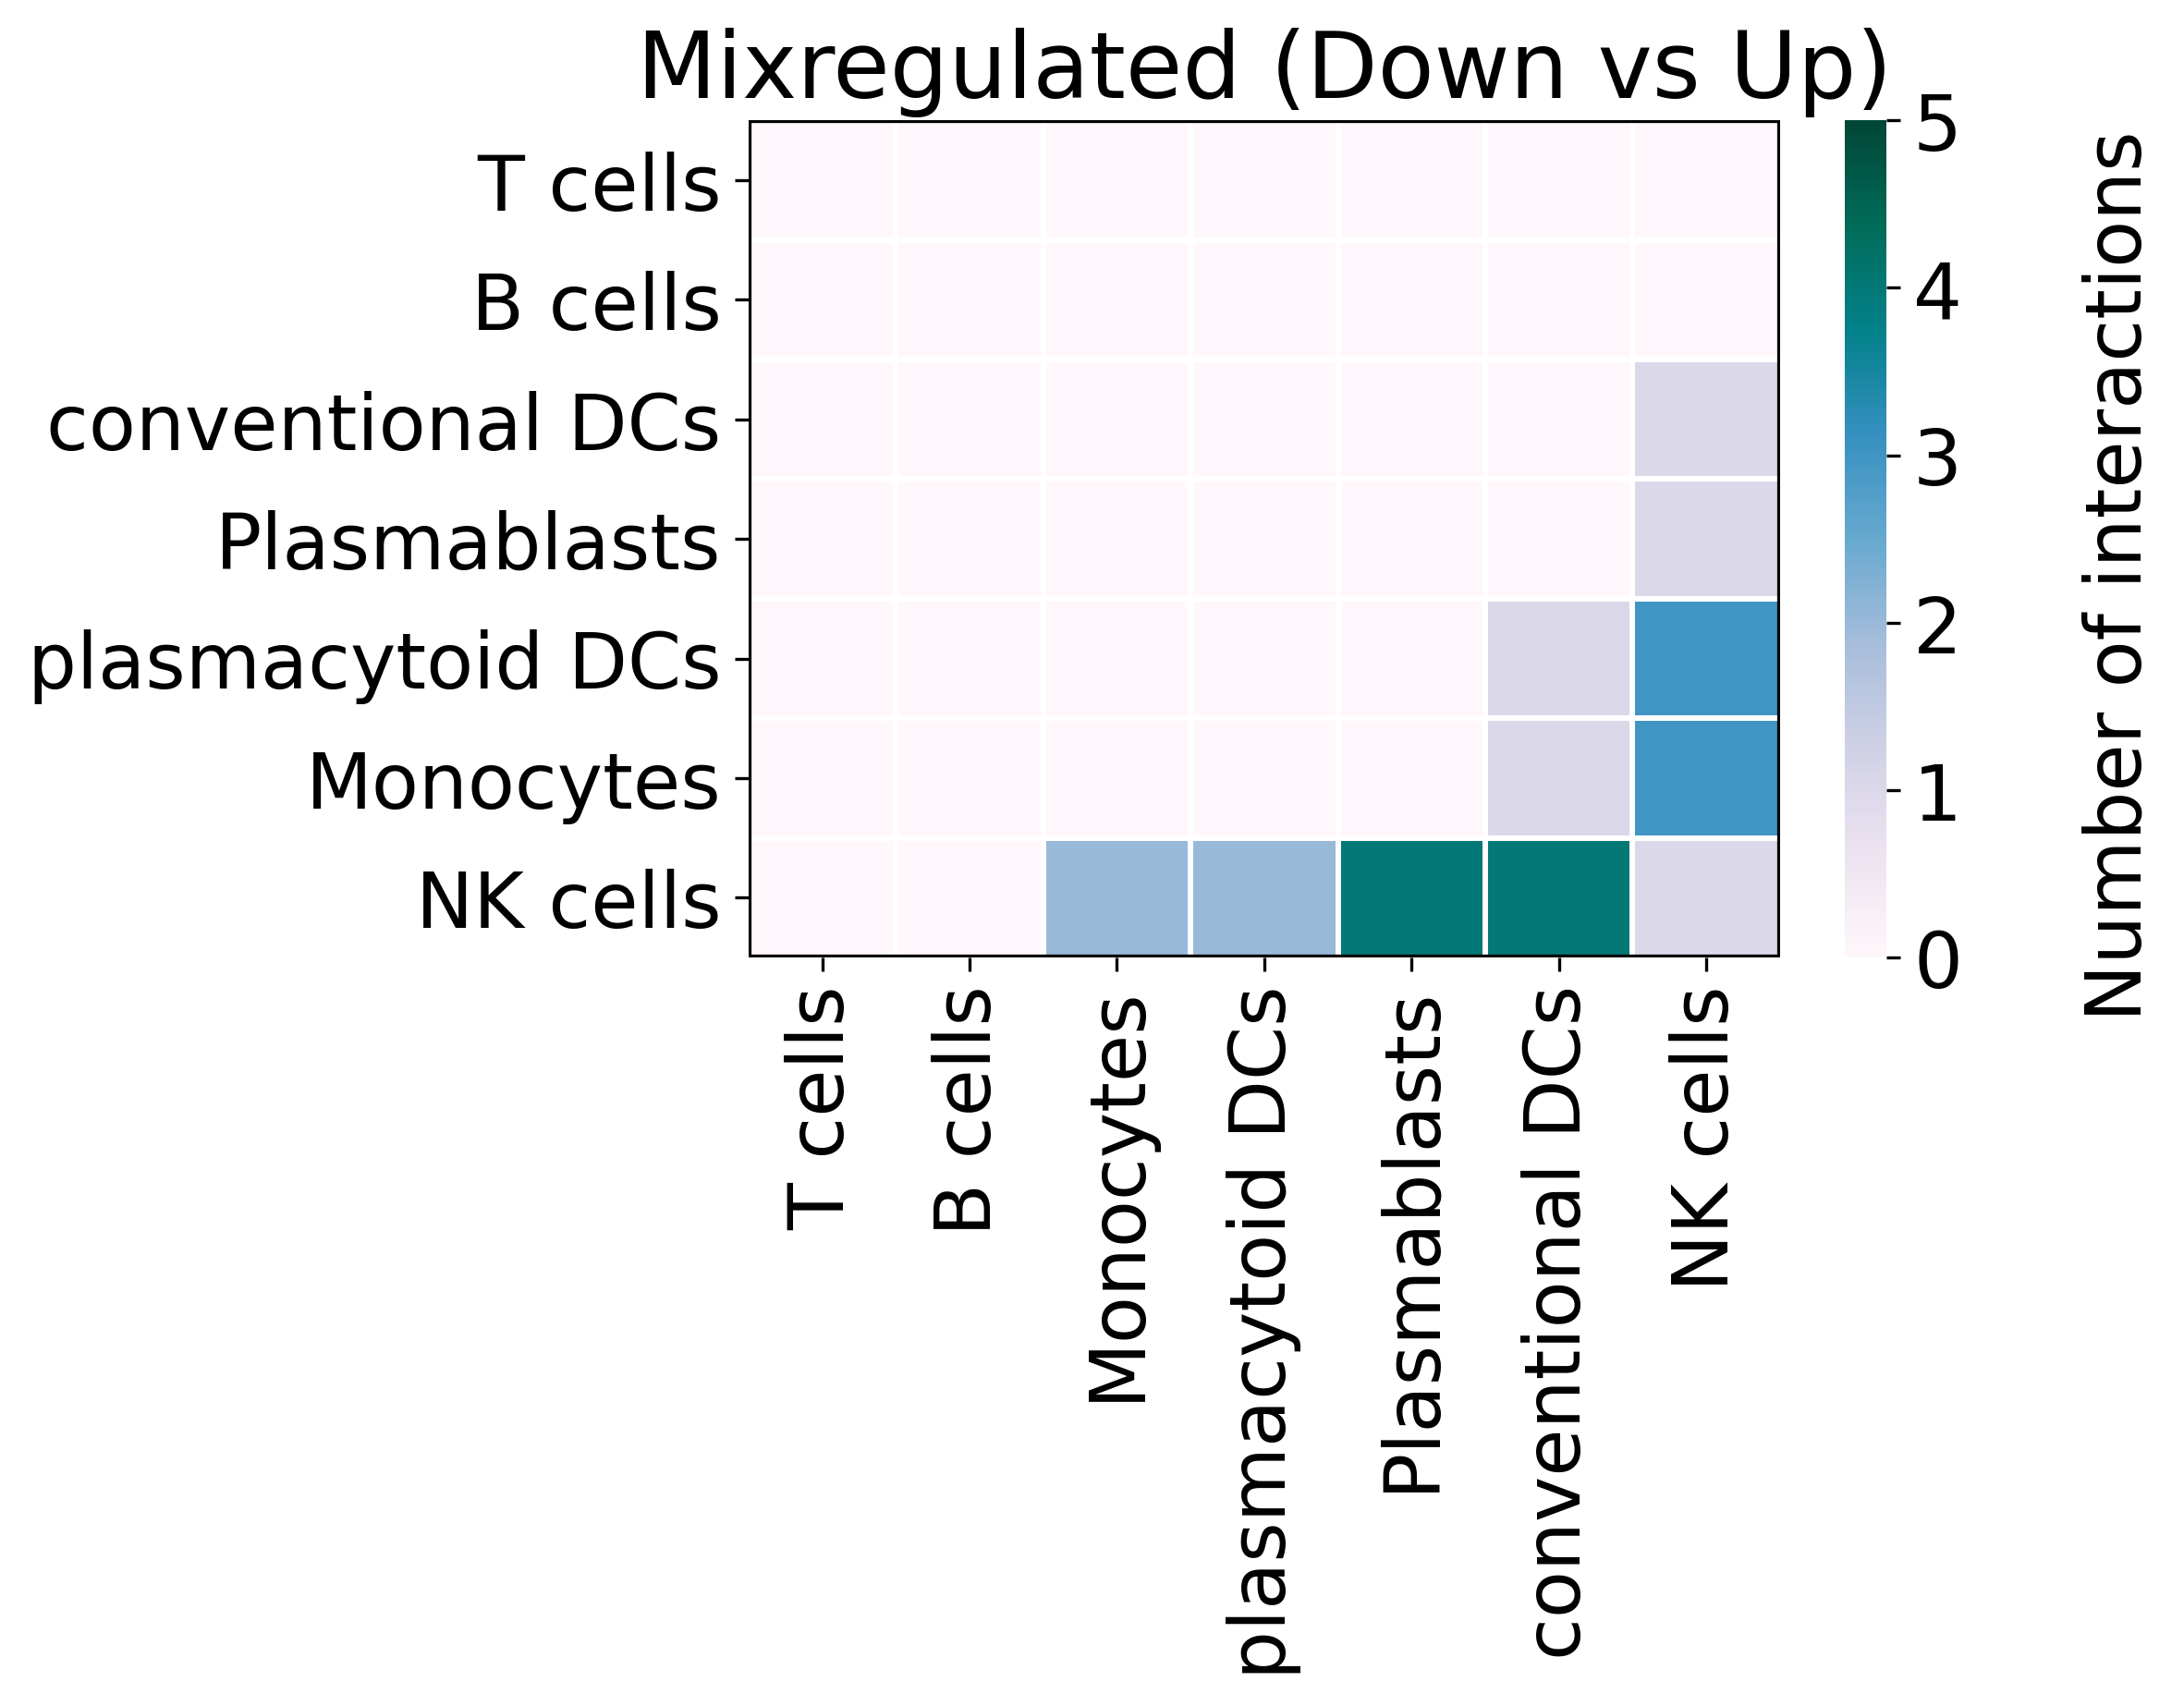

In [183]:
mix = ct_res[ct_res['inter_type'] == 'mix']
#from make_figure_functions import inter_mix_number
print('get heatmap showing the number of mixregulated interactions')
fig = inter_mix_number(adata_kid, mix, 5, 'PuBuGn')['figure']
fig.savefig(save_figures + 'mix_inters.png', bbox_inches='tight')
fig.savefig(save_figures + 'mix_inters.pdf', bbox_inches='tight')

# Specific interactions in cts or csts

In [13]:
cts_inters = ct_res.set_index(['ga', 'csta', 'gb', 'cstb']).index
csts_inters = cst_res.set_index(['ga', 'csta', 'gb', 'cstb']).index

ct_cst = {
    'Monocytes': ['classical monocytes',  'intermediate monocytes', 'non-classical monocytes'], 
    'Plasmablasts': ['non-proliferating plasmablasts', 'proliferating plasmablasts'],
    'B cells': ['naive B cells', 'memory B cells', 'activated B cells'],
    'T cells': [ 'CD4+ naive T cells',
                 'CD4+ memory T cells',
                 'CD8+ naive T cells',
                 'CD8+ effector memory T cells',
                 'CD8+ exhausted T cells',
                 'Tregs',
                 'MAIT',],
    'NK cells': ['cytotoxic NK cells', 'signaling NK cells'],
    'conventional DCs': ['cDC1', 'cDC2'],
    'plasmacytoid DCs': ['plasmacytoid DCs'],
}

In [14]:
cst_in = []
cst_out = []

for inter in csts_inters:
    for key1 in ct_cst.keys():
        if inter[1] in ct_cst[key1]:
            ct1 = key1
    for key2 in ct_cst.keys():
        if inter[3] in ct_cst[key2]:
            ct2 = key2
    interi = (inter[0], ct1, inter[2], ct2)
    interj = ( inter[2], ct2, inter[0], ct1)
    
    if (interi in cts_inters) | (interj in cts_inters):
        cst_in.append(inter)
    else:
        cst_out.append(inter)

In [15]:
print('get interactions with same genes and coresponding cell subtypes as significant cts inters')

in_inter = cst_res.set_index(['ga', 'csta', 'gb', 'cstb']).loc[cst_in]
in_inter = in_inter[~in_inter.duplicated()]
in_inter.to_csv(save_tables + 'cst_inters_in_cts_strict.tsv', sep='\t')

out_inter = cst_res.set_index(['ga', 'csta', 'gb', 'cstb']).loc[cst_out]
out_inter = out_inter[~out_inter.duplicated()]
out_inter.to_csv(save_tables + 'cst_inters_out_cts_strict.tsv', sep='\t')

get interactions with same genes and coresponding cell subtypes as significant cts inters


# get barplot shwoing gene number in distinct cell types from sig_inters

only use interactions with med_pair >=1 or <= -1


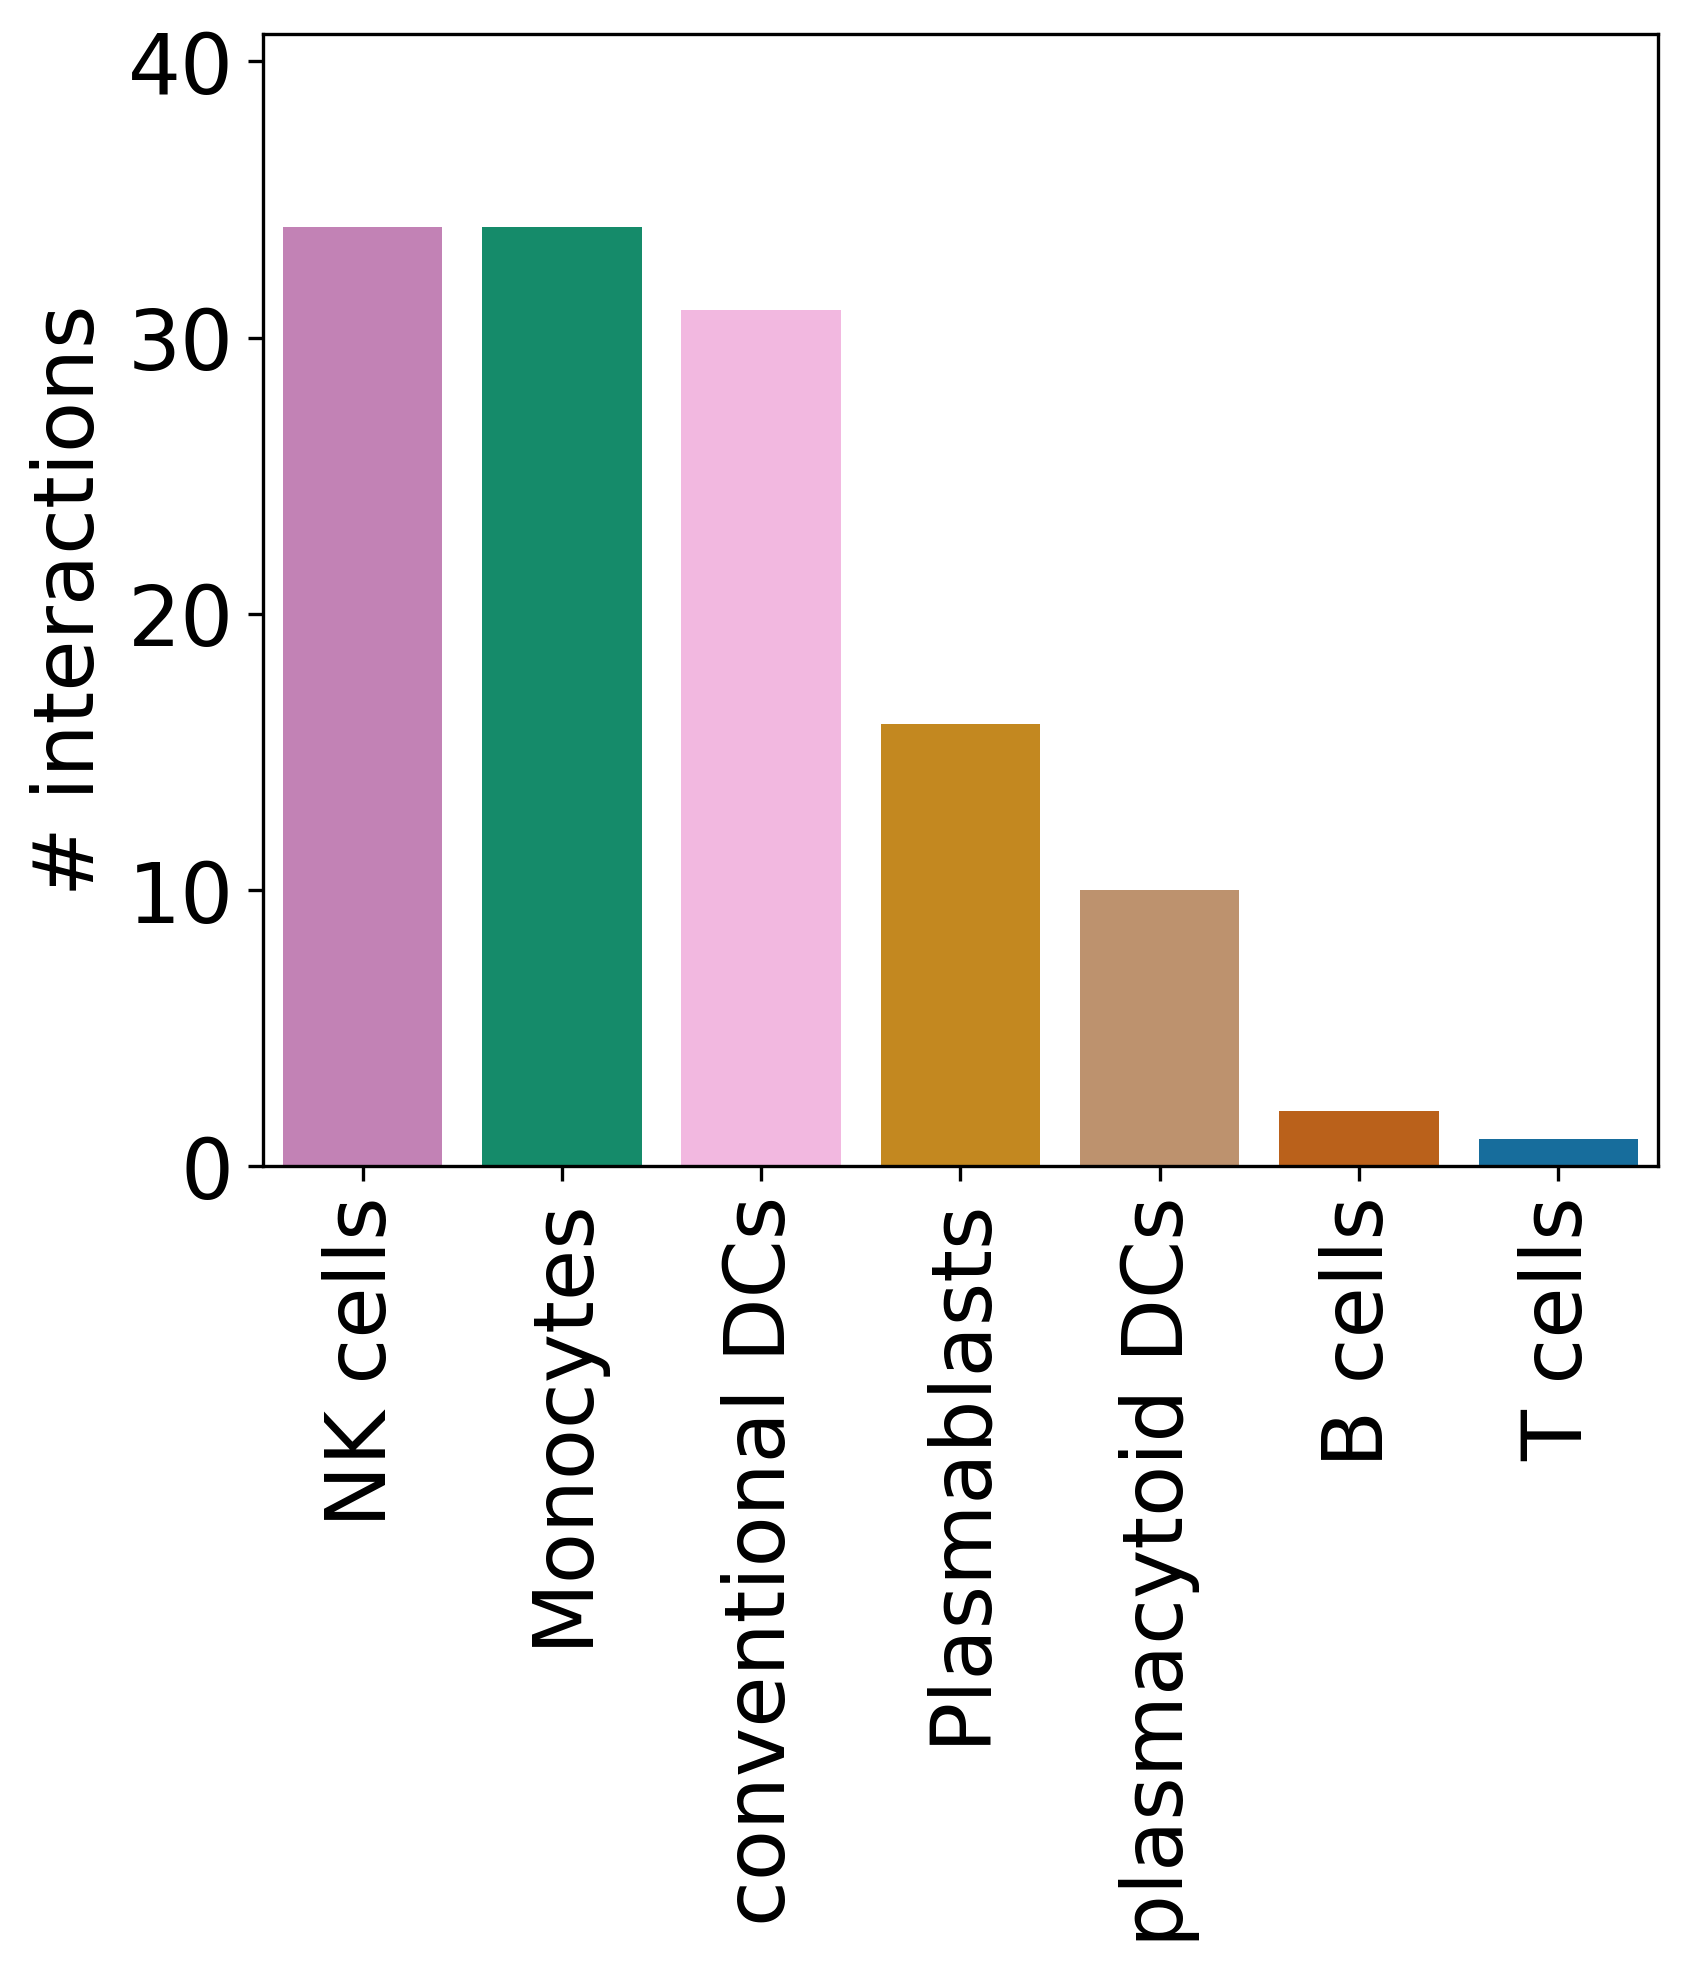

In [188]:
print('only use interactions with med_pair >=1 or <= -1')
cts = adata_kid.obs['cell_type_new'].unique().tolist()

if 'doublets' in cts:
    cts.remove('doublets')
if 'unknown' in cts:
    cts.remove('unknown')
if 'megakaryocytes' in cts:
    cts.remove('megakaryocytes')

ct_n = {ct: 0 for ct in cts}
for inter in cts_inters:
    for ct in cts:
        if inter[1] == ct:
            ct_n[ct] += 1
        elif inter[3] == ct:
            ct_n[ct] += 1

#######################################################
sig_it_n = pd.DataFrame(ct_n.values(), columns=['Number of interactions'])
sig_it_n['Cell type'] = ct_n.keys()
sig_it_n.sort_values('Number of interactions', ascending=False, inplace=True)

#######################################################
palette = [ct_palette[ct] for ct in sig_it_n['Cell type']]
rcParams['pdf.fonttype'] = 42
rcParams['figure.dpi'] = 300
rcParams['font.sans-serif'] = "Arial"
fig, ax = plt.subplots(figsize=[6, 5])
ax = sns.barplot(data=sig_it_n, x='Cell type', y='Number of interactions', palette=palette)
ax.set_ylim(0, (sig_it_n['Number of interactions'].iloc[0] // 10 + 1) * 10 + 1)
ax.set_xlabel(None)
ax.set_ylabel('# interactions')
plt.xticks(rotation=90)
fig.savefig(save_figures + 'n_inters_cts.png', bbox_inches='tight')
fig.savefig(save_figures + 'n_inters_cts.pdf', bbox_inches='tight')

<ipython-input-177-93ca83dd6b13>:394: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-177-93ca83dd6b13>:395: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-177-93ca83dd6b13>:394: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-177-93ca83dd6b13>:395: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticklabels(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-input-177-93ca83dd6b13>:394: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ax.set_yticks(range(0, ylim, [10, 20][ylim >= 40]))
<ipython-i

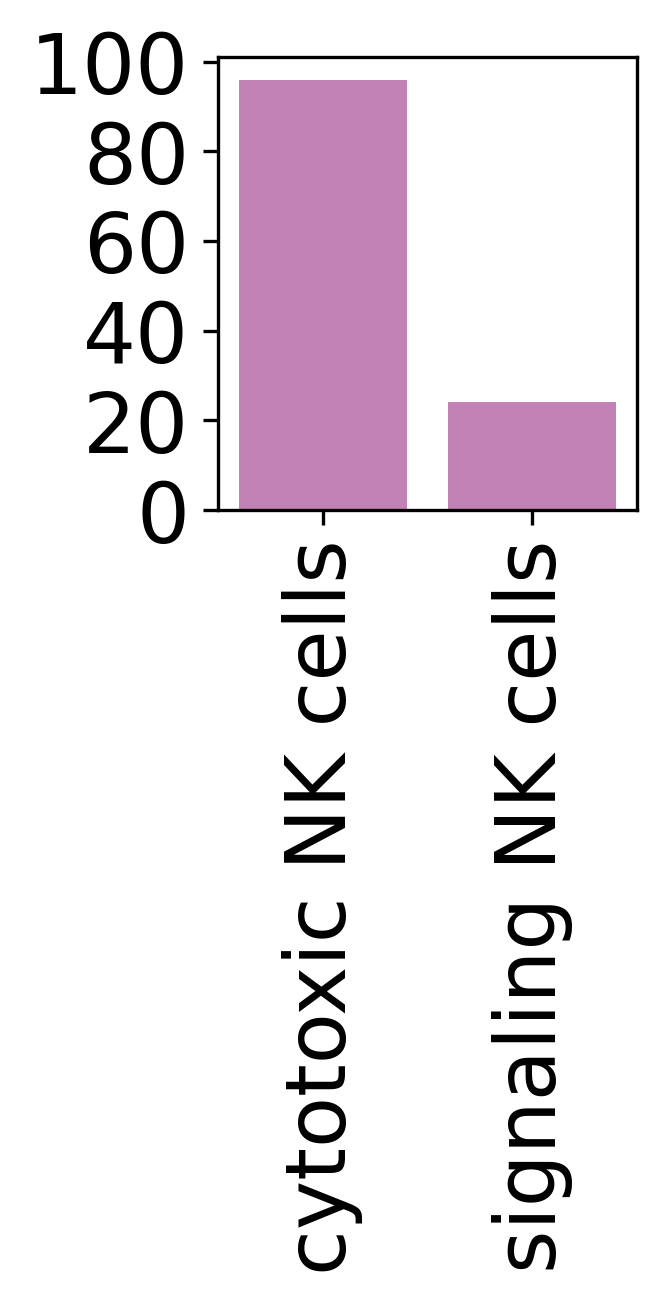

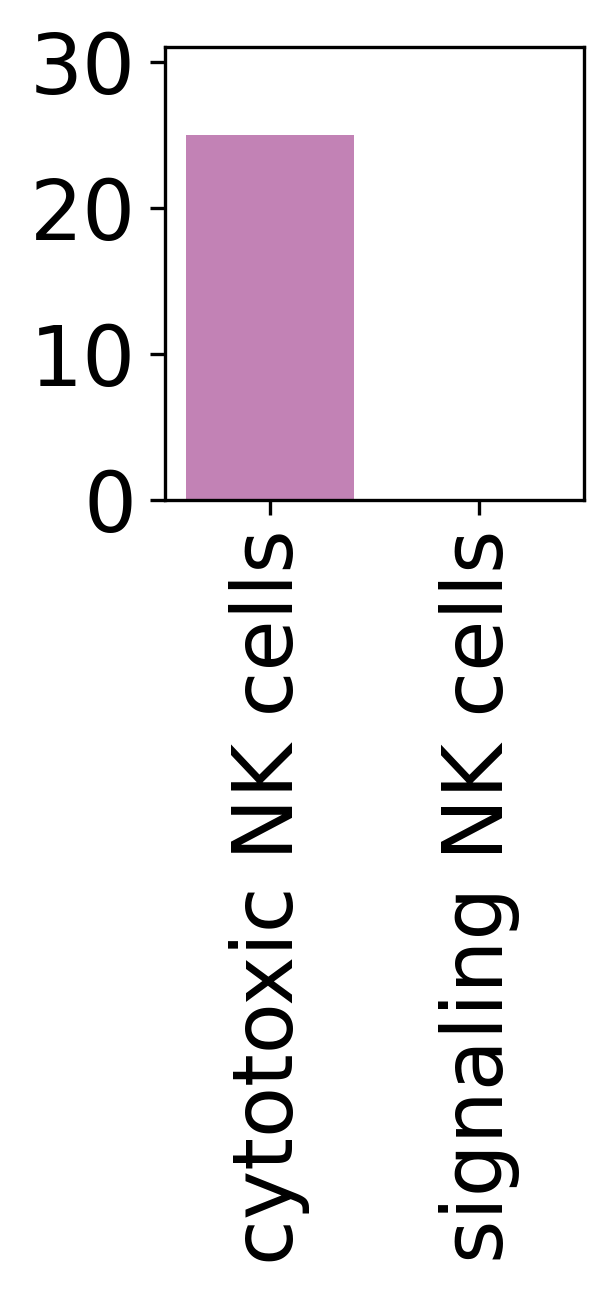

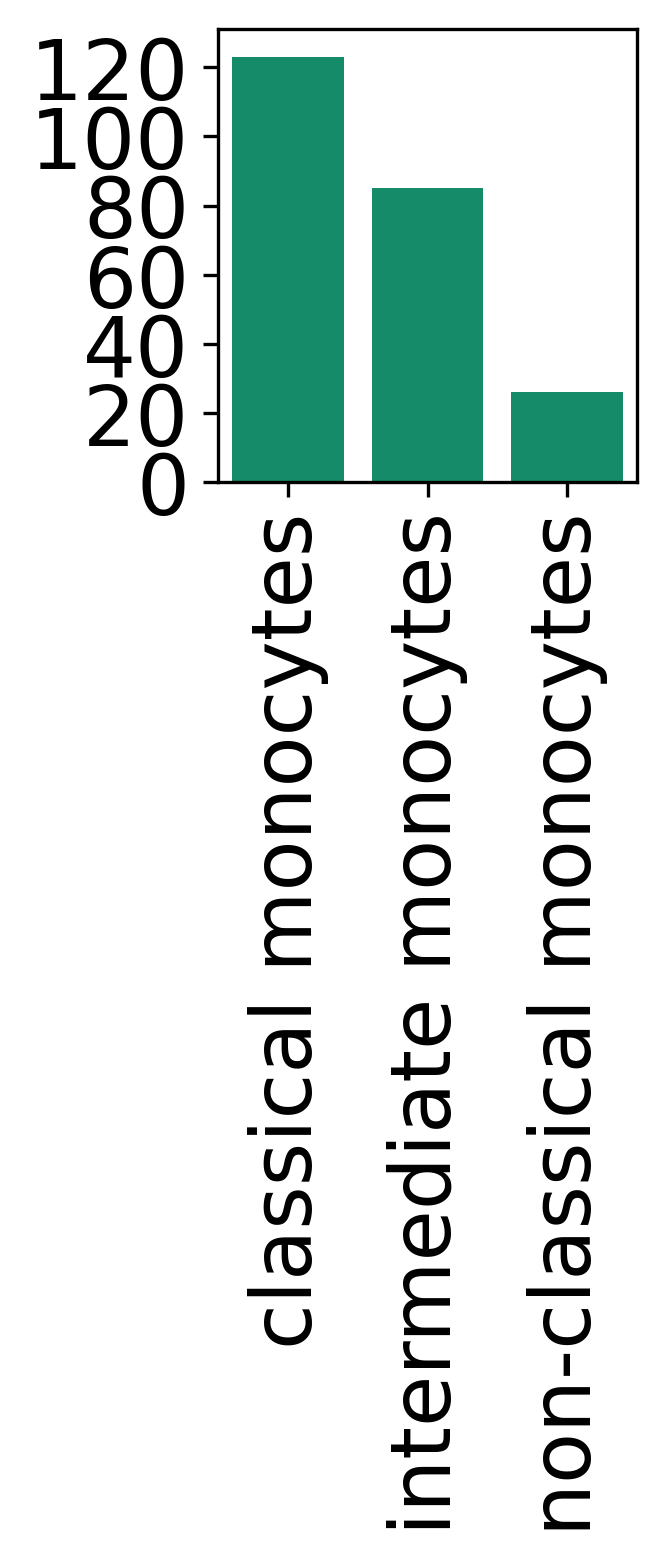

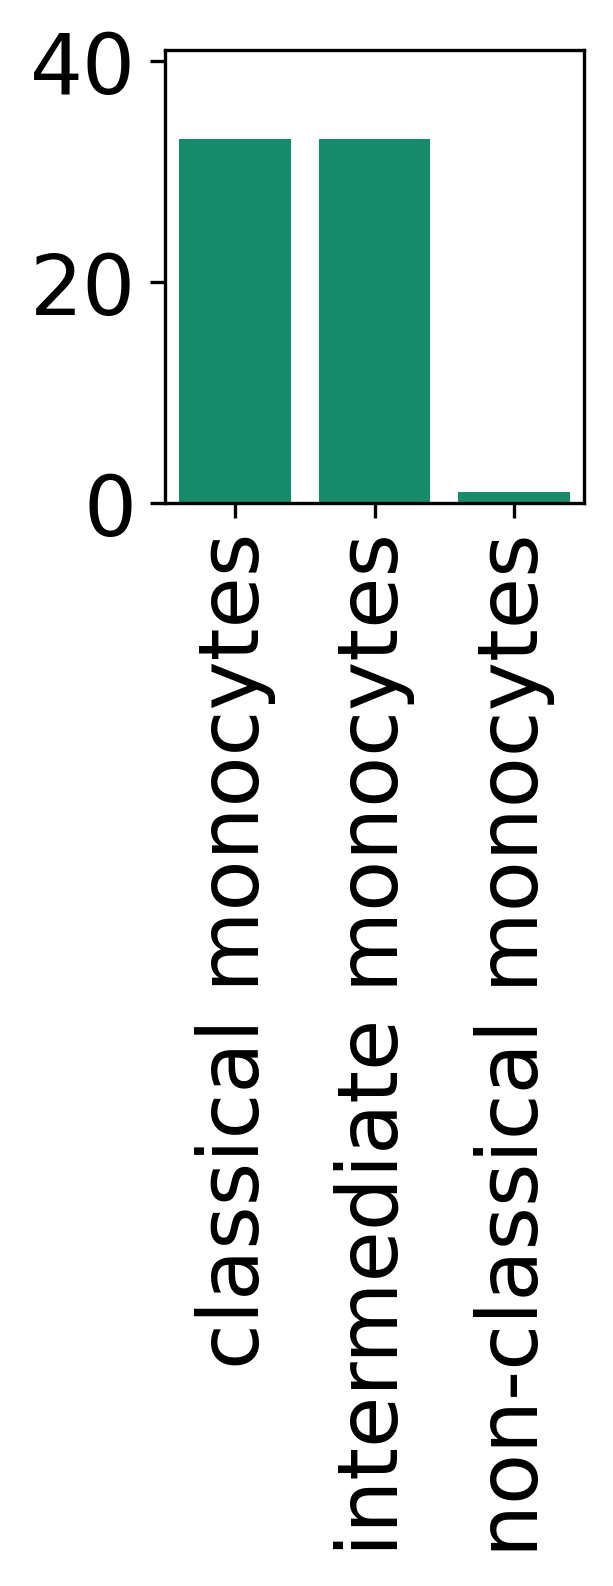

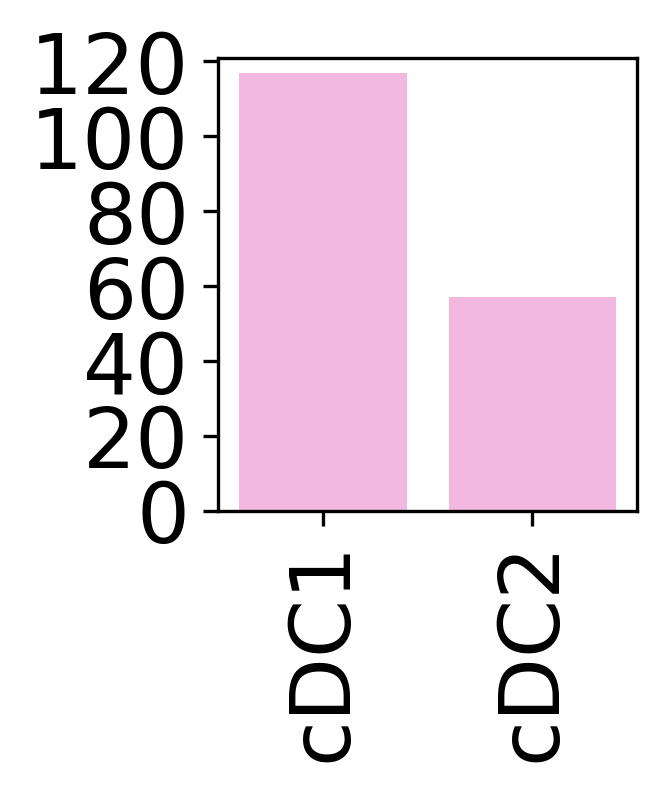

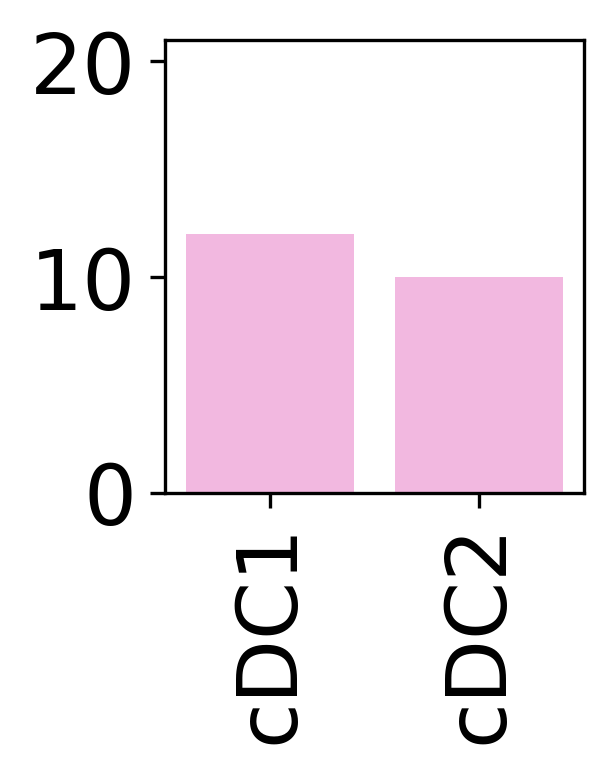

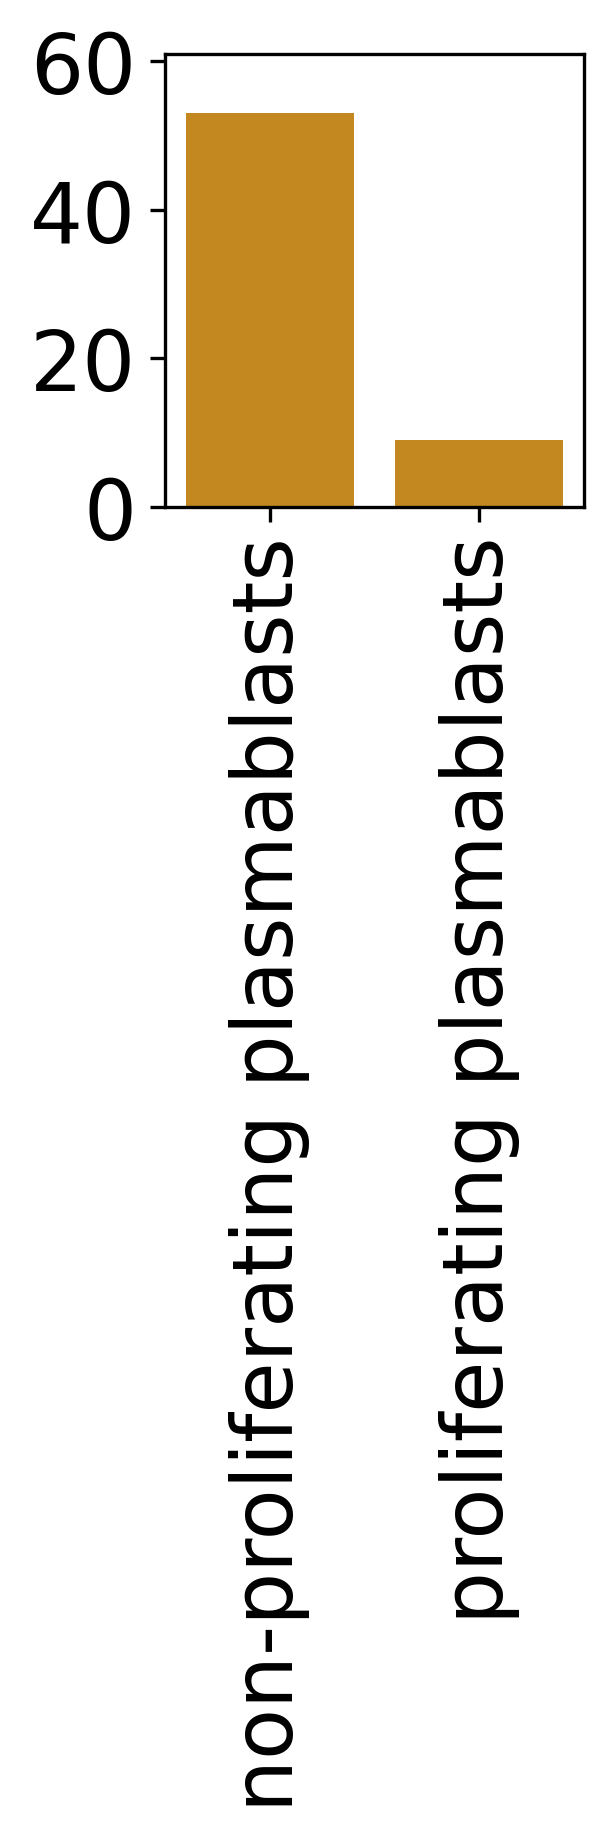

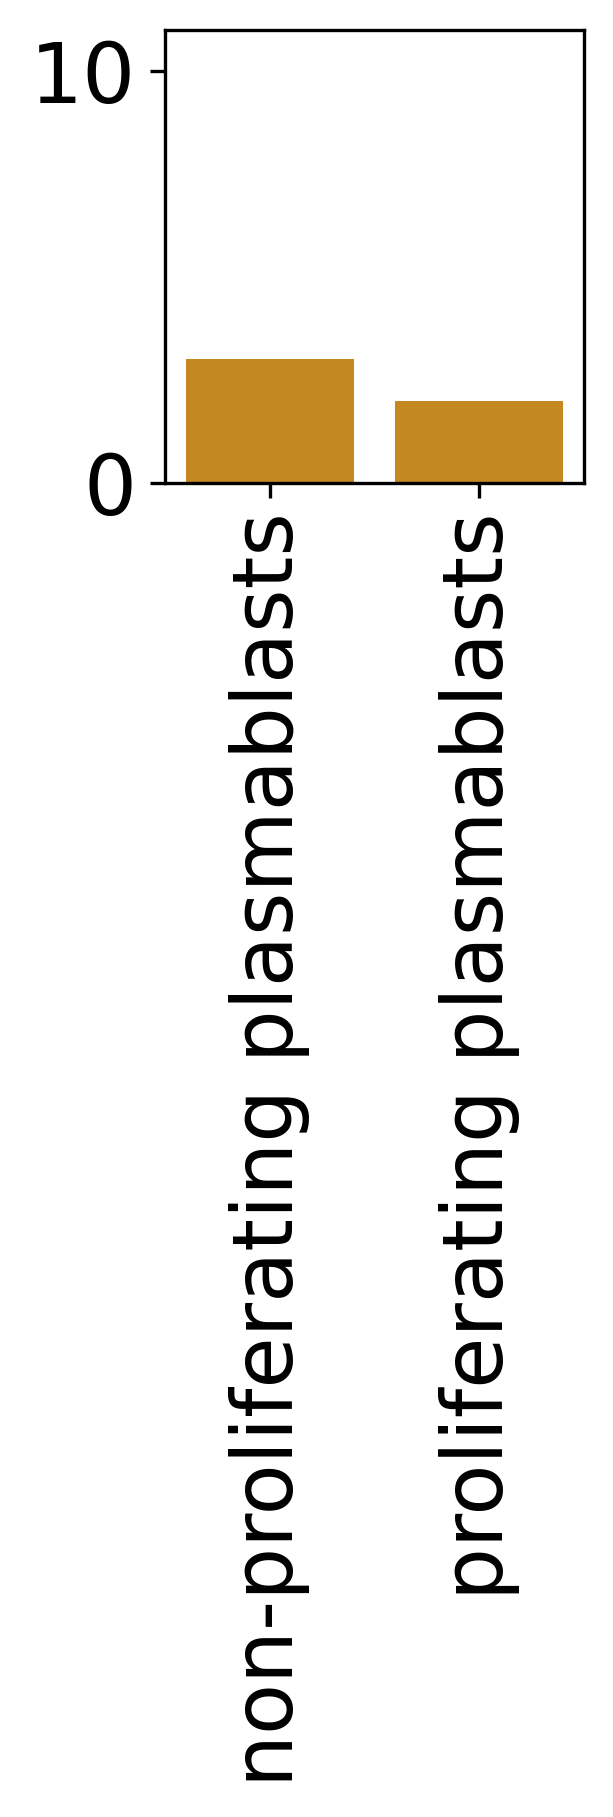

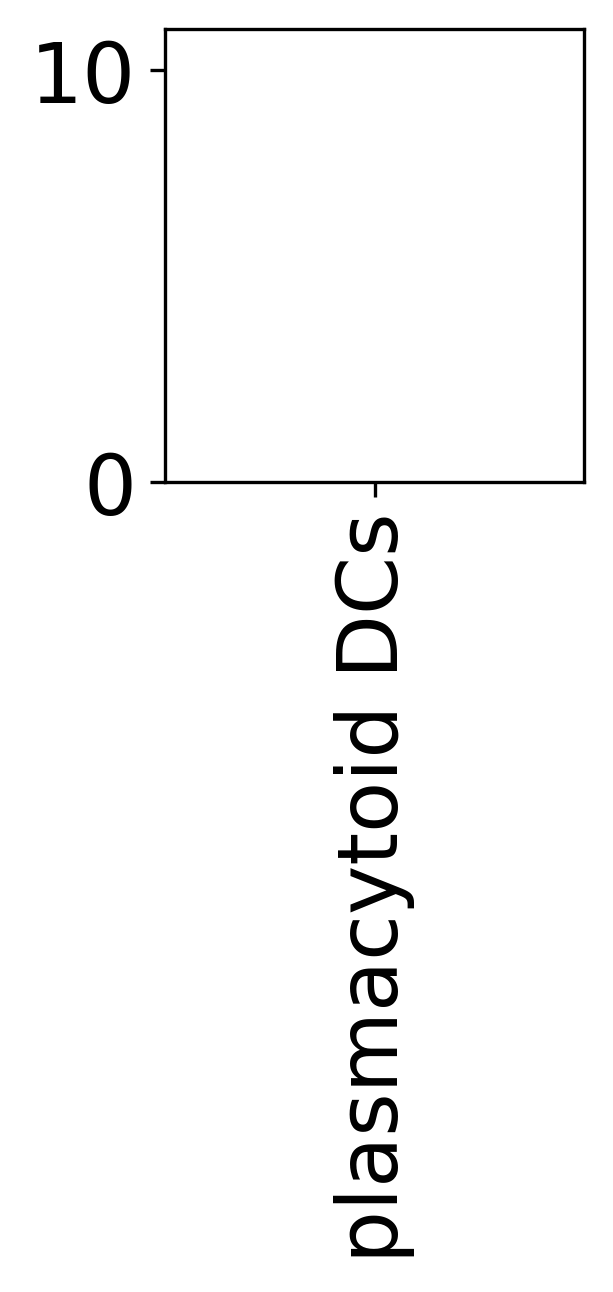

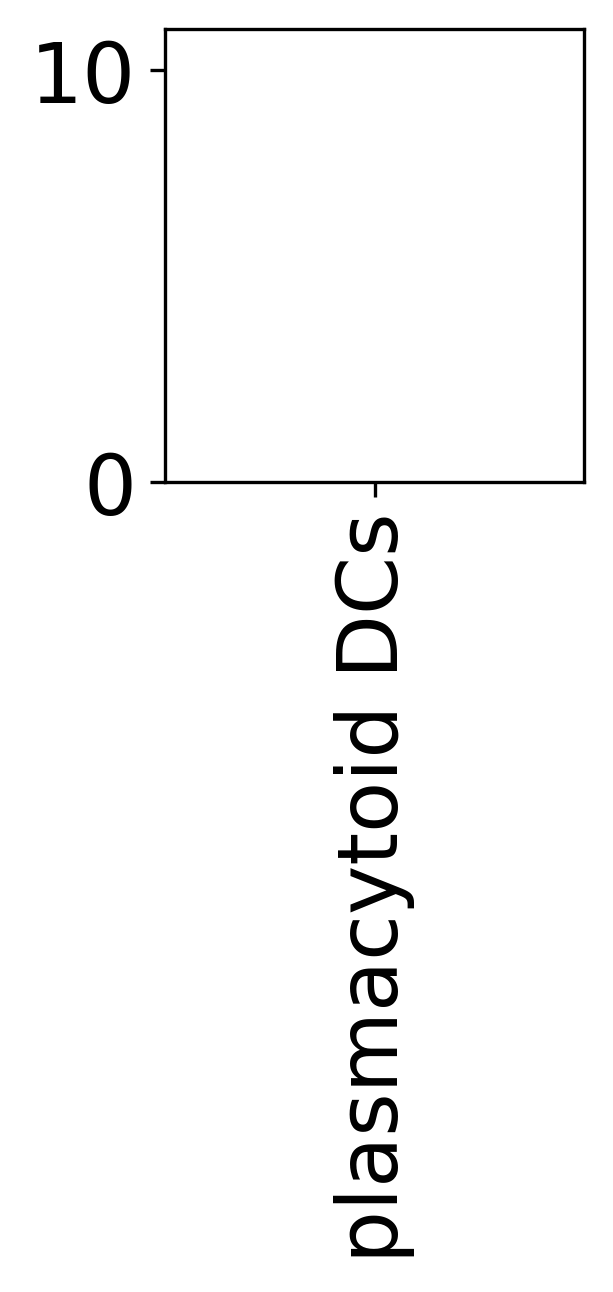

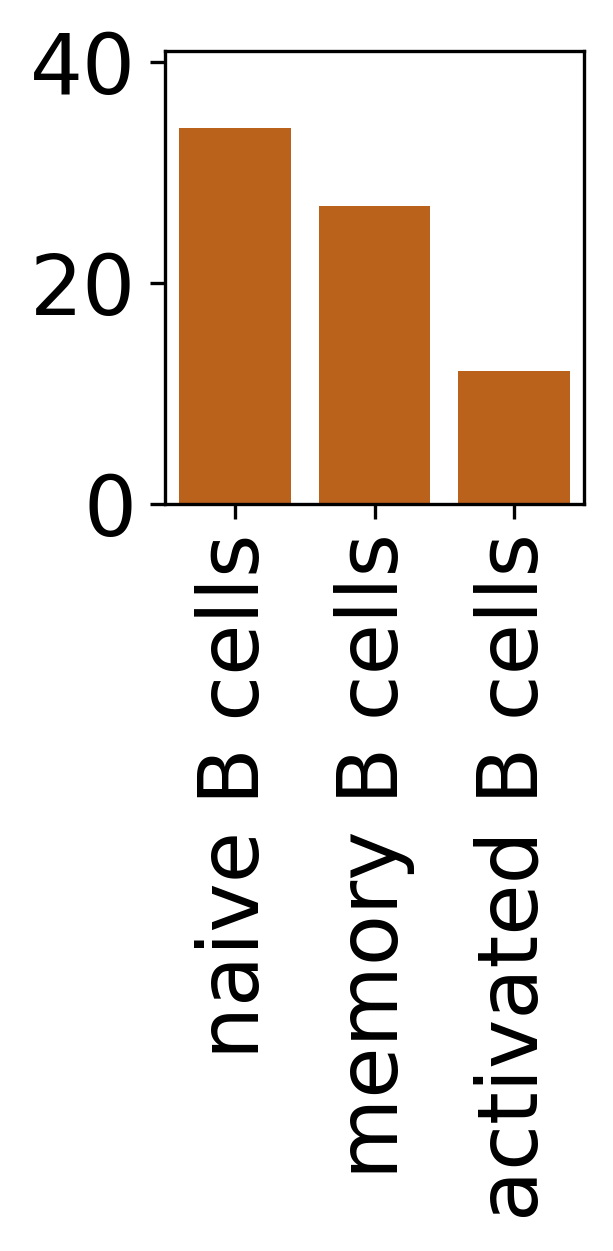

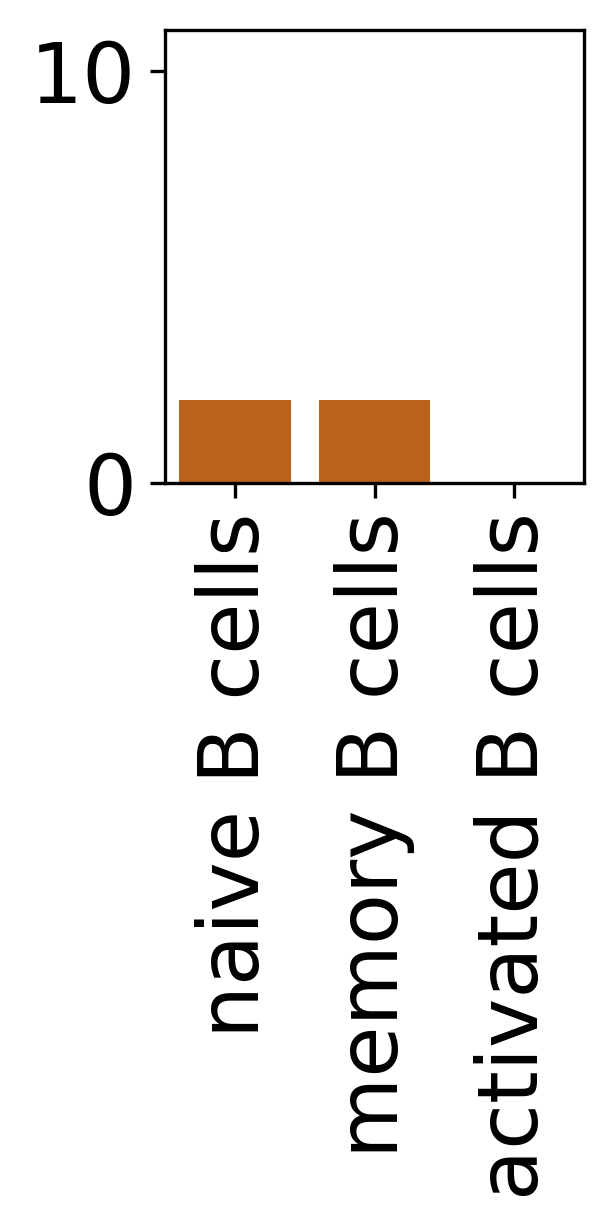

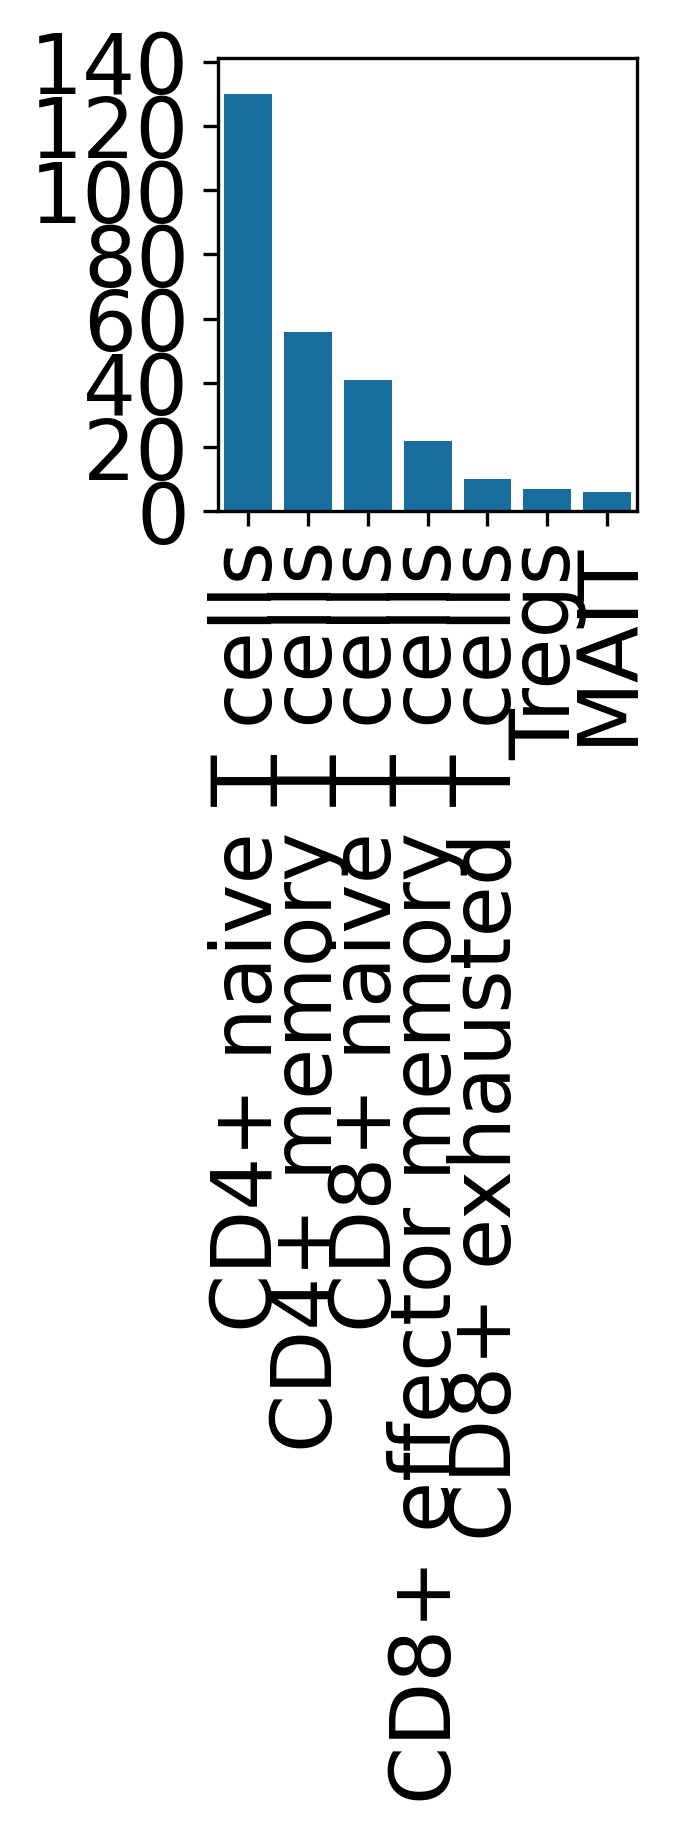

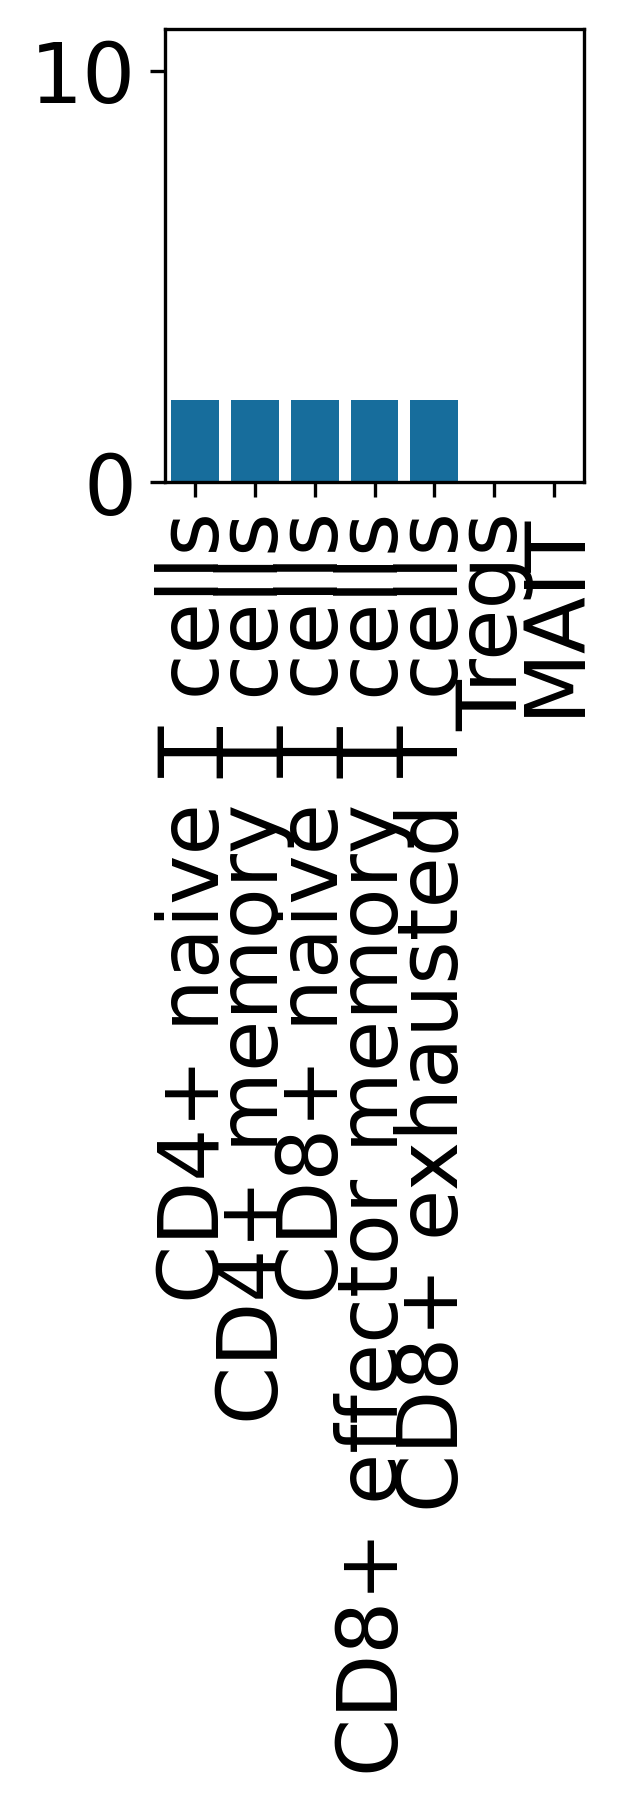

In [189]:
in_inter = pd.read_csv(save_tables + 'cst_inters_in_cts_strict.tsv', sep='\t', index_col=['ga', 'csta', 'gb', 'cstb'])
cst_inters = cst_res.set_index(['ga', 'csta', 'gb', 'cstb'])

for i, ct in enumerate(sig_it_n['Cell type']):
    fig1 = cst_number(cst_inters, ct_cst[ct], ct_palette[ct])['figure']
    fig1.savefig(save_figures + ct + '_subtype_inters.png', bbox_inches='tight')
    fig1.savefig(save_figures + ct + '_subtype_inters.pdf', bbox_inches='tight')
    
    fig2 = cst_number(in_inter, ct_cst[ct], ct_palette[ct])['figure']
    fig2.savefig(save_figures + ct + '_in_cst_inters.png', bbox_inches='tight')
    fig2.savefig(save_figures + ct + '_in_cst_inters.pdf', bbox_inches='tight')

# get list with significant inters after randomization test for mushroom plot

In [190]:
ct_res = pd.read_csv(save_tables + 'sig_ct_inters.tsv', sep='\t')
up = ct_res[ct_res['inter_type'] == 'up']
mix = ct_res[ct_res['inter_type'] == 'mix']

In [211]:
up.set_index(['csta', 'cstb']).sort_index()

ga     gb inter_type  ga_med_pair  \
csta             cstb                                                        
Monocytes        B cells               VCAN   SELL         up     3.084326   
                 Monocytes             VCAN   SELL         up     3.084326   
                 Monocytes             CD14  ITGB2         up     1.836027   
                 Monocytes           S100A8  ITGB2         up     2.614053   
                 Monocytes           S100A9  ITGB2         up     2.095529   
                 Monocytes             CD14   VCAN         up     1.836027   
                 Monocytes           S100A8   CD36         up     2.614053   
                 Monocytes          S100A12   CD36         up     2.216083   
                 Monocytes           S100A9   CD36         up     2.095529   
                 NK cells              VCAN  ITGB1         up     3.084326   
                 NK cells              CD14  ITGB1         up     1.836027   
                 NK cells              VCAN   SELL         up     3.084326   
                 T cells               VCAN   SELL         up     3.084326   
                 conventional DCs      VCAN  ITGB1         up     3.084326   
                 conventional DCs      CD14  ITGB1         up     1.836027   
                 conventional DCs      VCAN   SELL         up     3.084326   
                 conventional DCs      CD14  ITGB2         up     1.836027   
                 conventional DCs    S100A8  ITGB2         up     2.614053   
                 conventional DCs    S100A9  ITGB2         up     2.095529   
                 conventional DCs    S100A8   CD36         up     2.614053   
                 conventional DCs   S100A12   CD36         up     2.216083   
                 conventional DCs    S100A9   CD36         up     2.095529   
                 conventional DCs    S100A9  ALCAM         up     2.095529   
                 conventional DCs      RETN   CAP1         up     1.423147   
                 plasmacytoid DCs      CD14  ITGB2         up     1.836027   
                 plasmacytoid DCs    S100A8  ITGB2         up     2.614053   
                 plasmacytoid DCs    S100A9  ITGB2         up     2.095529   
NK cells         NK cells            LGALS3   LAG3         up     1.075001   
                 NK cells          HLA-DRB1   LAG3         up     2.360038   
                 NK cells          HLA-DPA1   LAG3         up     1.722038   
                 NK cells          HLA-DPB1   LAG3         up     1.237735   
Plasmablasts     B cells               RAC1    EZR         up     1.024279   
                 NK cells              RAC1  ITGB1         up     1.024279   
                 NK cells            COL6A3  ITGB1         up     1.125593   
                 NK cells            LGALS3   LAG3         up     1.259548   
                 conventional DCs      RAC1  ITGB1         up     1.024279   
                 conventional DCs    COL6A3  ITGB1         up     1.125593   
                 conventional DCs      RAC1    EZR         up     1.024279   
                 conventional DCs      RAC1   TLN1         up     1.024279   
                 conventional DCs    COL6A3  ITGB7         up     1.125593   
                 plasmacytoid DCs      RAC1   KTN1         up     1.024279   
conventional DCs Monocytes            TIMP1   CD63         up     1.996596   
                 NK cells              TLN1  ITGB1         up     1.703950   
                 NK cells            ADAM15  ITGB1         up     1.717683   
                 NK cells             GNAI2   CD3E         up     1.370216   
                 Plasmablasts         GNAI2  CXCR3         up     1.370216   
                 conventional DCs      TLN1  ITGB1         up     1.703950   
                 conventional DCs    ADAM15  ITGB1         up     1.717683   
                 conventional DCs    LILRB4  LAIR1         up     1.091497   

                                   ga_fra_pair  ga_neg_fra_pai

# mushroom plots

<ipython-input-177-93ca83dd6b13>:420: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_fra_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:422: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_avg_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:425: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'cst_fra_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:427: FutureWarning: The squeeze argument has been deprecated and will be removed in a f

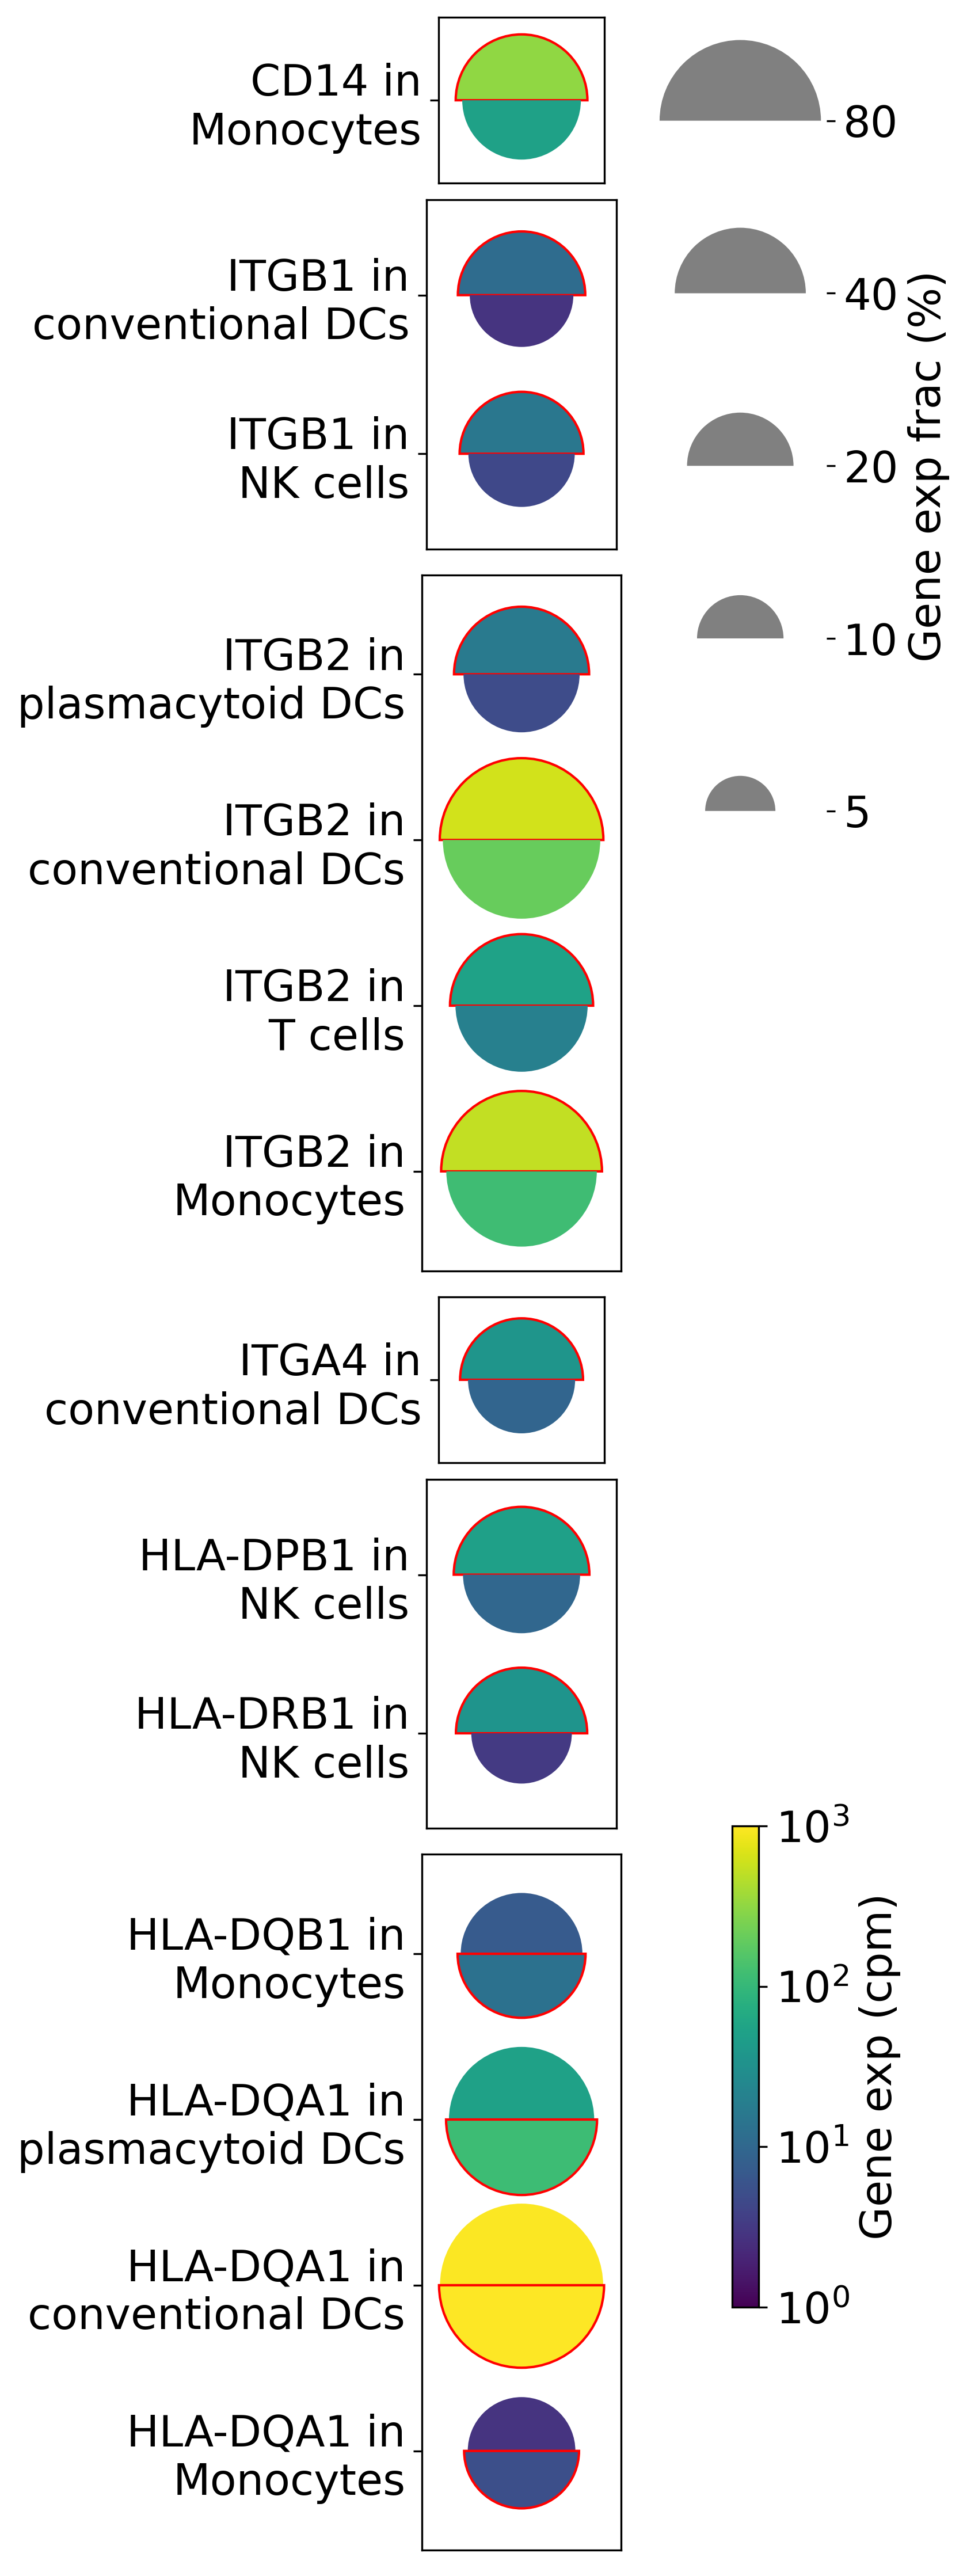

In [193]:
genes3 = [{'CD14': ['Monocytes']},
          {'ITGB1': ['NK cells', 'conventional DCs', ]},
          {'ITGB2': ['Monocytes', 'T cells', 'conventional DCs', 'plasmacytoid DCs', ]},
          {'ITGA4': ['conventional DCs']},
          {'HLA-DRB1': ['NK cells'], 'HLA-DPB1': 'NK cells', 'HLA-DPB1': ['NK cells']},
          {'HLA-DQA1': ['Monocytes', 'conventional DCs', 'plasmacytoid DCs'], 'HLA-DQB1': ['Monocytes']}
         ]
fig = s_mushrooms(genes3, 'cell_type_new')['figure']
fig.savefig(save_figures + 'inters_plus.png', bbox_inches='tight')
fig.savefig(save_figures + 'inters_plus.svg', bbox_inches='tight')

<ipython-input-177-93ca83dd6b13>:420: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_fra_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:422: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'ct_avg_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:425: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/dataset_20211001/' + 'cst_fra_gene_cut_0.tsv',
<ipython-input-177-93ca83dd6b13>:427: FutureWarning: The squeeze argument has been deprecated and will be removed in a f

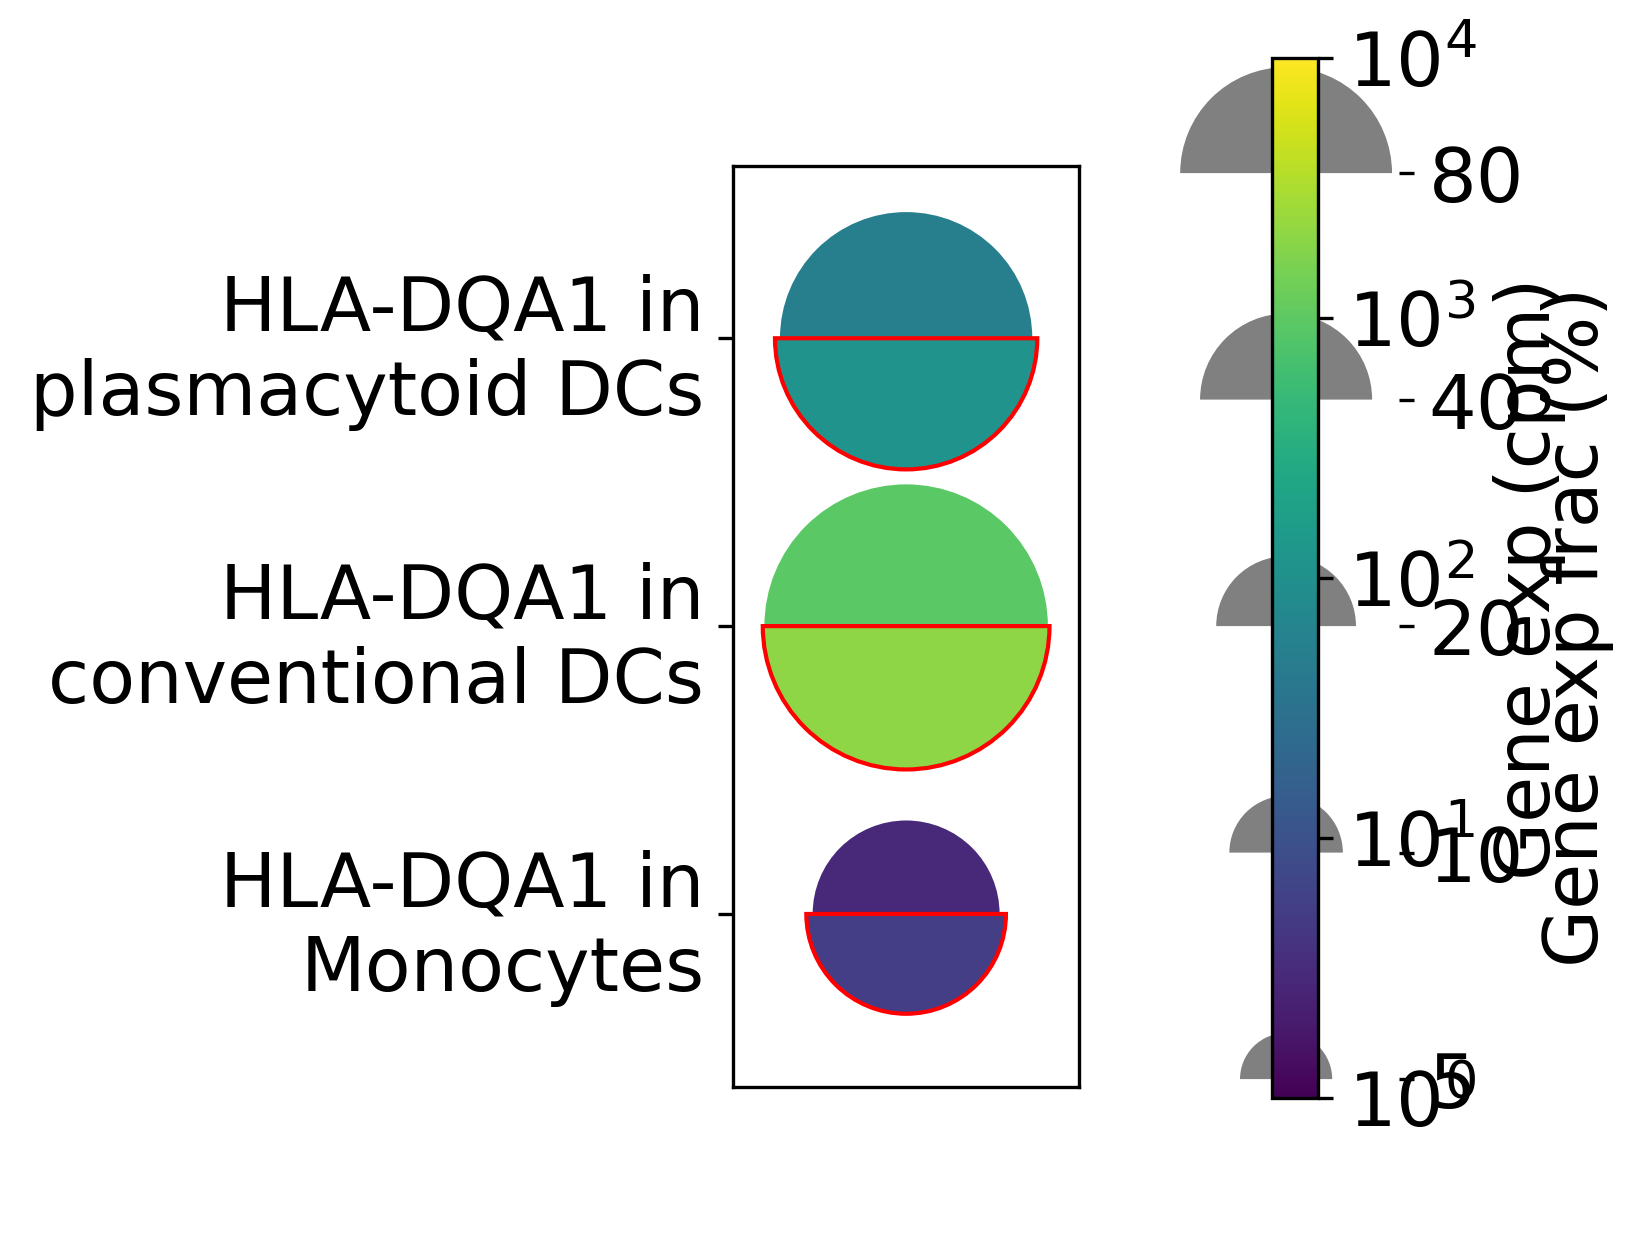

In [194]:
genes3 = [
          {'HLA-DQA1': ['Monocytes', 'conventional DCs', 'plasmacytoid DCs']}
         ]
fig = s_mushrooms(genes3, 'cell_type_new', vmax=4)['figure']
fig.savefig(save_figures + 'inters_plus2.png', bbox_inches='tight')
fig.savefig(save_figures + 'inters_plus2.svg', bbox_inches='tight')

In [228]:
if False:
    def plus(ori_res_inters, res_inters):    
        idx_plus = []
        idx = []
        ori_idx = ori_res_inters.set_index(['ga', 'csta', 'gb', 'cstb']).index.tolist()

        for i, row in res_inters.iterrows():
            ga = row['ga']
            csta = row['csta']
            gb = row['gb']
            cstb = row['cstb']

            if ((ga, csta, gb, cstb) not in ori_idx) & (( gb, cstb, ga, csta,) not in ori_idx):
                idx_plus.append(i) 
            elif ((ga, csta, gb, cstb) in ori_idx) | (( gb, cstb, ga, csta,) in ori_idx):
                idx.append(i)
        return idx_plus, idx

    def o_plus(res_inters, ori_res_inters):    
        o_idx_plus = []

        idx = res_inters.set_index(['ga', 'csta', 'gb', 'cstb']).index
        for i, row in ori_res_inters.iterrows():
            ga = row['ga']
            csta = row['csta']
            gb = row['gb']
            cstb = row['cstb']

            if ((ga, csta, gb, cstb) not in idx) & ((gb, cstb, ga, csta) not in idx):
                o_idx_plus.append(i)
        return o_idx_plus

    idx_plus, idx = plus(ori_res_inters, res_inters)
    cst_idx_plus, cst_idx = plus(ori_cst_res_inters, cst_res_inters)

    res_inters.loc[idx_plus].to_csv(save_figures + 'ct_inters_plus.tsv', sep='\t')
    cst_res_inters.loc[cst_idx_plus].to_csv(save_figures + 'cst_inters_plus.tsv', sep='\t')